In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la


In [2]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [3]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [37]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
#From https://github.com/pachterlab/CGCCP_2023/blob/main/Code/Preprint/Preprocess_Data.ipynb, B08 sample

#Already selected for hvgs
ds = lp.connect('/home/tchari/counts/allen_bivi/loom/B08_processed_hv.loom')
ds

In [7]:
meta = pd.DataFrame()
meta['cell_type'] = ds.ca['Cell Type']
meta['cell_barcode'] = ds.ca['barcode']
meta['cluster_id'] = ds.ca['cluster_id']
meta['class_label'] = ds.ca['class_label']

uniqs = np.unique(meta['cell_type'])
cell_type_dict = dict(zip(uniqs,range(len(uniqs))))
meta['cell_type_id'] = [cell_type_dict[i] for i in meta['cell_type']]

print(meta.head())
#Just in case
counts = ds.layers['counts'][:,:] #U,S x cells for 2000 hvgs, Raw counts

  cell_type      cell_barcode  cluster_id    class_label  cell_type_id
0     L5 IT  AAACCCAAGTGAACAT          42  Glutamatergic             4
1   L2/3 IT  AAACCCAAGTTGAATG          40  Glutamatergic             2
2     L5 IT  AAACCCACACGATAGG          42  Glutamatergic             4
3   L2/3 IT  AAACCCACAGAGGGTT          40  Glutamatergic             2
4     L6 CT  AAACCCAGTACTAAGA          60  Glutamatergic             6


In [66]:
#Save with standard names
all_counts = counts.T
allS = all_counts[:,2000:]
allU = all_counts[:,0:2000]
retAdata = anndata.AnnData(
			X=allS,
			layers={
				'spliced': allS,
				'unspliced': allU
			},
			obs=pd.DataFrame({'barcode': ds.ca['barcode']},index=ds.ca['barcode']),
			var=pd.DataFrame({'gene_name': ds.ra['gene_name'][0:2000]},index=ds.ra['gene_name'][0:2000])
		)

retAdata.write_loom('/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
ds.close()

In [9]:
meta['cell_type'] = [i.replace(' ','_') for i in meta['cell_type']]
meta['cell_type'] = [i.replace('/','-') for i in meta['cell_type']]

In [10]:
meta['cell_type'].value_counts()

L5_IT         2395
L6_CT         1333
L2-3_IT        823
L6_IT          489
Sst            271
L5-6_NP        251
Vip            233
Lamp5          192
Pvalb          114
Oligo           82
L6b             66
Astro           49
Sncg            45
Endo            21
Macrophage      17
OPC             17
L5_ET            9
VLMC             7
L6_IT_Car3       3
SMC              1
Name: cell_type, dtype: int64

In [11]:
cell_type_dict

{'Astro': 0,
 'Endo': 1,
 'L2/3 IT': 2,
 'L5 ET': 3,
 'L5 IT': 4,
 'L5/6 NP': 5,
 'L6 CT': 6,
 'L6 IT': 7,
 'L6 IT Car3': 8,
 'L6b': 9,
 'Lamp5': 10,
 'Macrophage': 11,
 'OPC': 12,
 'Oligo': 13,
 'Pvalb': 14,
 'SMC': 15,
 'Sncg': 16,
 'Sst': 17,
 'VLMC': 18,
 'Vip': 19}

## **Initialize/Filter Data for Inference**

In [12]:
chosen = [['Vip','Lamp5','L5-6_NP'],['L6_CT','L2-3_IT','Vip']] #[['L5_IT','L2-3_IT','L6_IT'],['L6_CT','L2-3_IT','L6_IT']] 
individs = []
for names in chosen:
    individs += [[i] for i in names]

In [13]:
num_ks = 3
ks = [1,3,5] # [2,3,4] Change to 1, 3, 5?

In [14]:
dataset_meta = ['correct_B08_processed_hv']
print('dataset_meta: ', dataset_meta)
print()



#DUSP9_MAPK1__DUSP9_MAPK1 may have 'multiple transcriptional states'
subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

subcluster_names += individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(num_ks*len(chosen)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i%num_ks])
    
cluster_names = []
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/allen_bivi/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['correct_B08_processed_hv']

dataset_names:  ['allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1', 'allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3', 'allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k1', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k3', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k5', 'allen_correct_B08_processed_hv_Vip', 'allen_correct_B08_processed_hv_Lamp5', 'allen_correct_B08_processed_hv_L5-6_NP', 'allen_correct_B08_processed_hv_L6_CT', 'allen_correct_B08_processed_hv_L2-3_IT', 'allen_correct_B08_processed_hv_Vip']
len(dataset_names):  12

loom_filepaths:  ['/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_

In [133]:
print(subcluster_names)

[['Vip', 'Lamp5', 'L5-6_NP'], ['Vip', 'Lamp5', 'L5-6_NP'], ['Vip', 'Lamp5', 'L5-6_NP'], ['L6_CT', 'L2-3_IT', 'Vip'], ['L6_CT', 'L2-3_IT', 'Vip'], ['L6_CT', 'L2-3_IT', 'Vip'], ['Vip'], ['Lamp5'], ['L5-6_NP'], ['L6_CT'], ['L2-3_IT'], ['Vip']]


Dataset correct_B08_processed_hv. 
	6418 barcodes in loom, 6124 pass filter. AAACCCAAGTGAACATAAACCCAAGTTGAATGAAACCCACACGATAGGAAACCCACAGAGGGTTAAACCCAGTACTAAGAAAACCCAGTACTGGGAAAACCCAGTCGTATGTAAACCCATCATACAGCAAACCCATCATAGGCTAAACGAAAGAAGCGAAAAACGAAAGCCGCACTAAACGAAAGTCGAAATAAACGAACATTGACCAAAACGAAGTATCGTTGAAACGAAGTATGCGTTAAACGAAGTTTAGAGAAAACGAATCCAGTTCCAAACGAATCGCTGACGAAACGCTAGGCTTAGGAAACGCTAGGTTGGTGAAACGCTGTTCGGCCAAAACGCTTCATTGGTGAAACGCTTCGACGATTAAAGAACCAGAACGCAAAAGAACCAGGACGATAAAGAACGTACCTAGTAAAGAACGTGGCATCCAAAGAACGTTCCGCAGAAAGGATAGCTGTCCGAAAGGATCAACCAACTAAAGGATCAAGAGTTAAAAGGATGTAGTTACCAAAGGATGTCTTACAGAAAGGATTCACTGAACAAAGGATTCAGCTGATAAAGGGCAGCACCCACAAAGGGCAGCATTGTCAAAGGGCAGCGTGTTTAAAGGGCAGTTAGTGAAAAGGGCGTCAGACTTAAAGGGCGTCGCACGTAAAGGGCGTGACTCTAAAAGGGCGTTTCGTTTAAAGGGCTCACTTGTTAAAGGGCTCCATCTATAAAGGGCTCGGTTAGTAAAGGGCTCTTGAGCAAAAGGTAAGATGGTATAAAGGTAAGCCACAAGAAAGGTAAGGTAAAGGAAAGGTAAGTCGAATAAAAGGTAAGTGATAACAAAGGTACAATACGCTAAAGGTACACCGTACGAAAGGTAGTAGGATATAAAGGTATCCTCTCGAAAAGGTATCGCATTGAAAAGGTATCTC

	['Vip', 'Lamp5', 'L5-6_NP']: 676 cells in annotations. 676 in loom. 660 pass filter.
	['Vip', 'Lamp5', 'L5-6_NP']: 676 cells in annotations. 676 in loom. 660 pass filter.
	['Vip', 'Lamp5', 'L5-6_NP']: 676 cells in annotations. 676 in loom. 660 pass filter.
	['L6_CT', 'L2-3_IT', 'Vip']: 2389 cells in annotations. 2389 in loom. 2342 pass filter.
	['L6_CT', 'L2-3_IT', 'Vip']: 2389 cells in annotations. 2389 in loom. 2342 pass filter.
	['L6_CT', 'L2-3_IT', 'Vip']: 2389 cells in annotations. 2389 in loom. 2342 pass filter.
	['Vip']: 233 cells in annotations. 233 in loom. 226 pass filter.
	['Lamp5']: 192 cells in annotations. 192 in loom. 192 pass filter.
	['L5-6_NP']: 251 cells in annotations. 251 in loom. 242 pass filter.
	['L6_CT']: 1333 cells in annotations. 1333 in loom. 1312 pass filter.
	['L2-3_IT']: 823 cells in annotations. 823 in loom. 804 pass filter.
	['Vip']: 233 cells in annotations. 233 in loom. 226 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


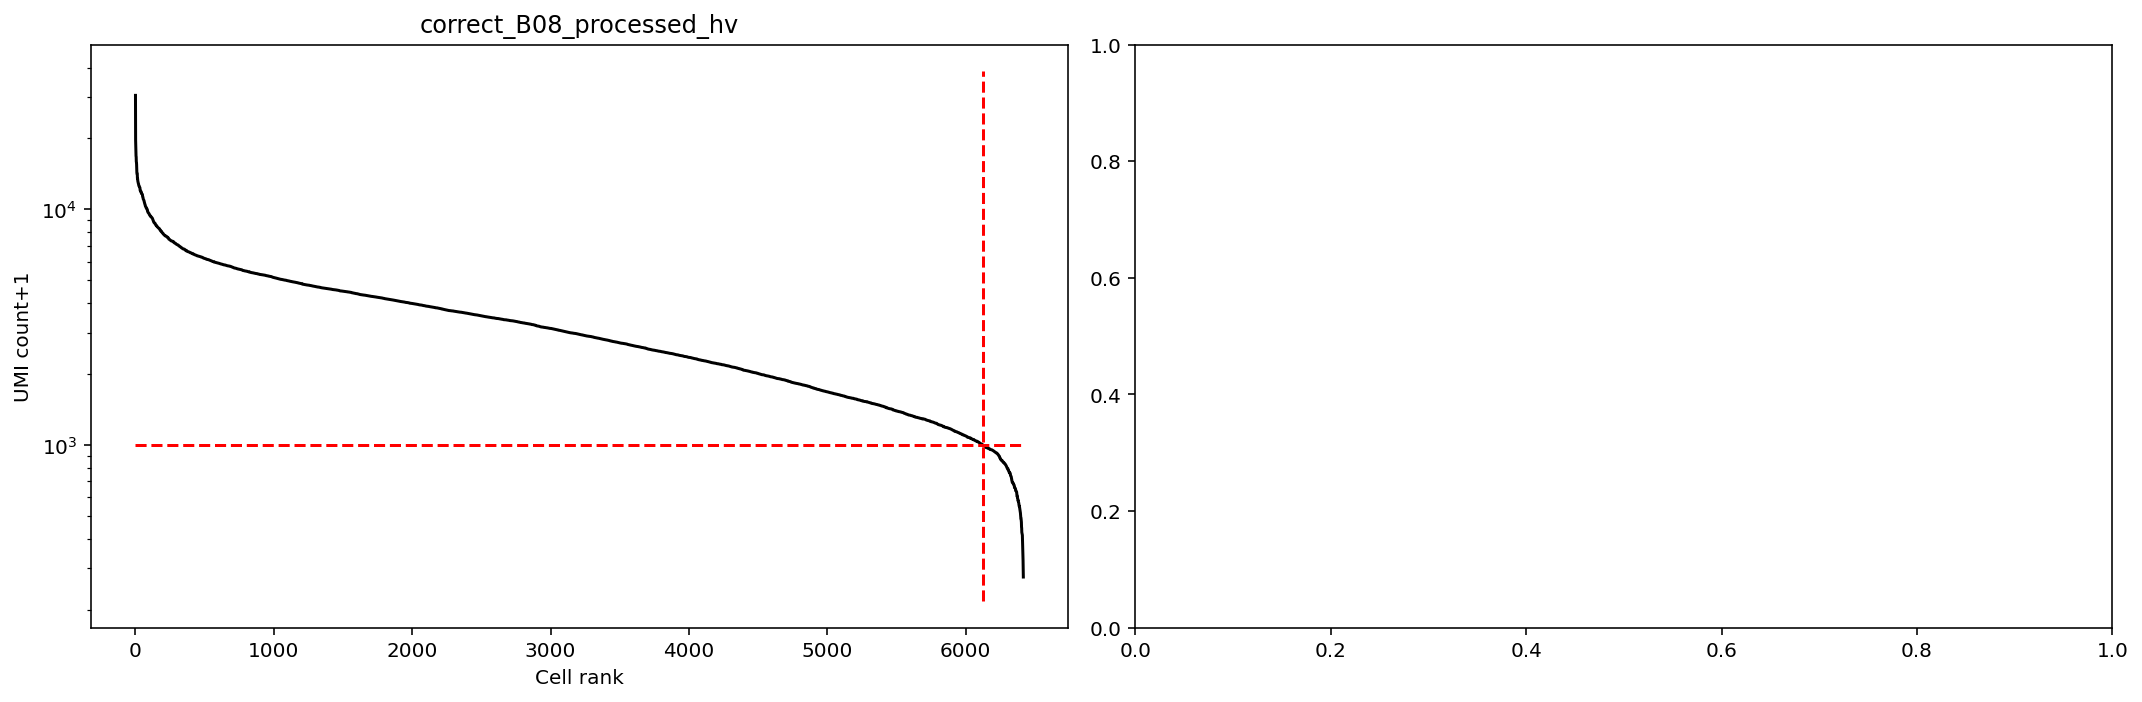

In [15]:
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['cell_type'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_top_allenB08_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [16]:
all_assigns = [list(meta['cell_type'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

660


In [17]:
all_assigns2 = [list(meta['cell_type'][meta['cell_barcode'] == i])[0] for i in bcs[cf[4]]]
print(len(all_assigns2))

2342


In [18]:
assigns = [all_assigns]*num_ks + [all_assigns2]*num_ks

## **Gene Filtering**

In [19]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [23]:
# !mkdir ./fits


INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1 created.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:660 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:385 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1 created.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:660 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:385 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3 created.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:660 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 

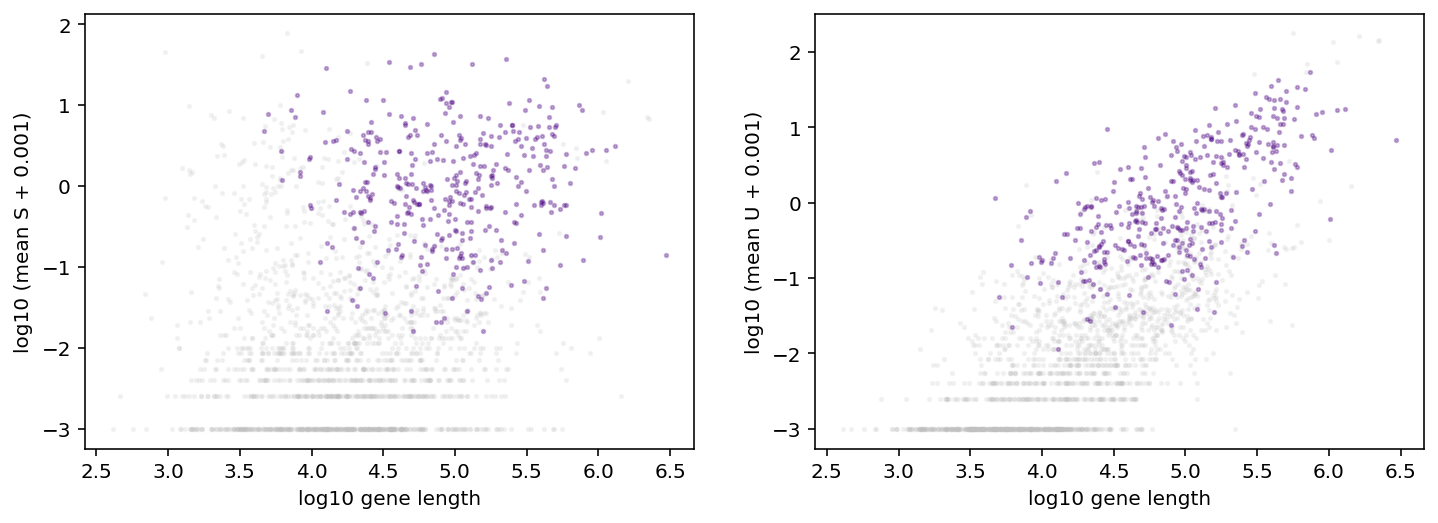

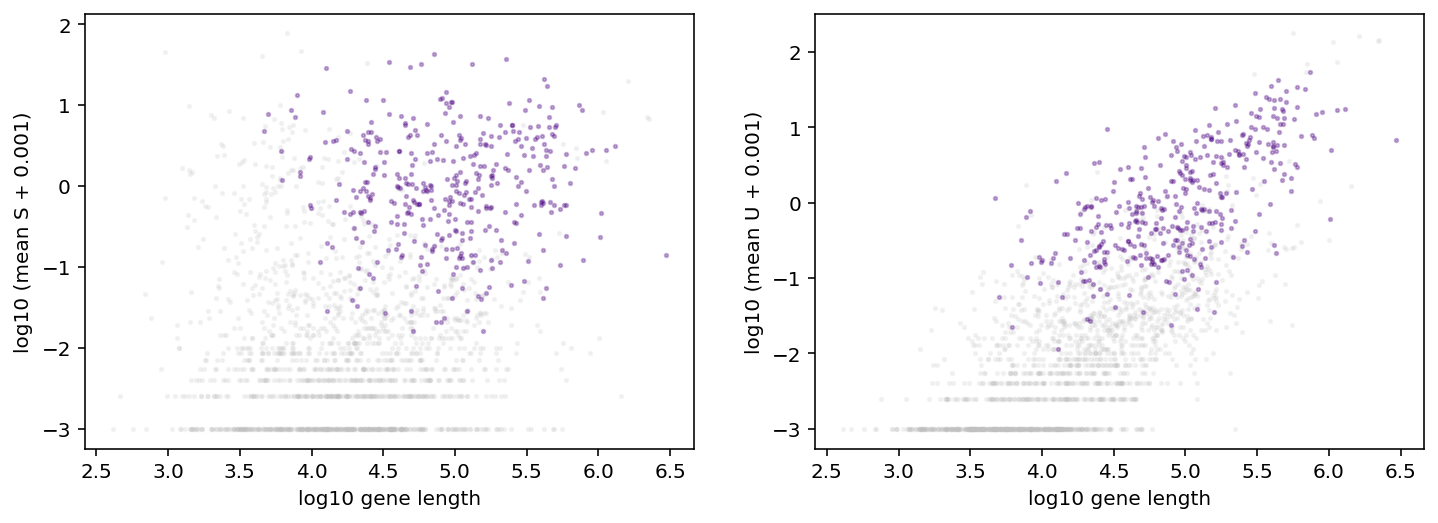

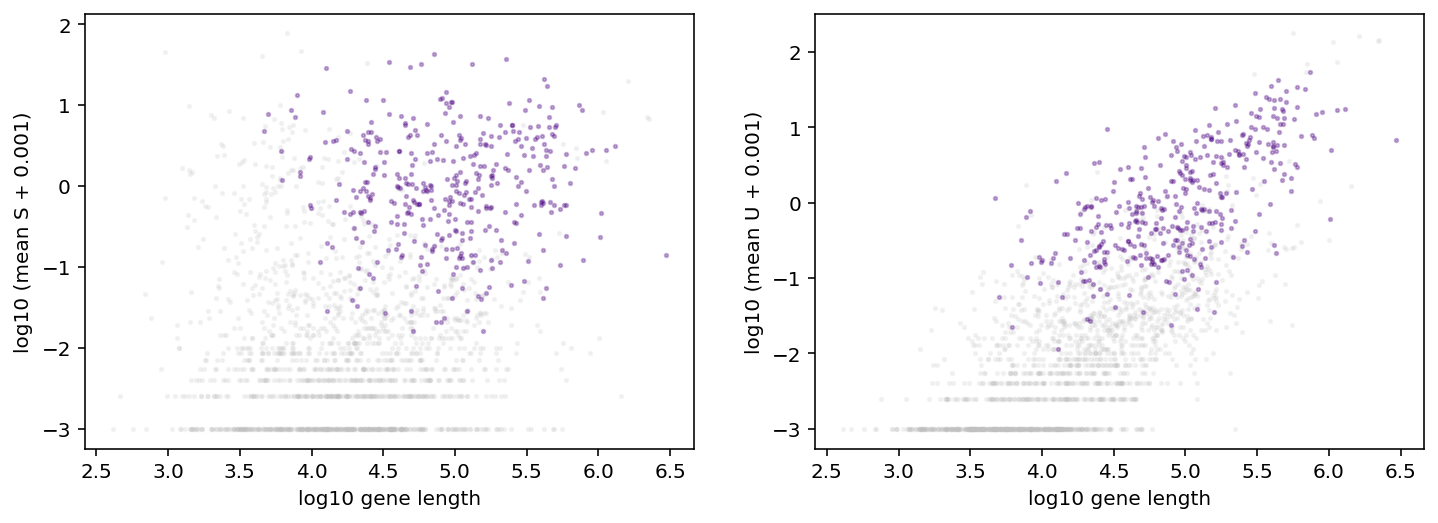

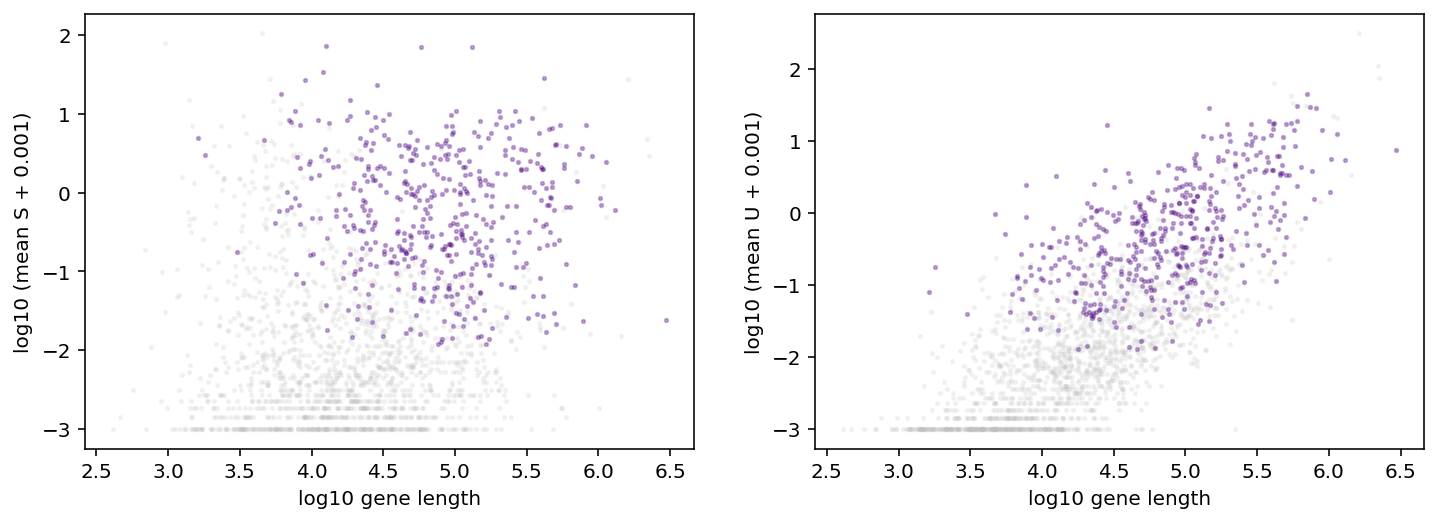

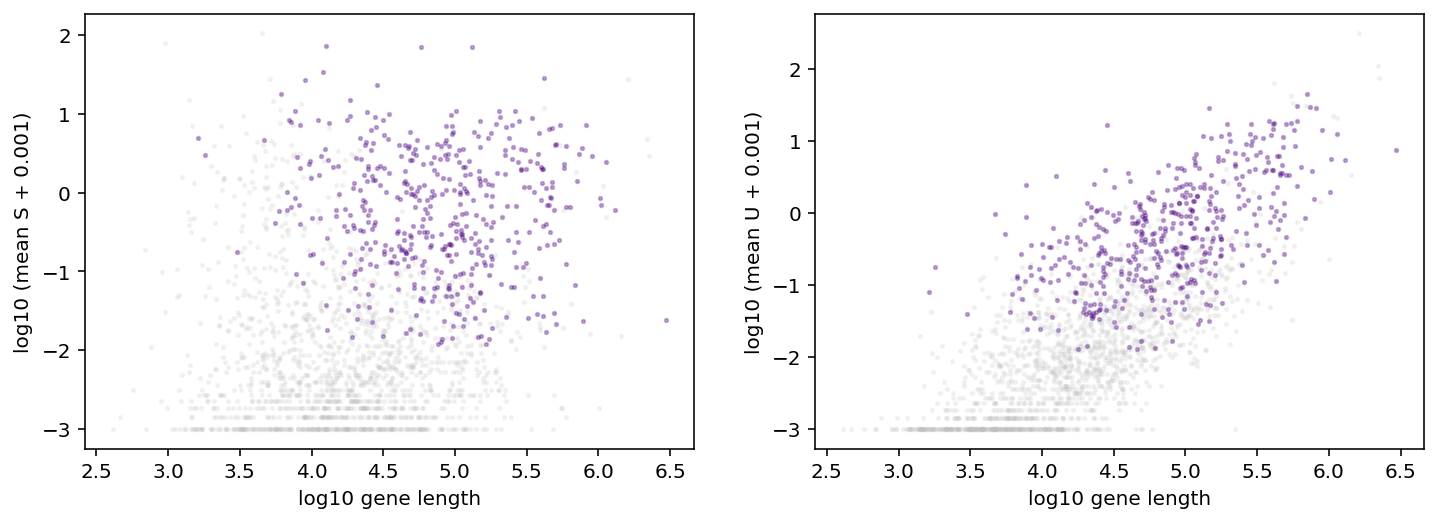

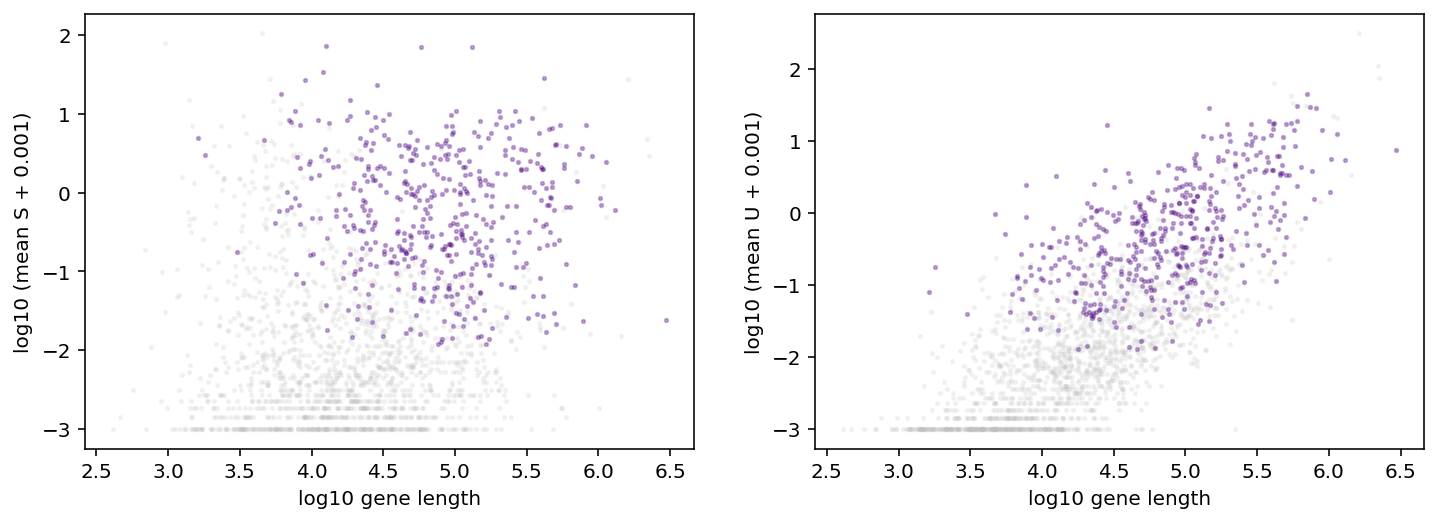

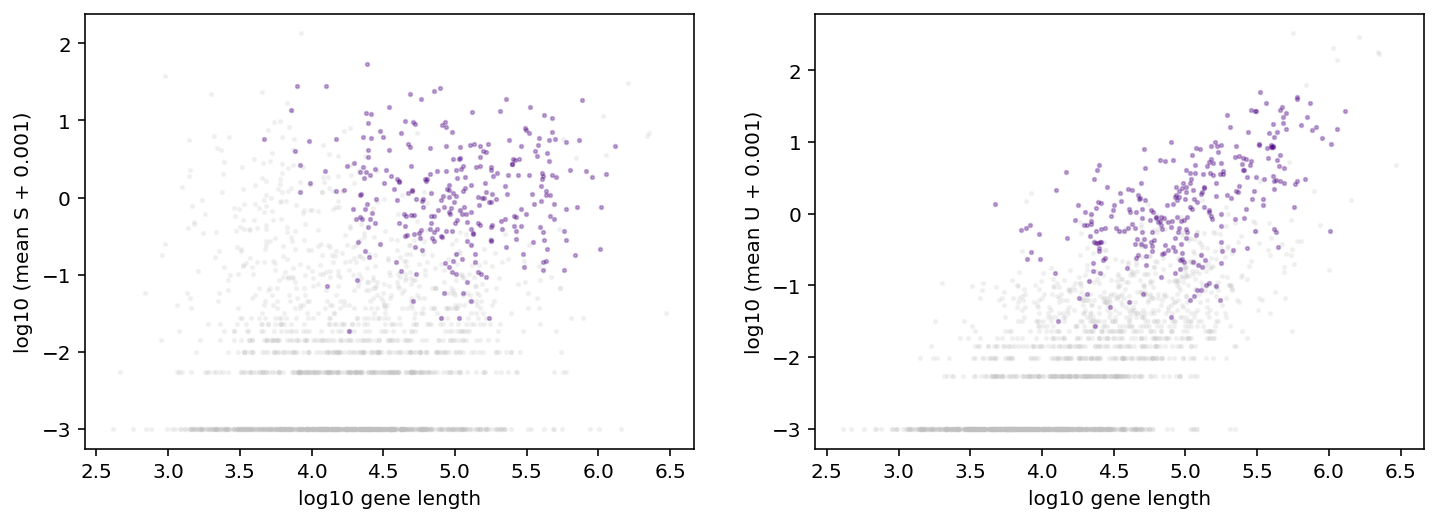

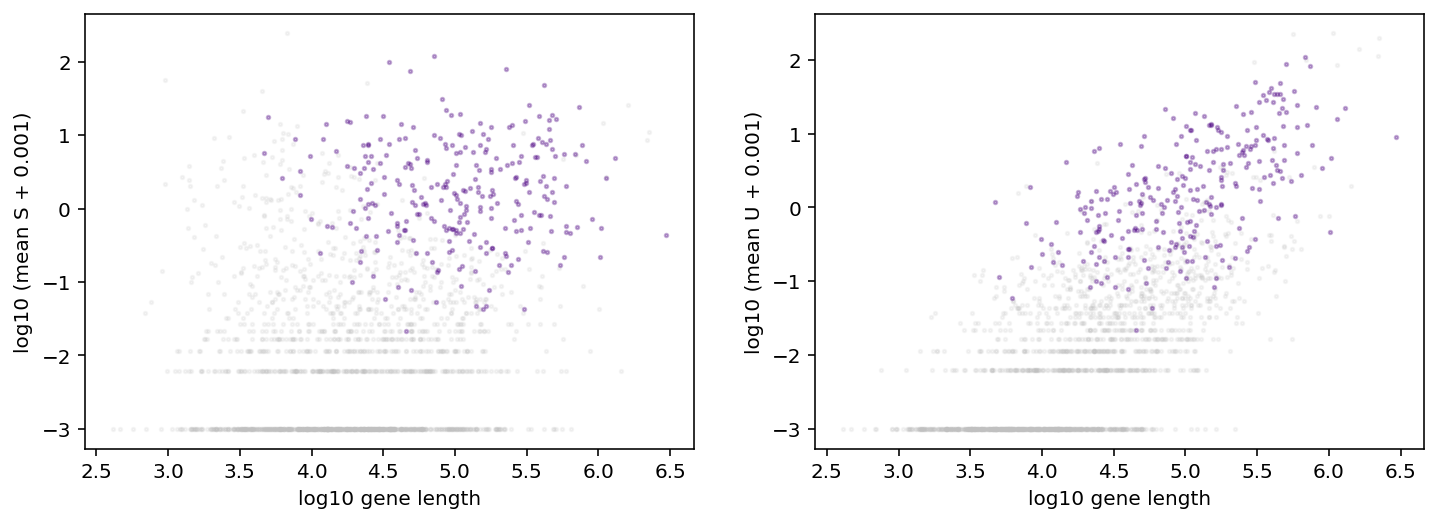

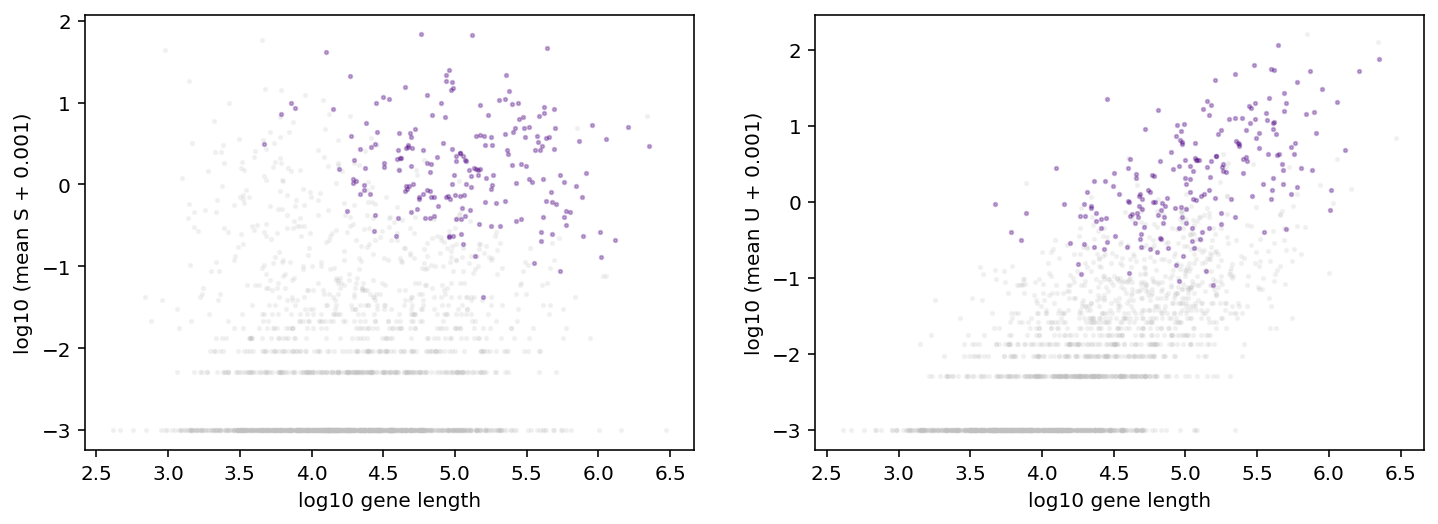

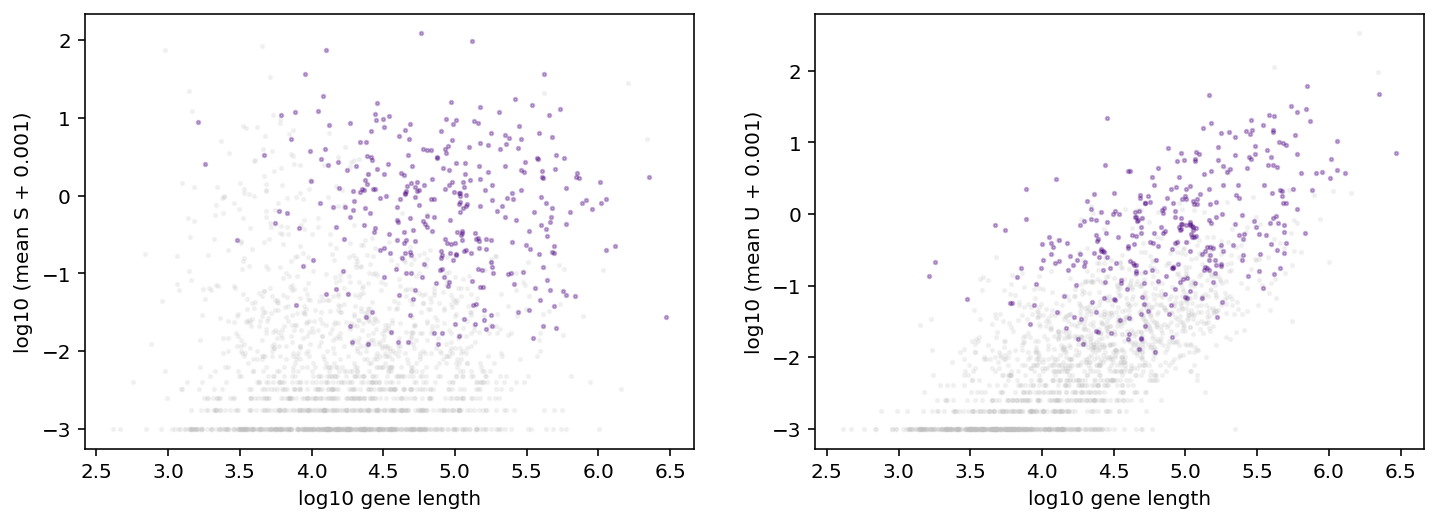

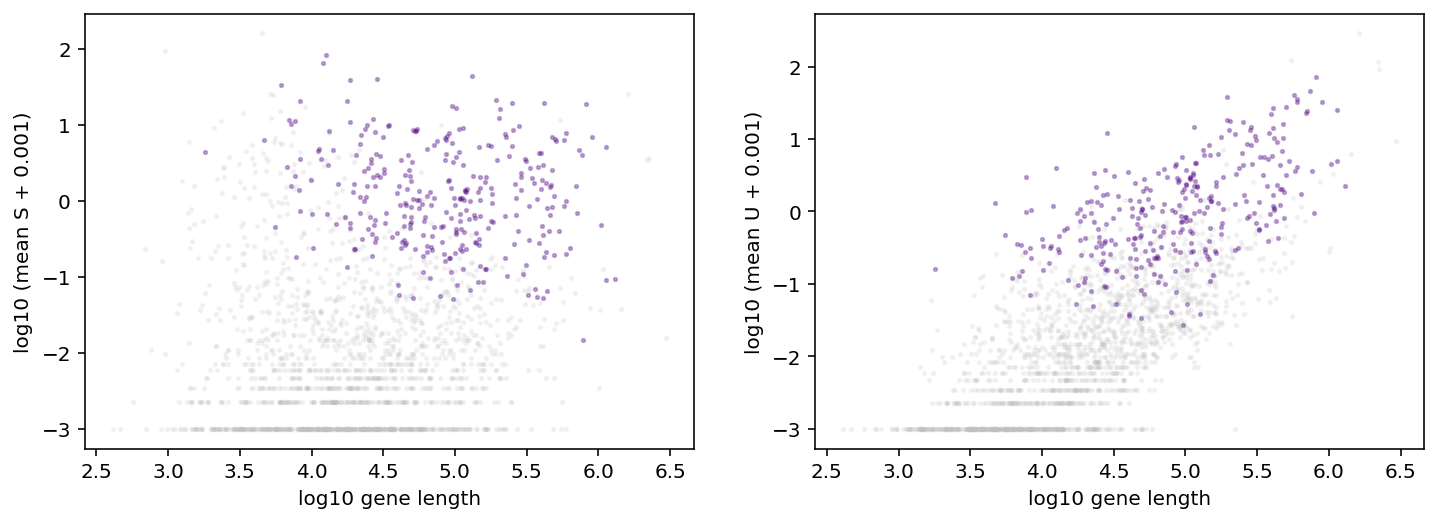

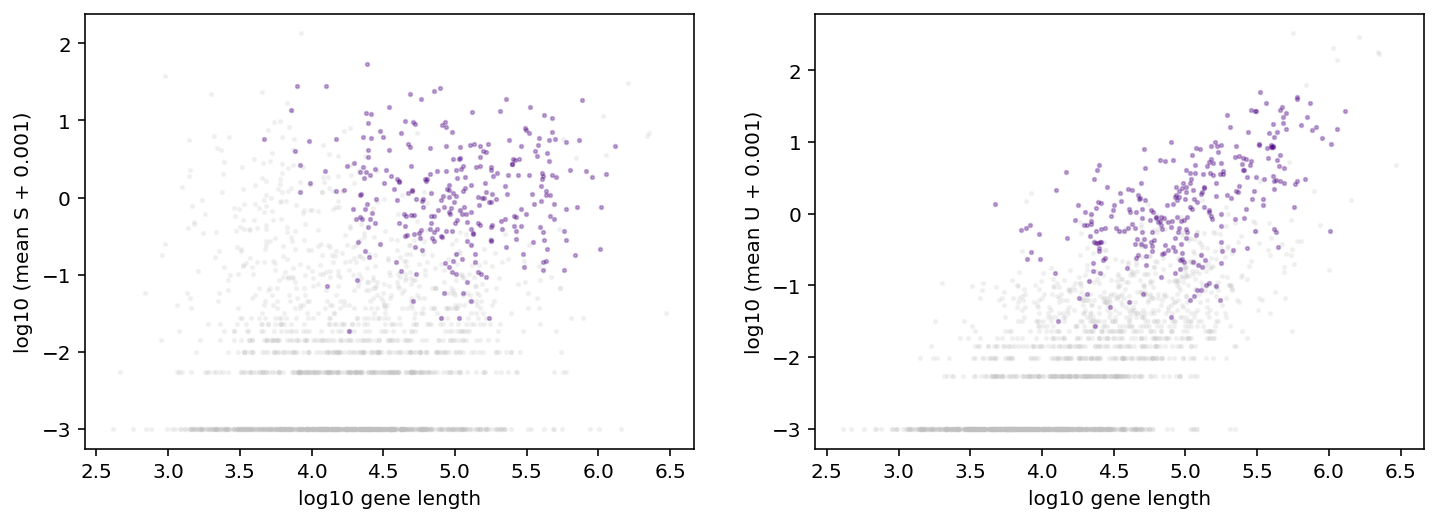

In [24]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_B08_MM',batch_id=1,\
                                             datestring='230423', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf) 

In [20]:
dir_string = './fits/gg_230423_025_allen_B08_MM_1'
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k1', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k3', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k5', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT', './fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip

Check k-means inits

In [21]:
all_group_kmeans = []

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
(660, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3/raw.sd.
(660, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1

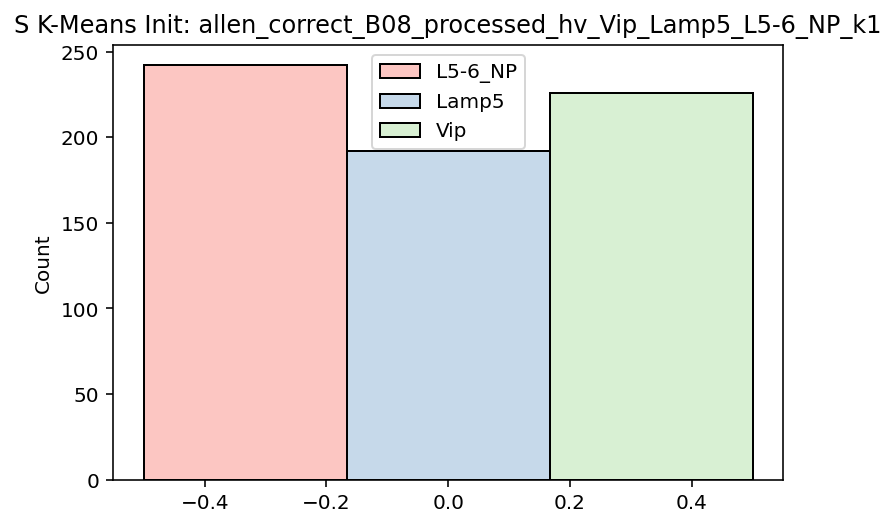

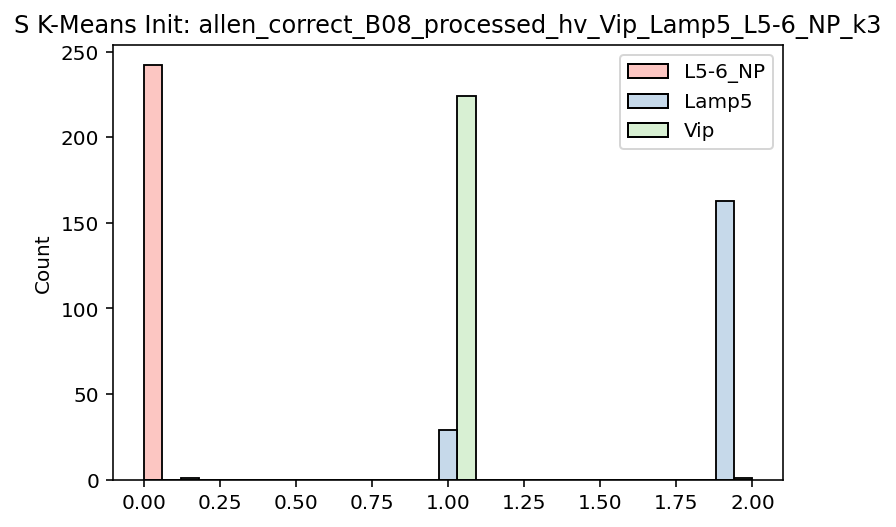

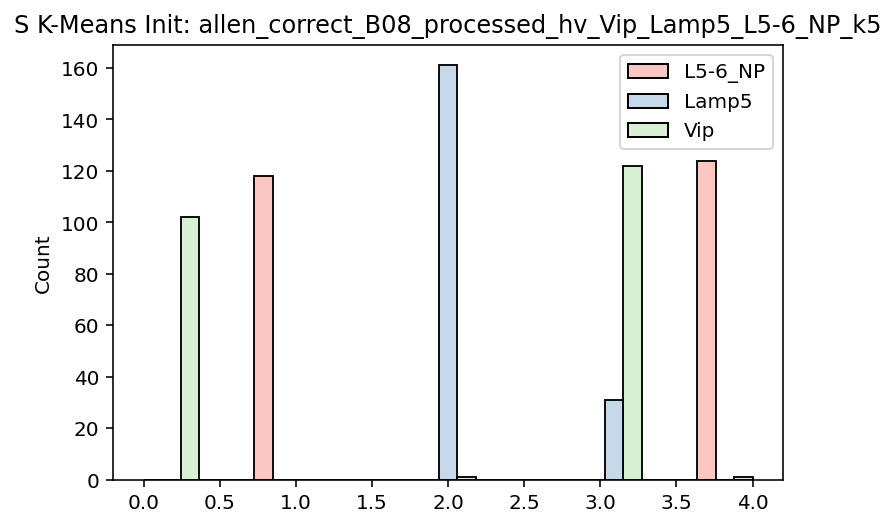

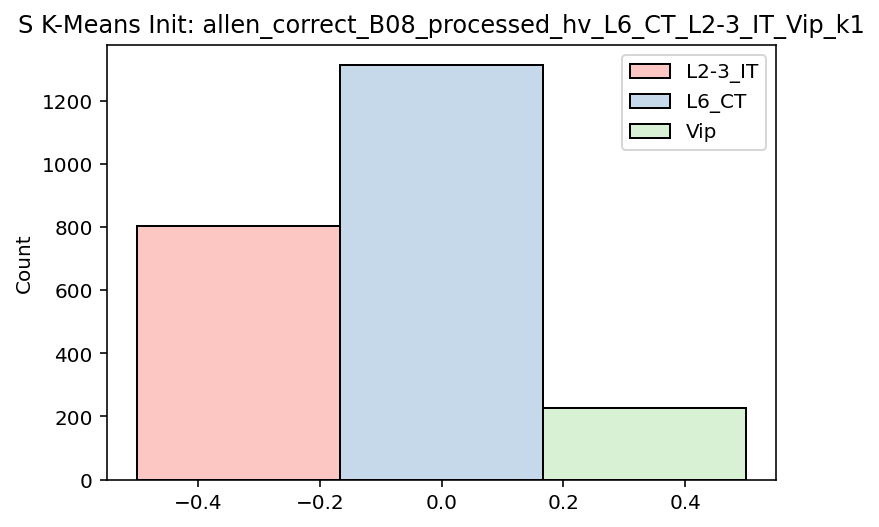

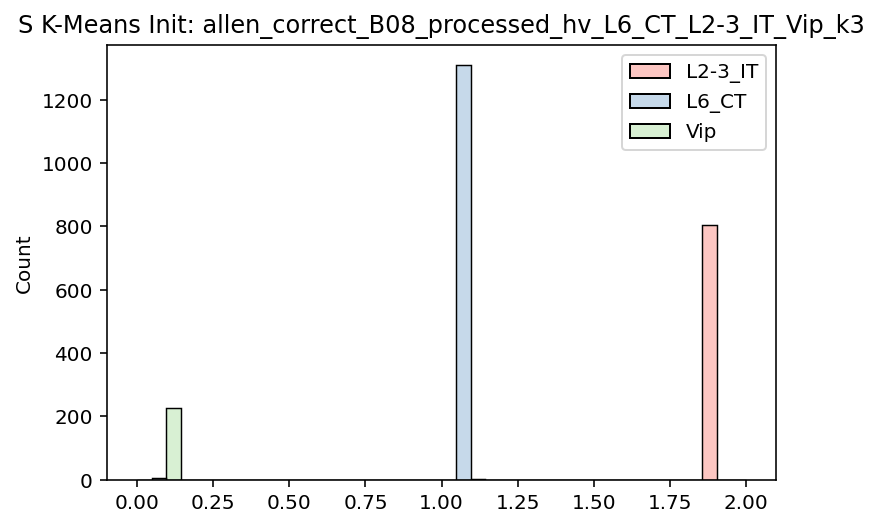

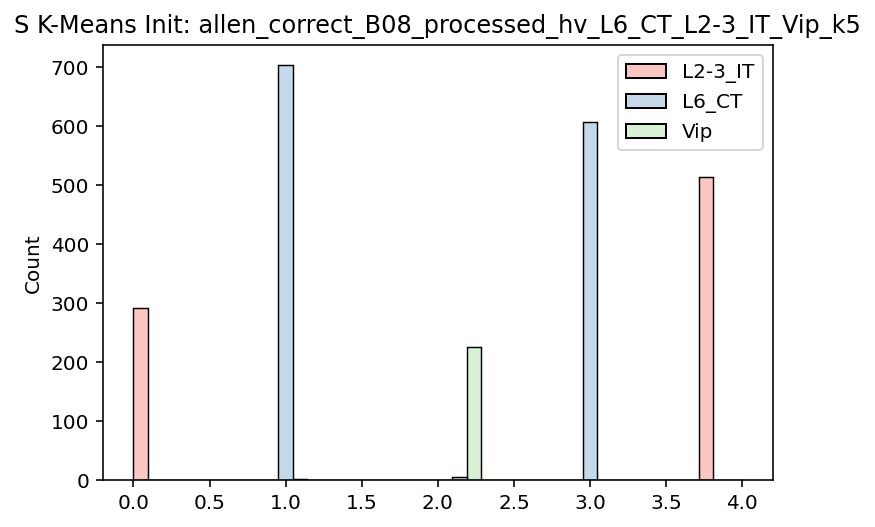

In [22]:
#For easier demonstration
#Check initializations of clusters
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which%num_ks], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_group_kmeans += [labs]
    
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('S K-Means Init: '+dataset_names[which])




INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
(660, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3/raw.sd.
(660, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1

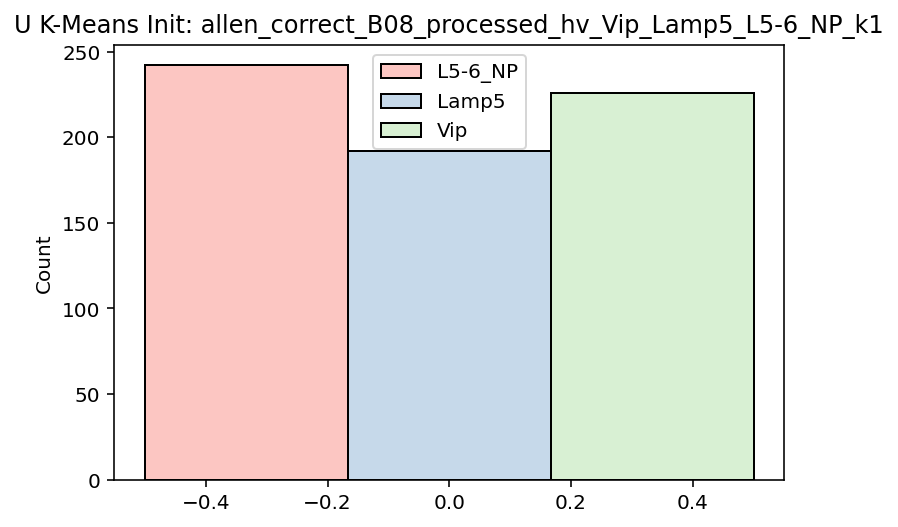

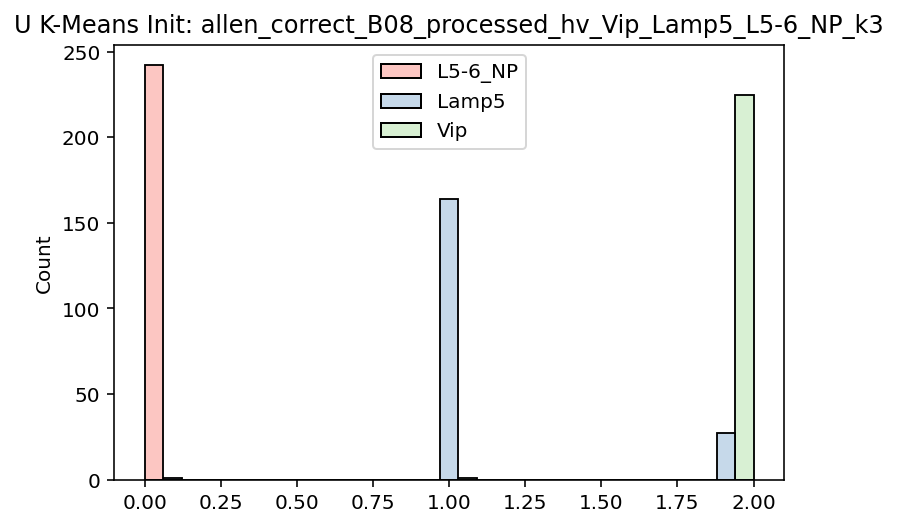

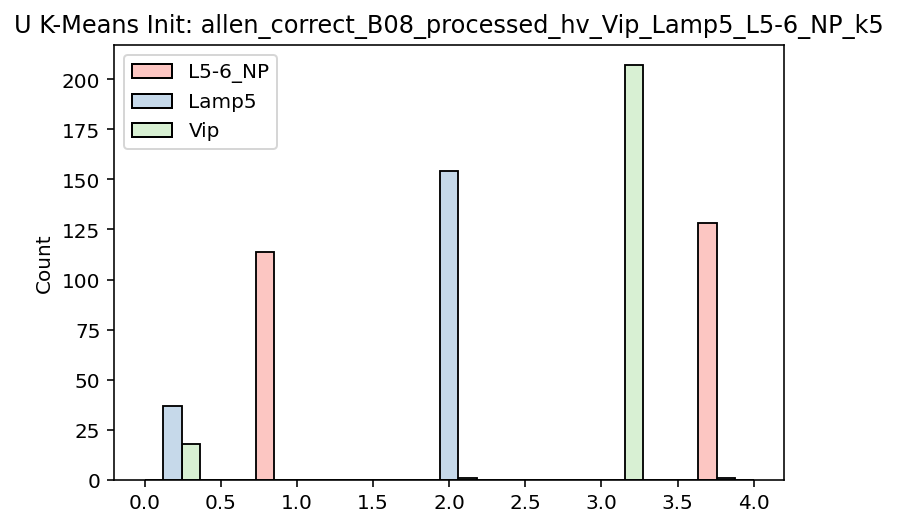

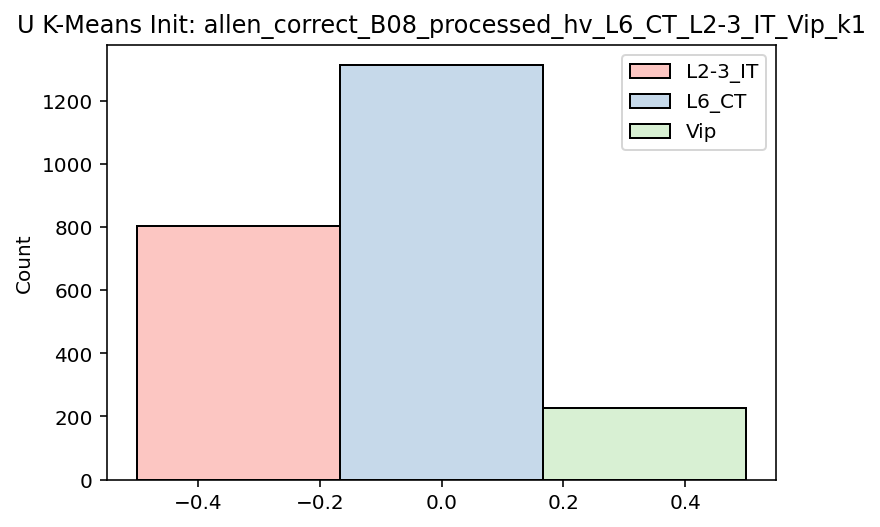

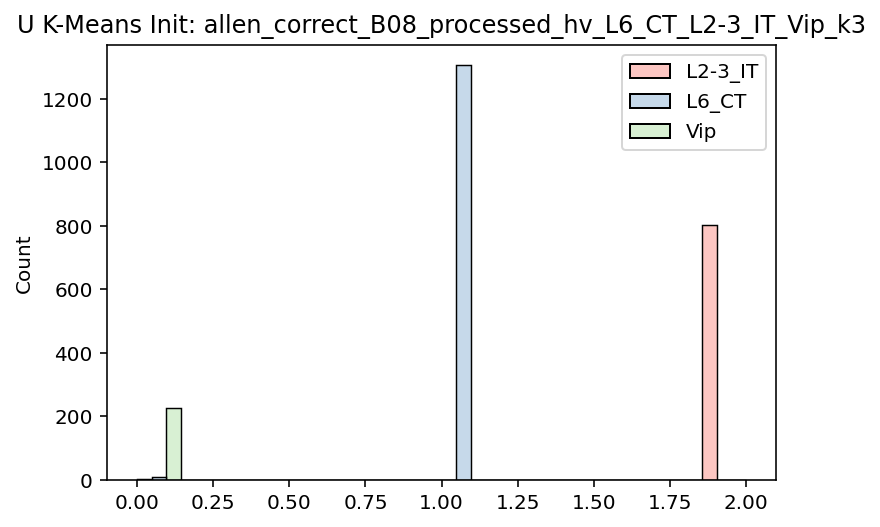

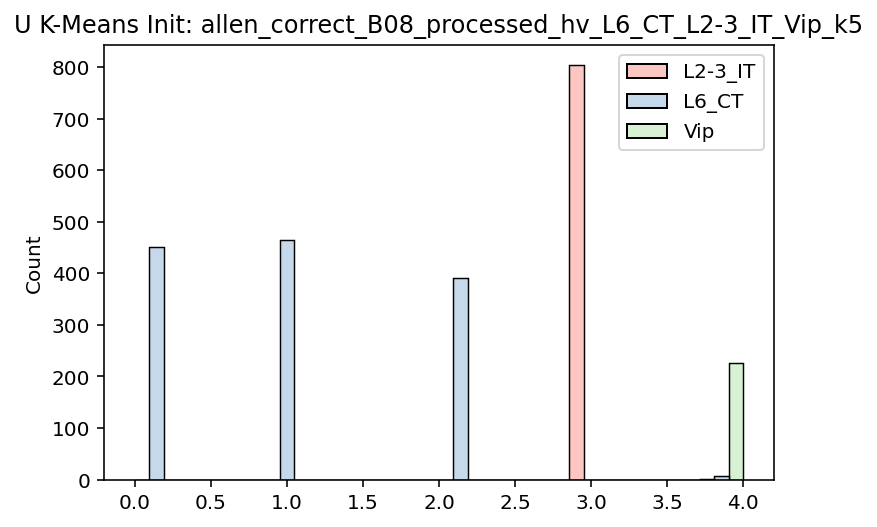

In [23]:
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which%num_ks], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_group_kmeans += [labs]
    
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('U K-Means Init: '+dataset_names[which])


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:ro

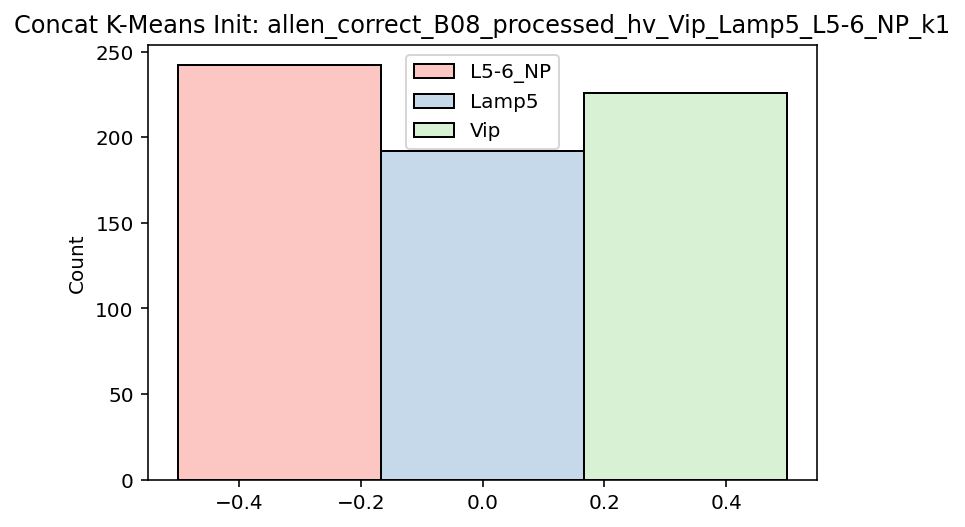

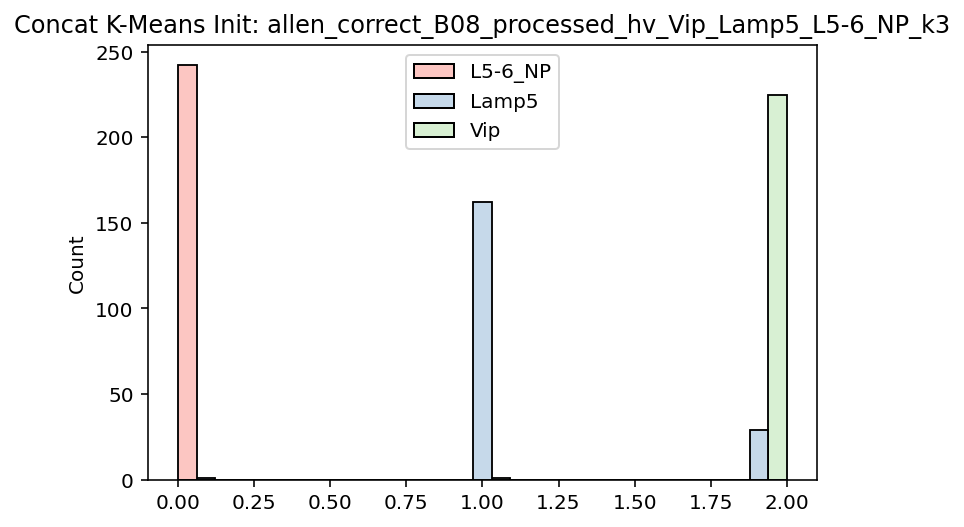

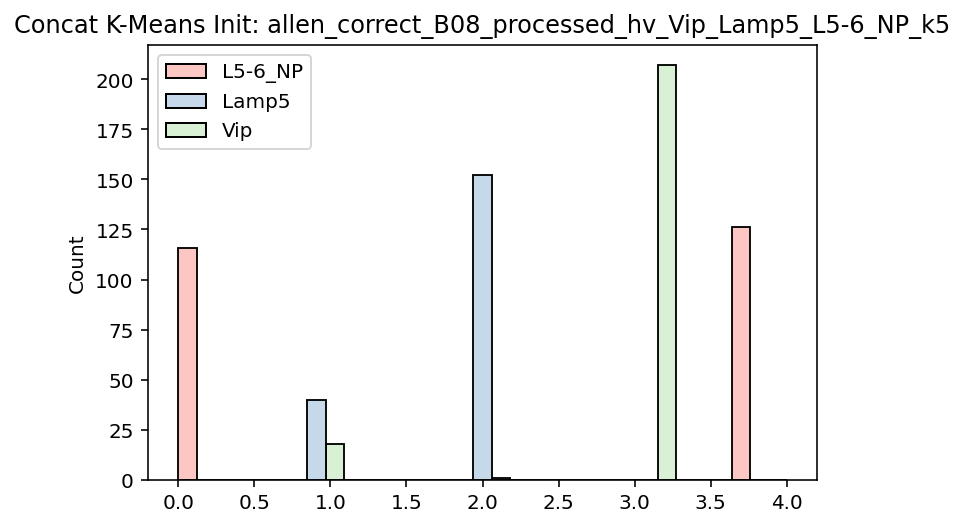

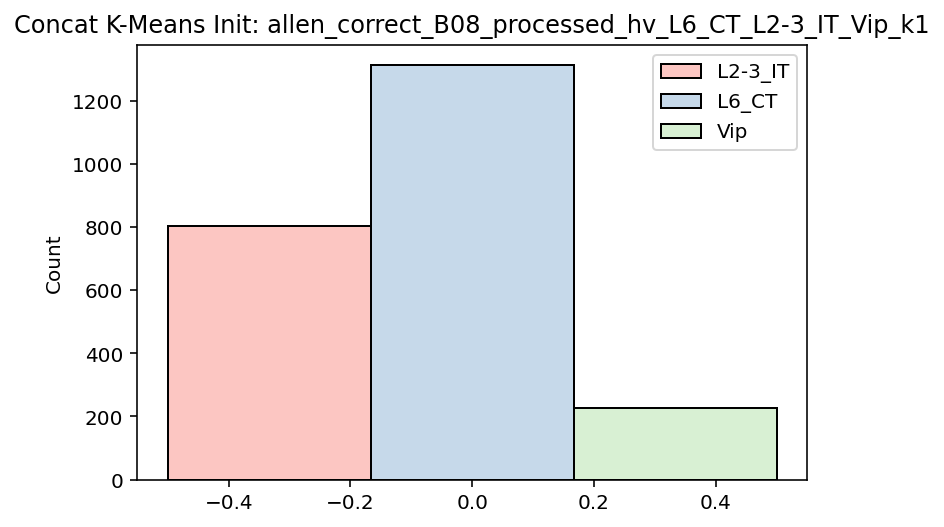

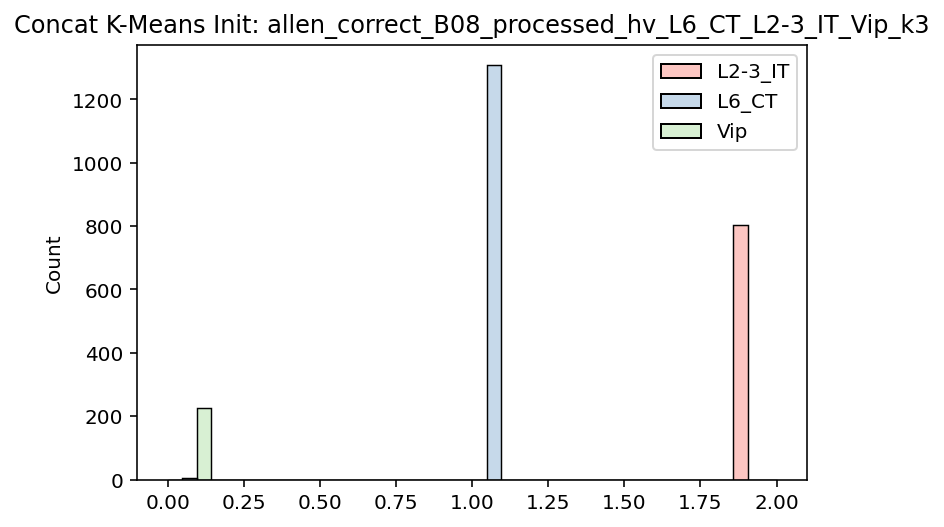

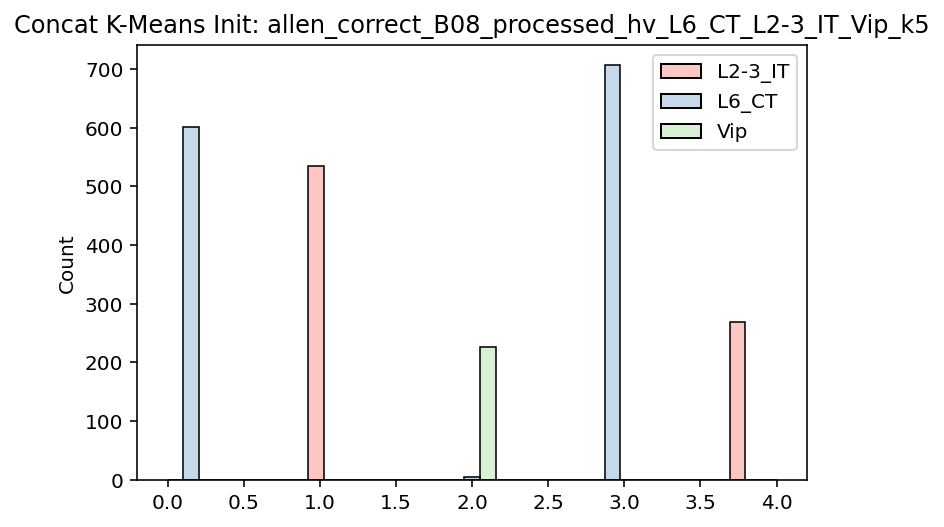

In [24]:
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[which%num_ks], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_group_kmeans += [labs]
    
    plt.figure()
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('Concat K-Means Init: '+dataset_names[i])

    
    

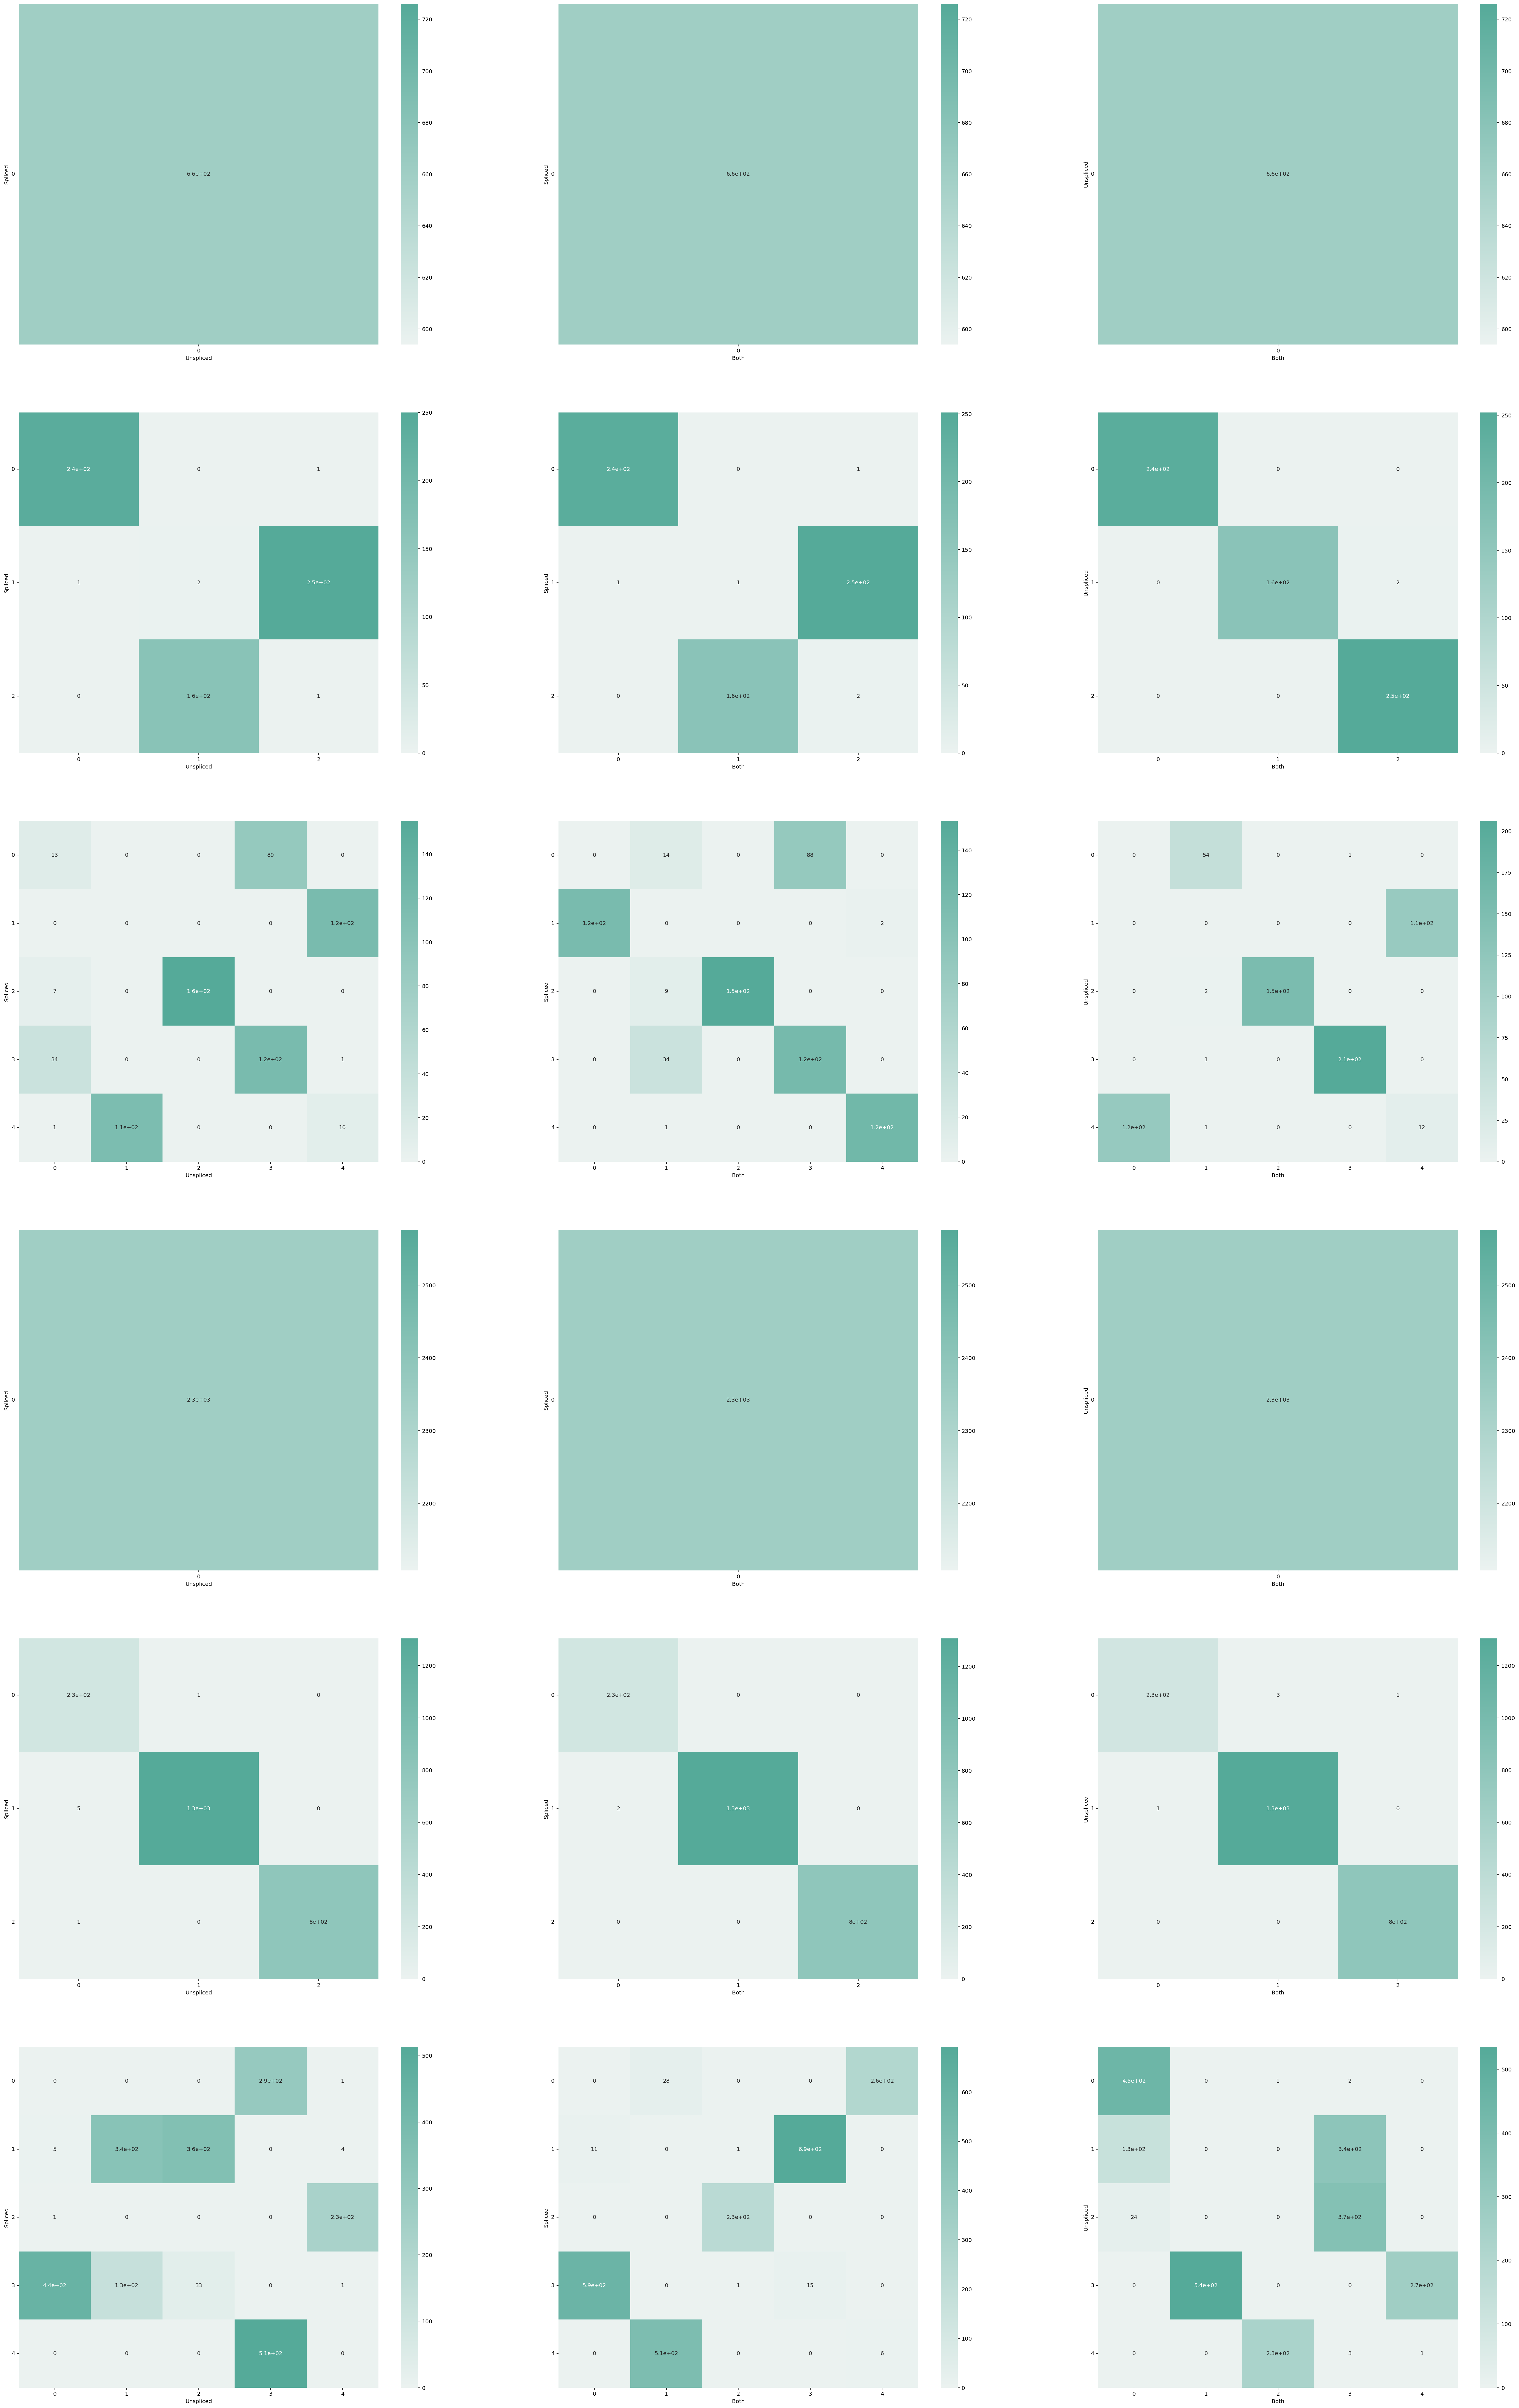

In [30]:
#compare overlap of all k-means assignments

num_per_set = len(chosen)*num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,80))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_group_kmeans[p[1]*(num_per_set)+i]
        true = all_group_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

Show leiden clusters

In [26]:
num_ks

3

In [31]:
neigh = 30
all_groups = []
res = [0.25,0.5,1.0]

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:ro

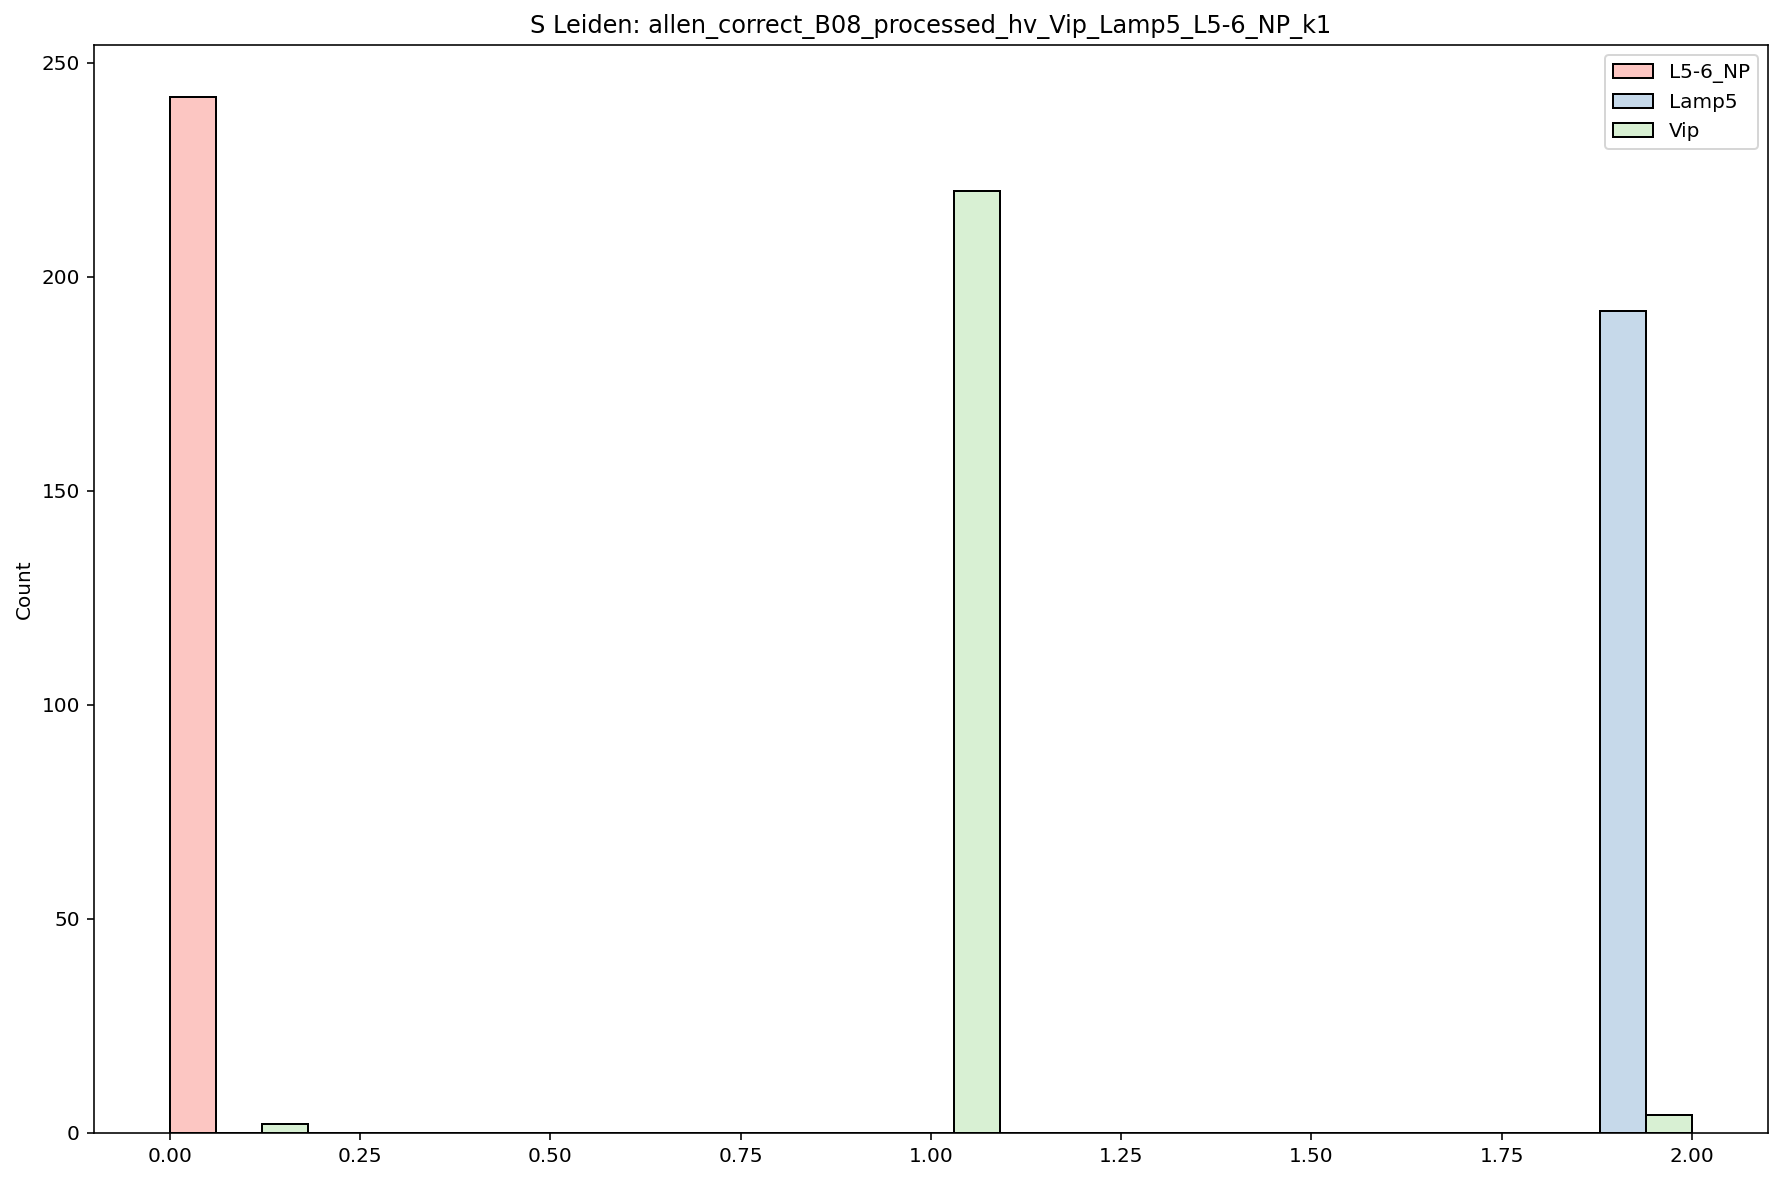

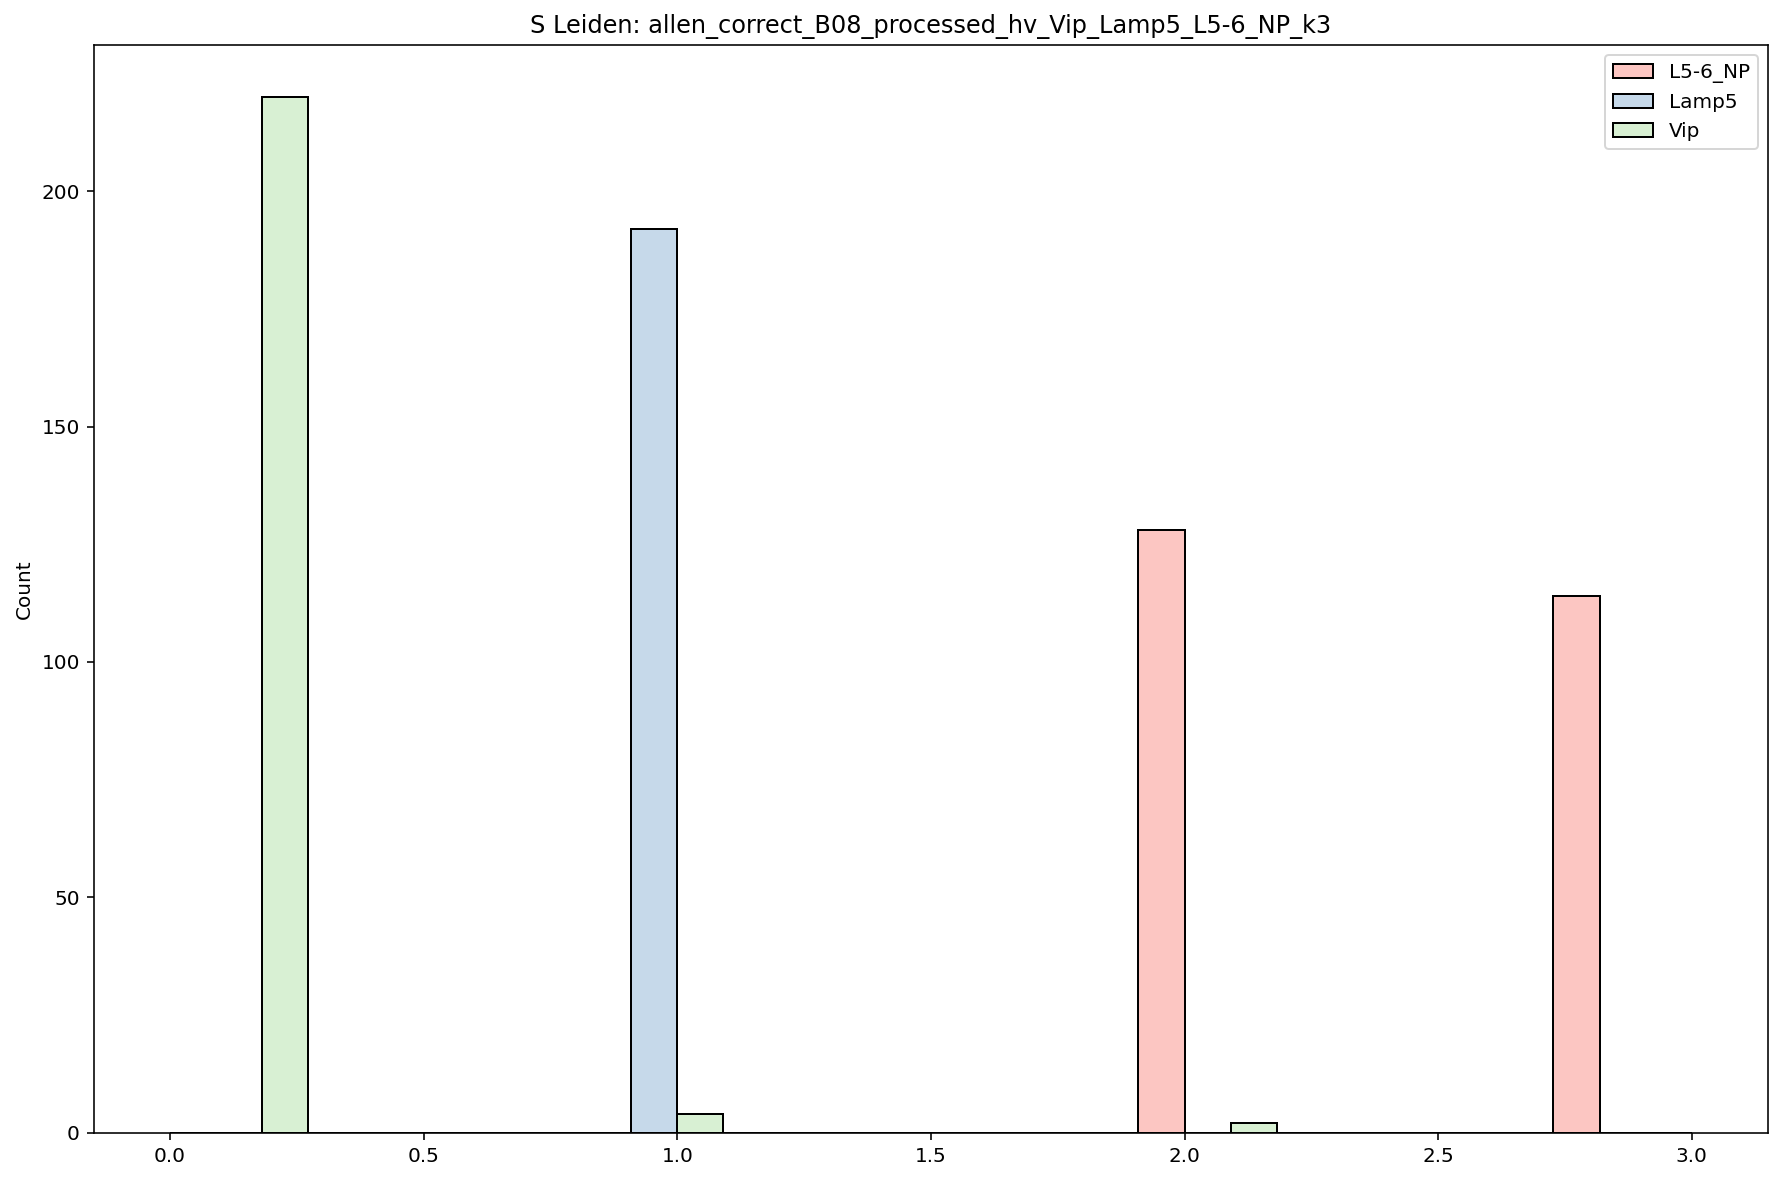

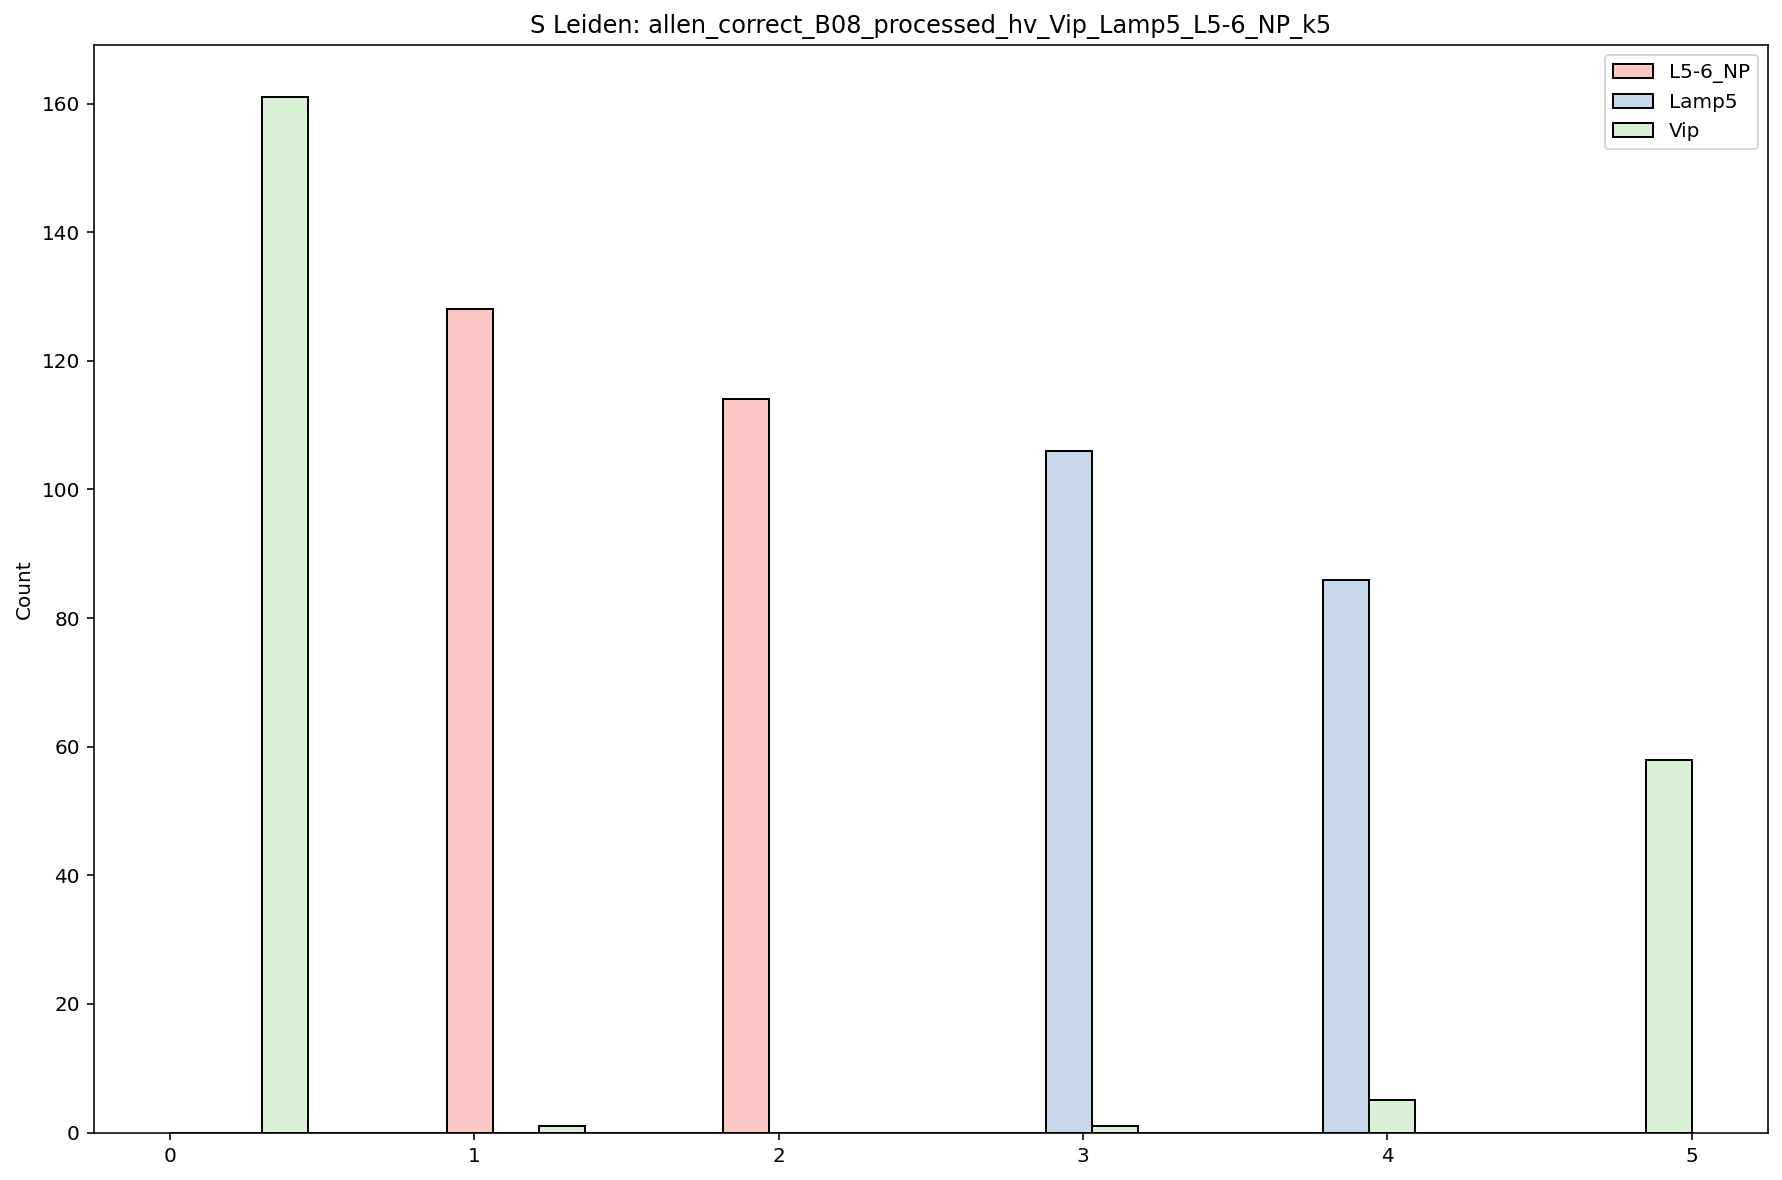

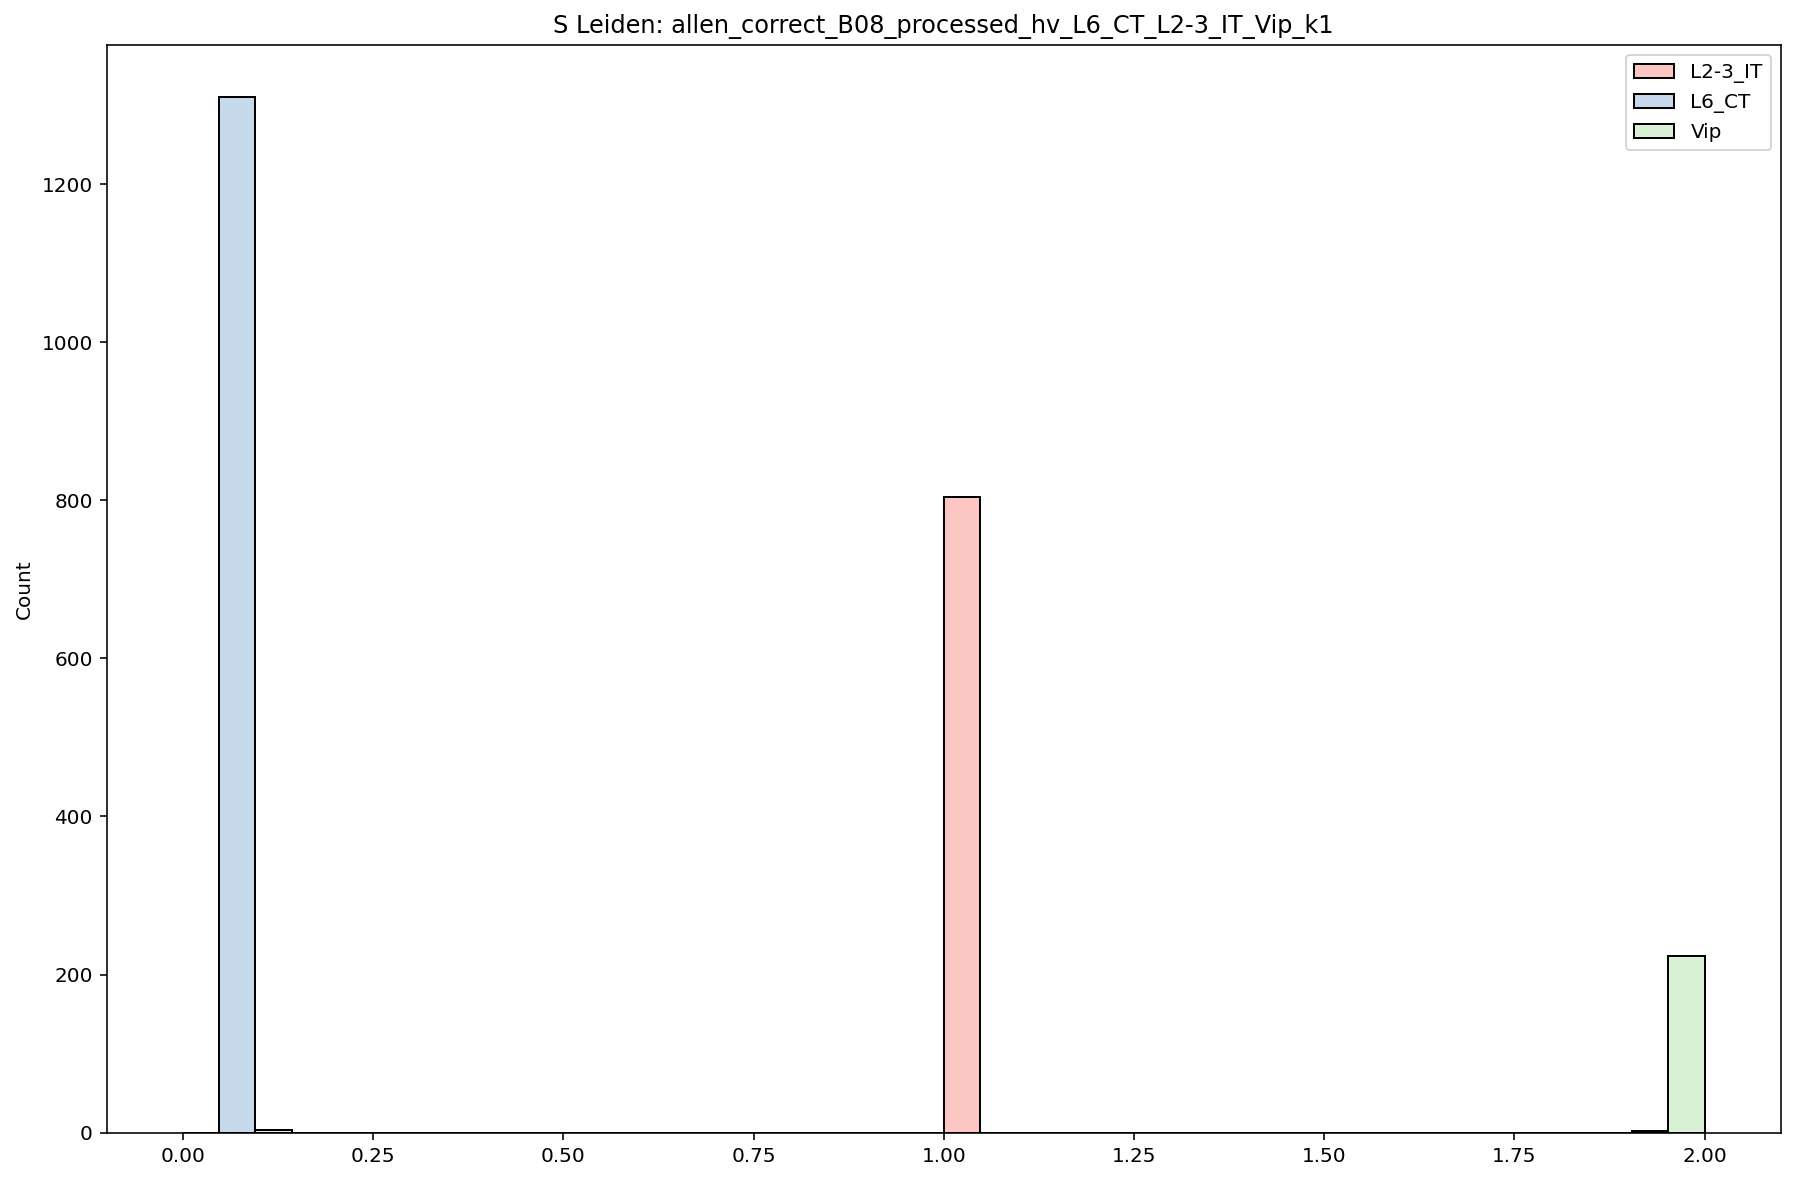

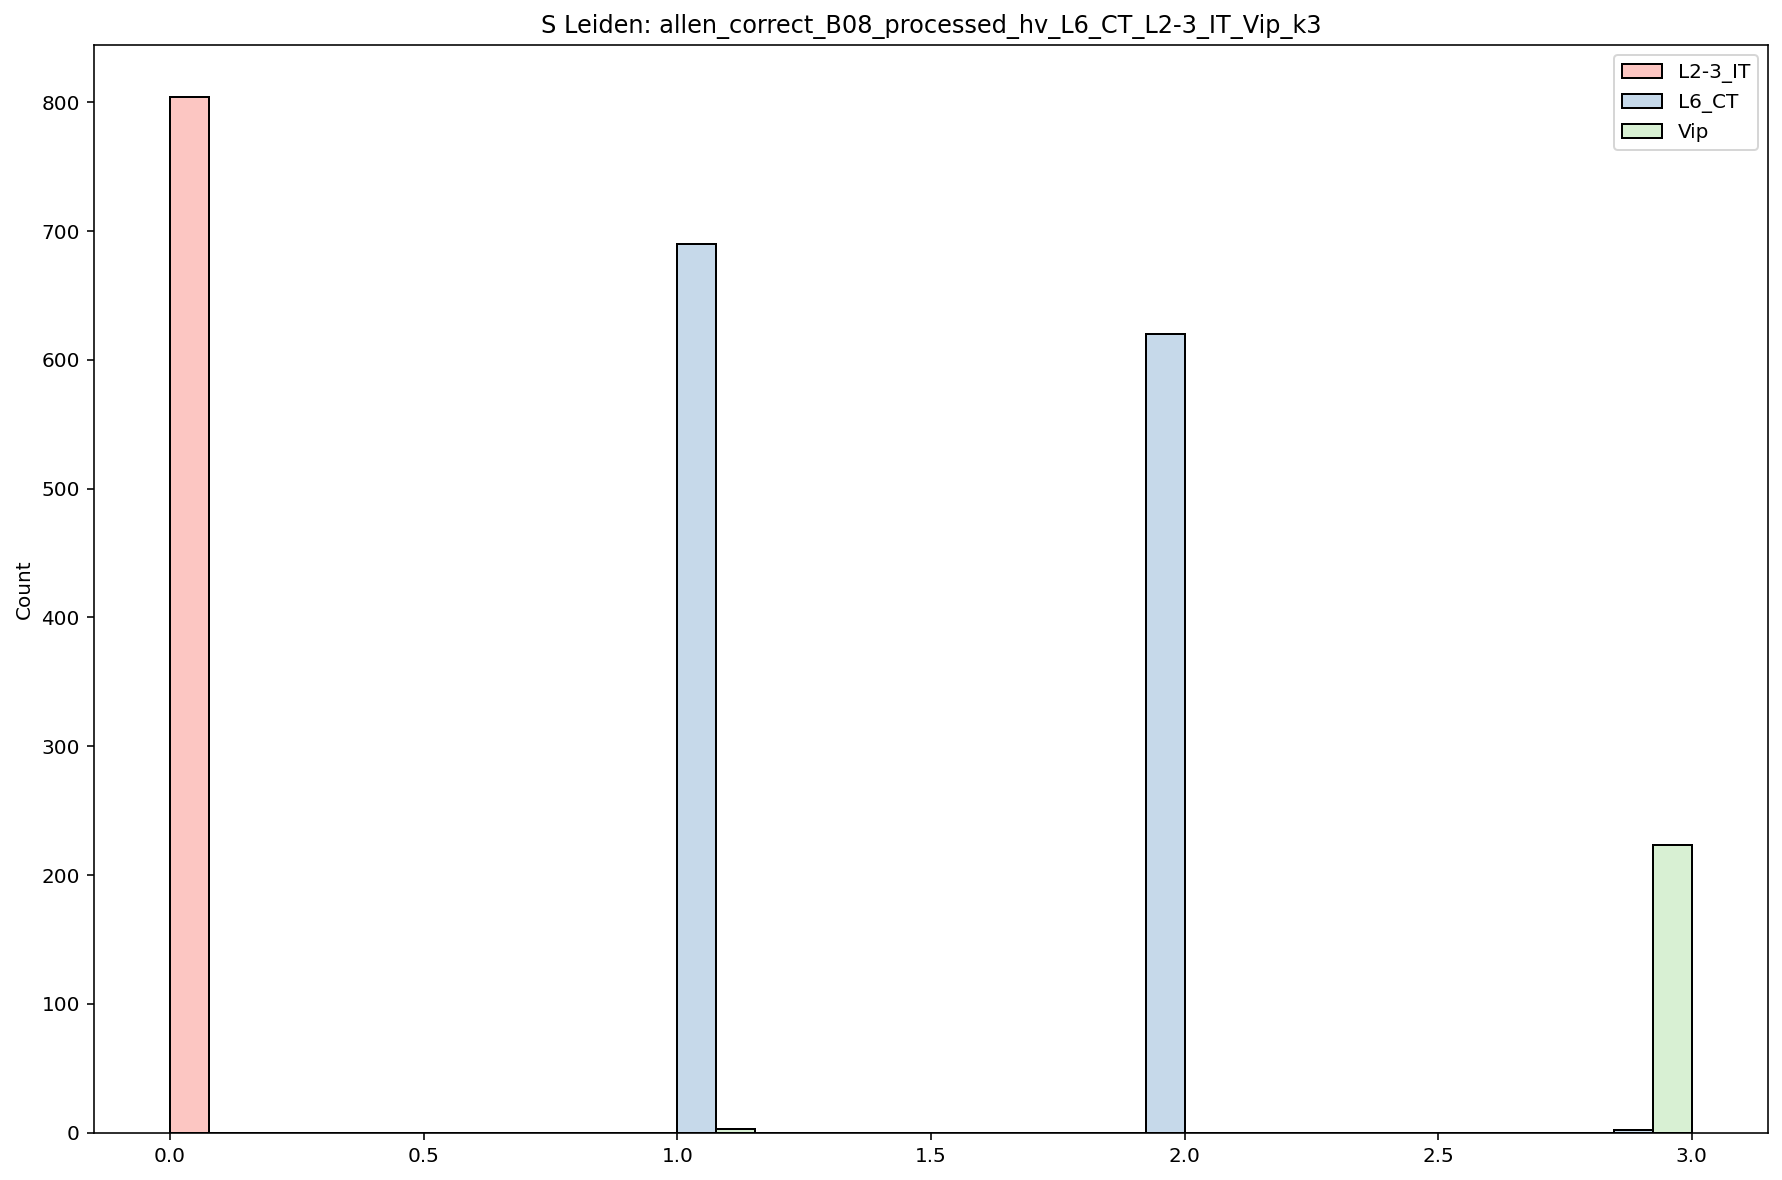

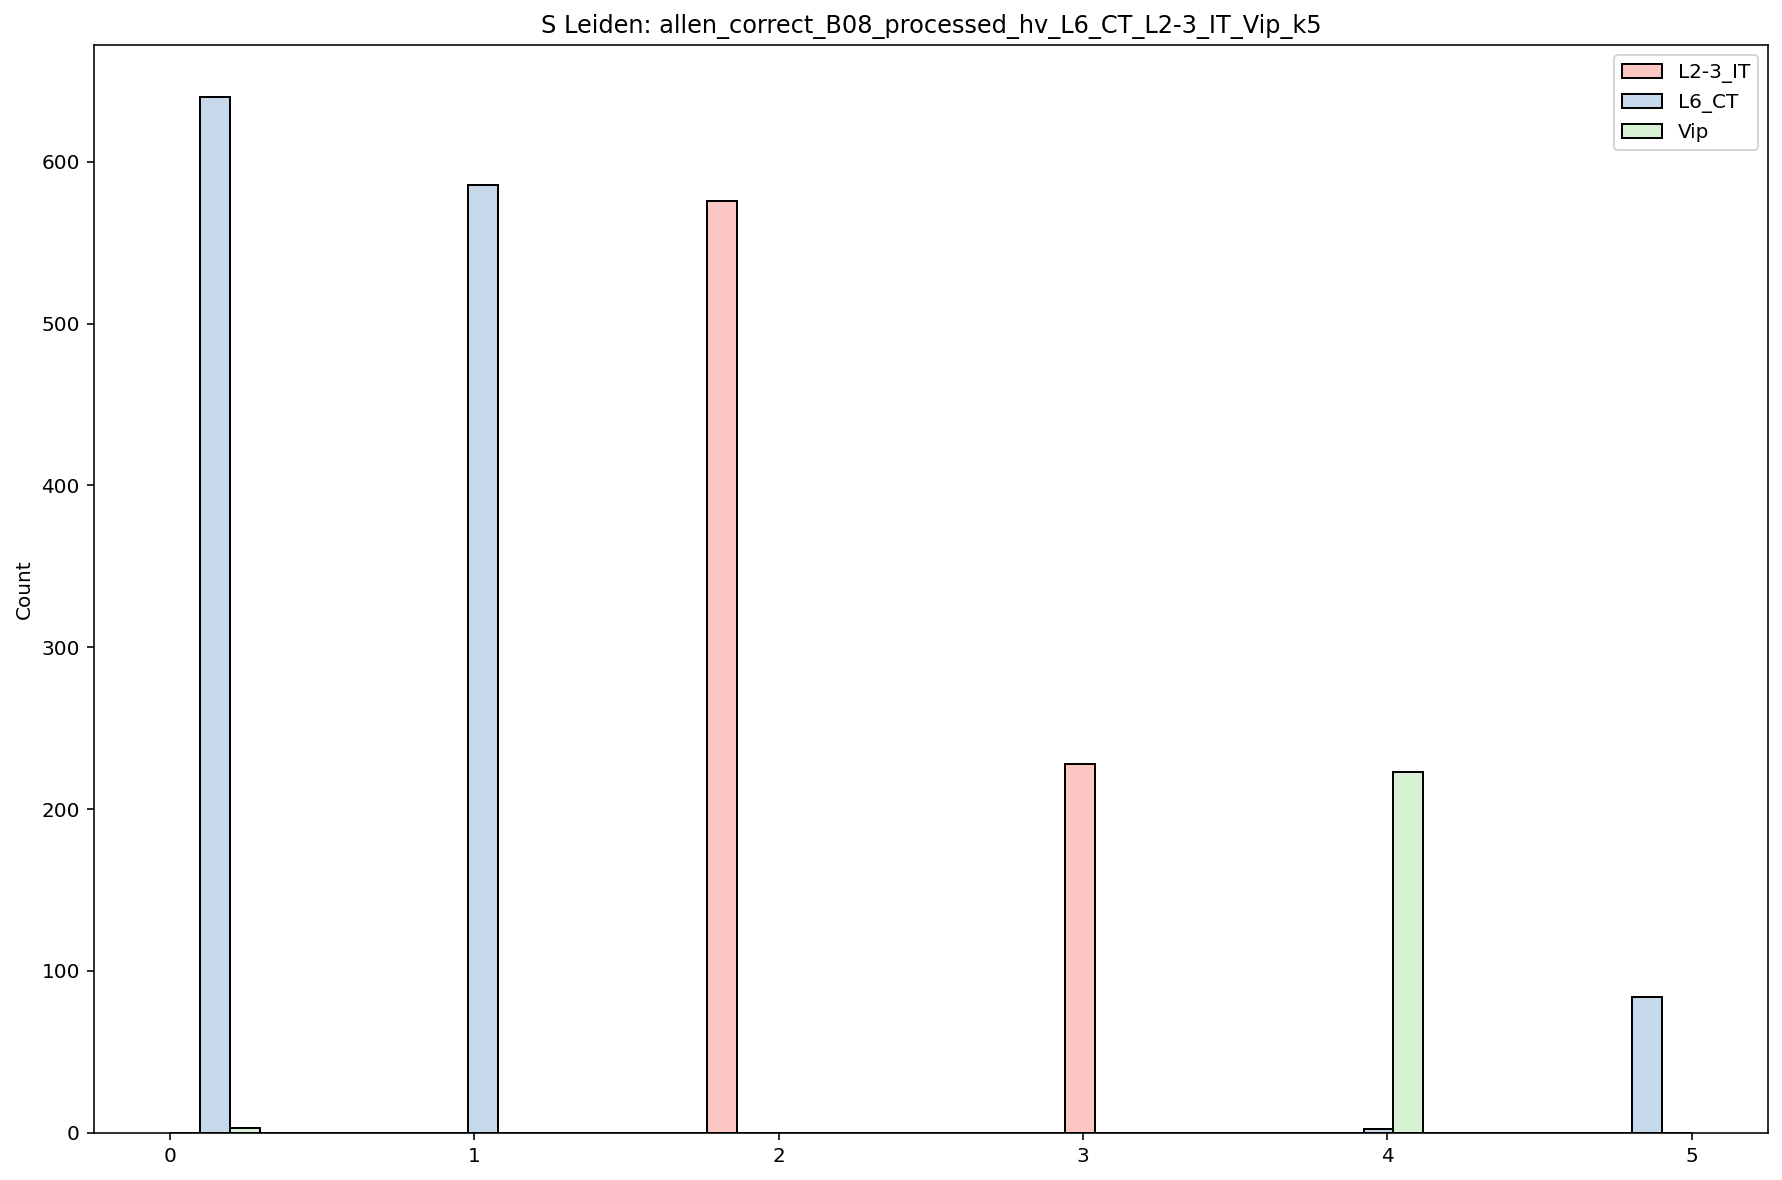

In [32]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('S Leiden: '+dataset_names[i])
    
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:ro

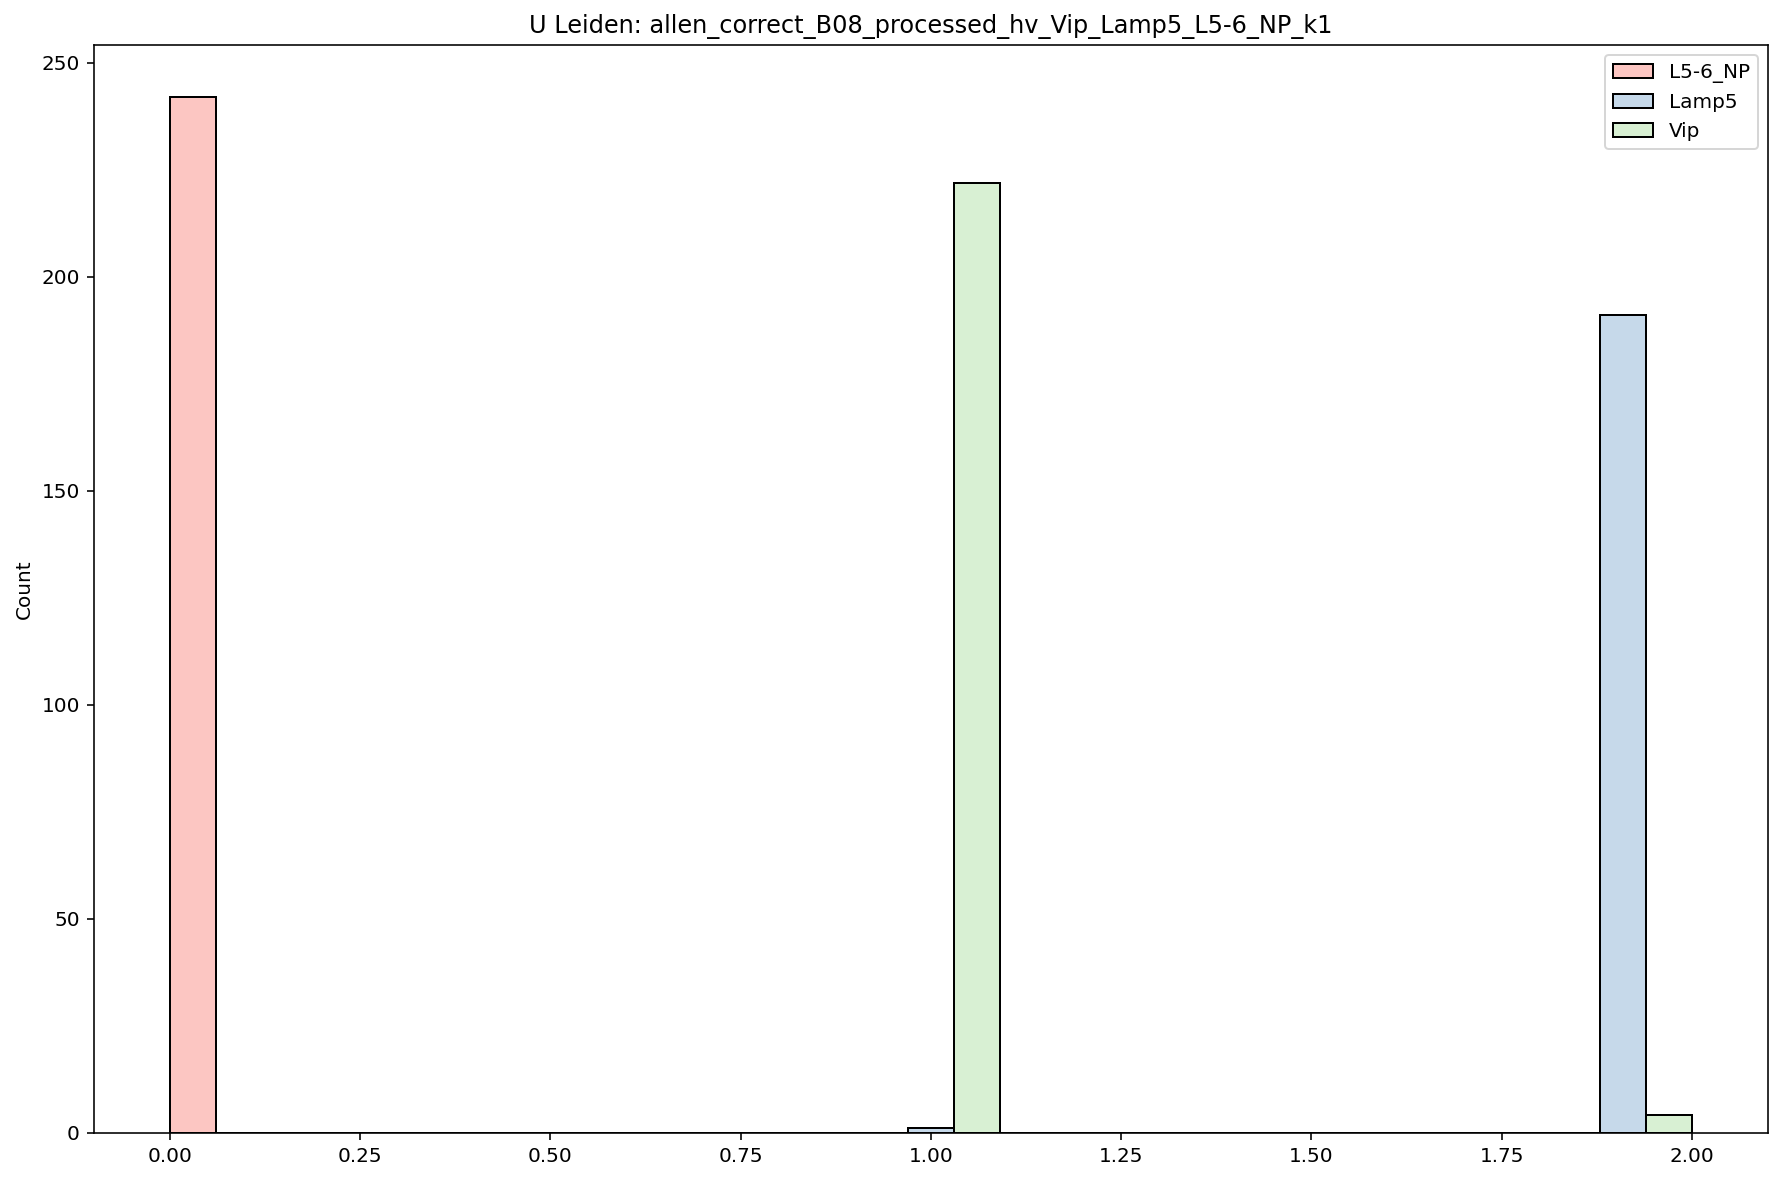

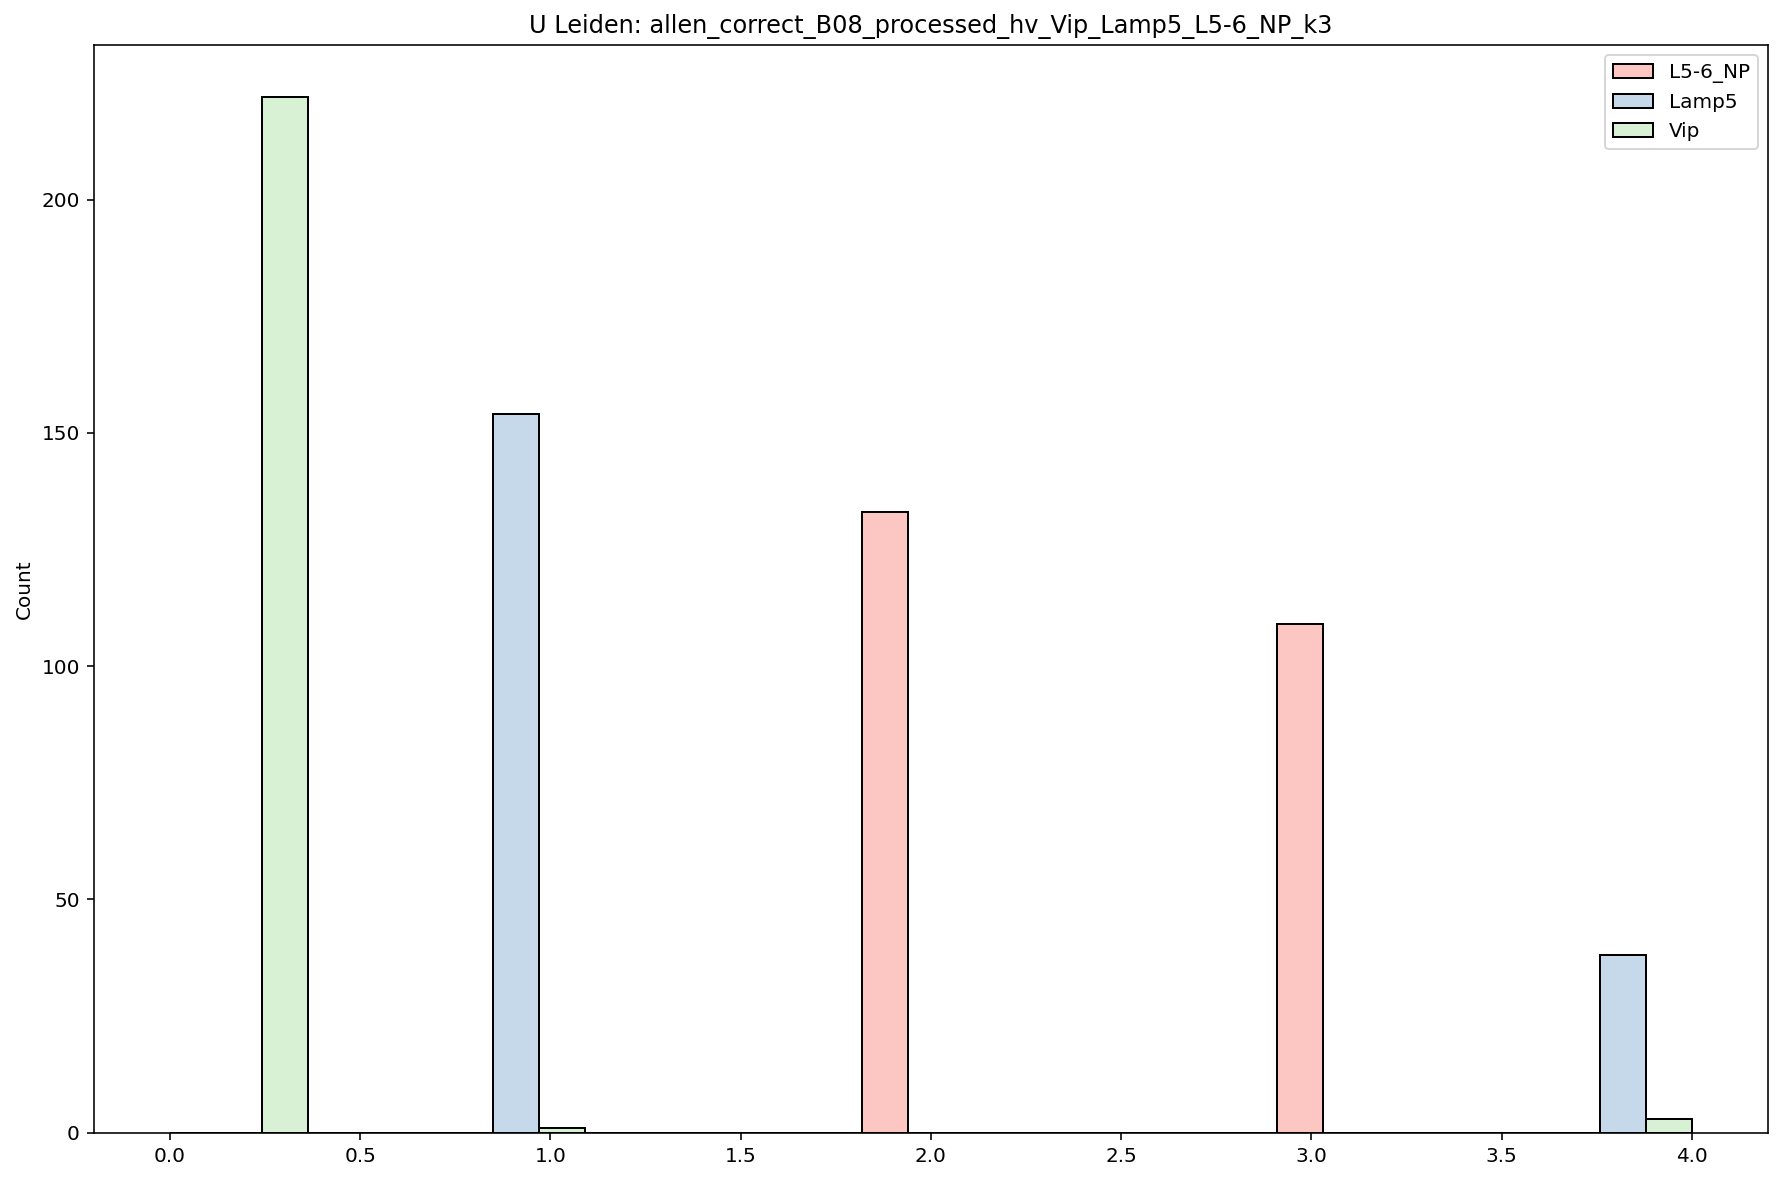

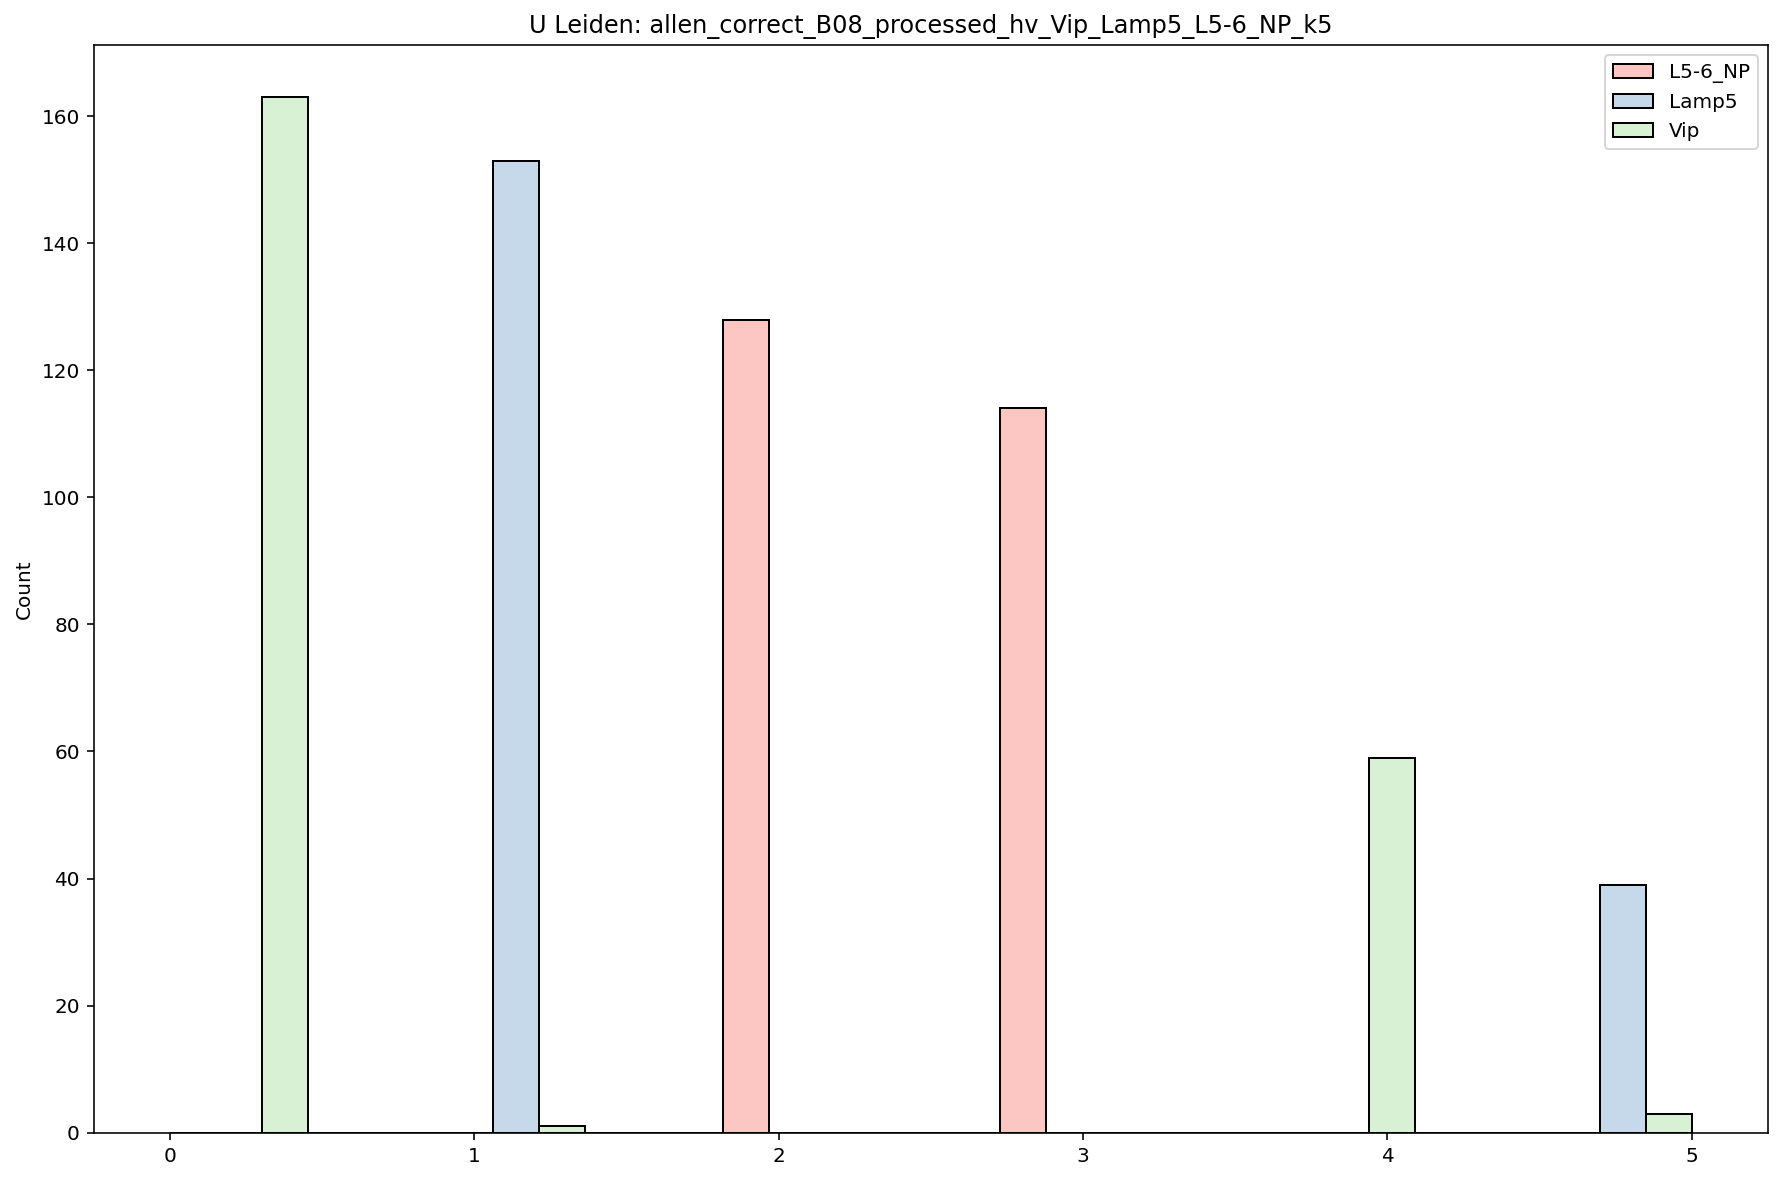

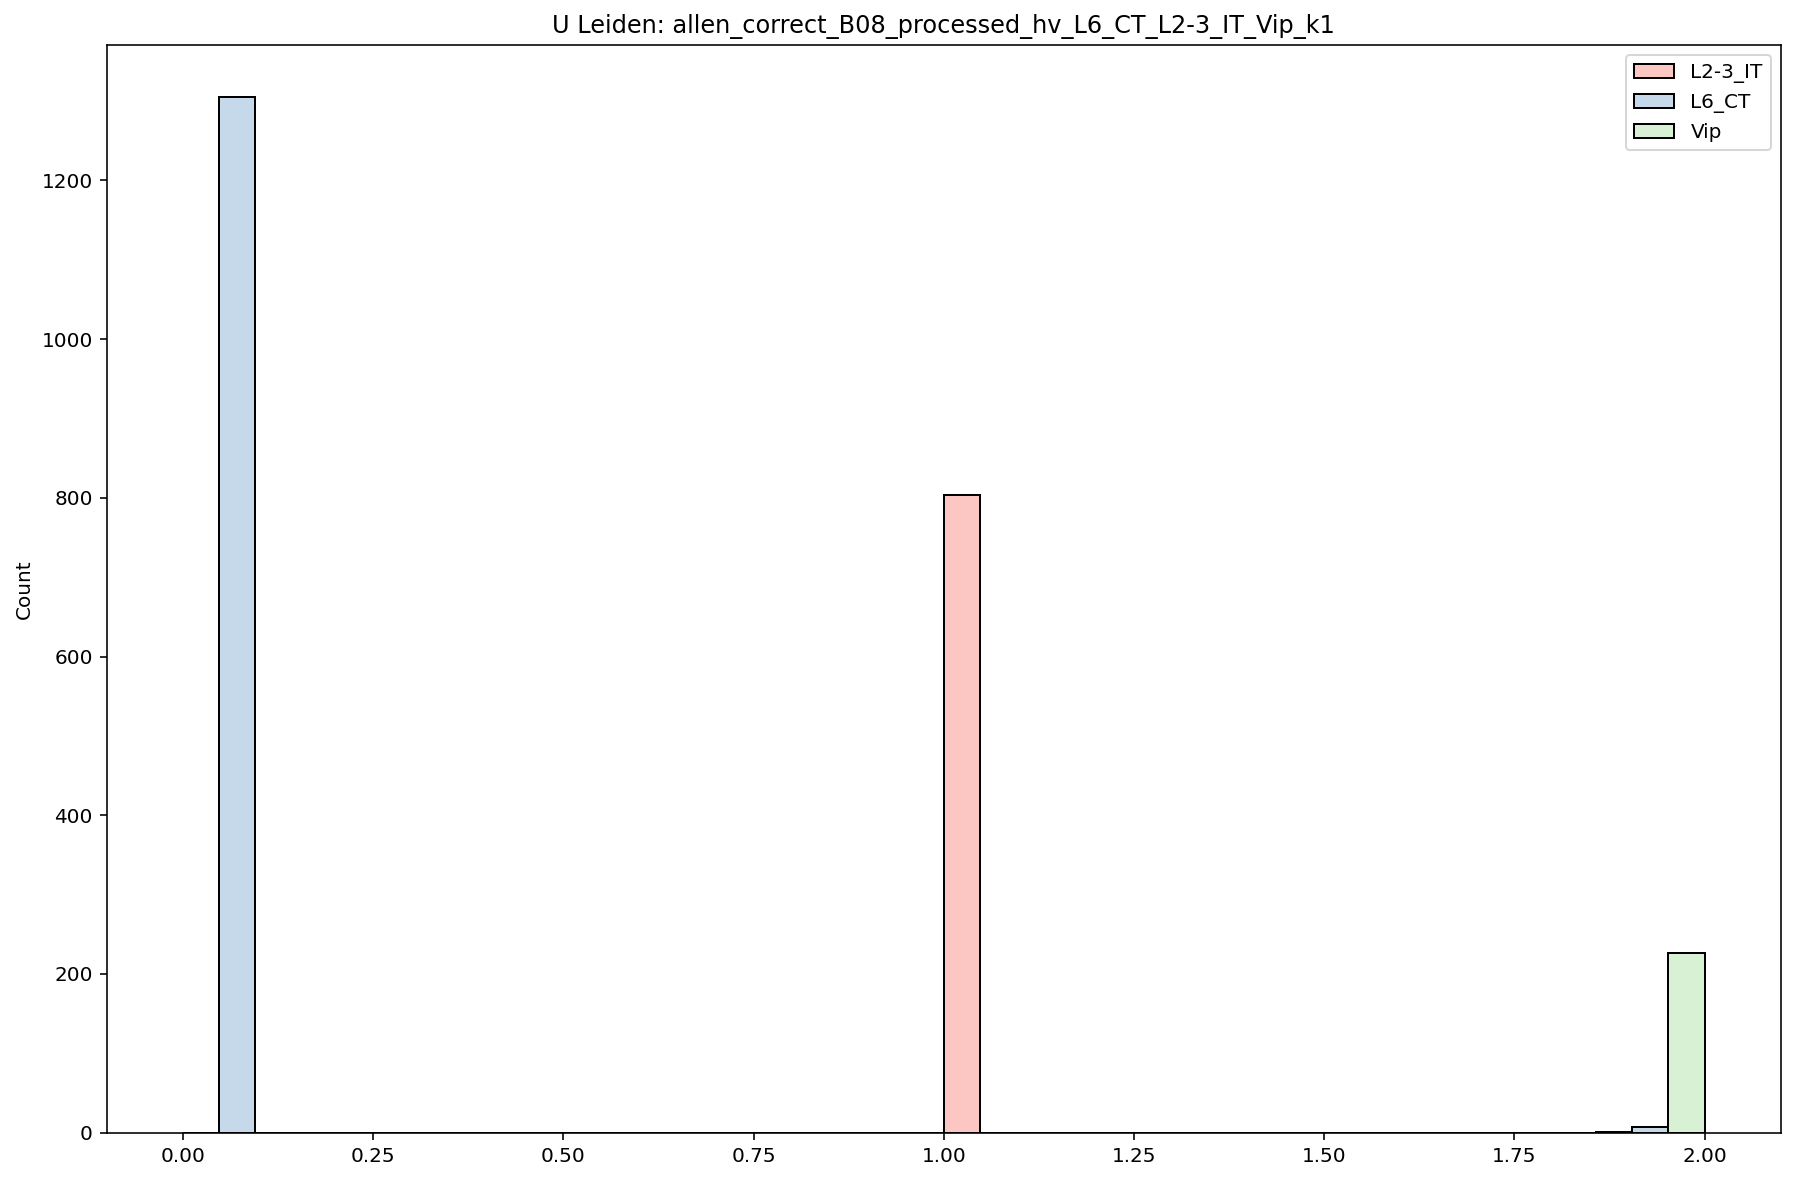

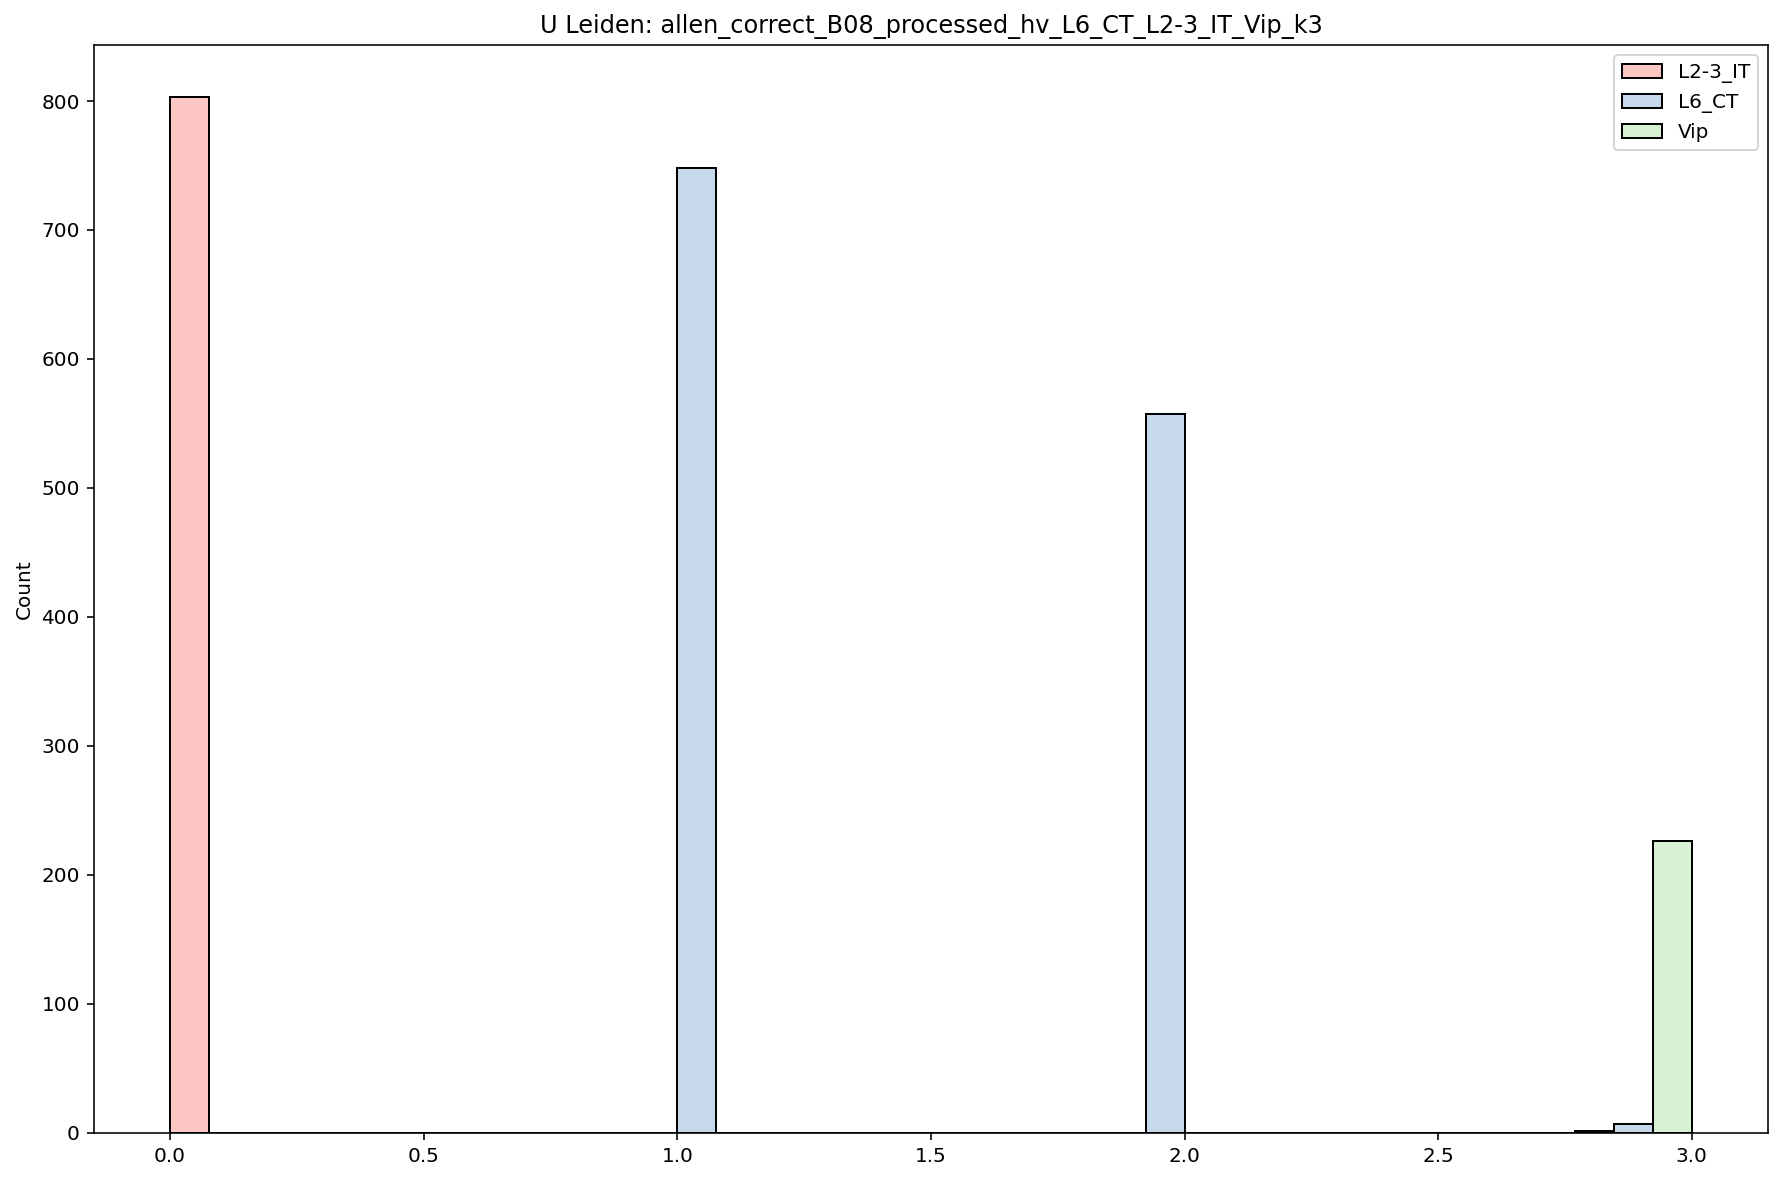

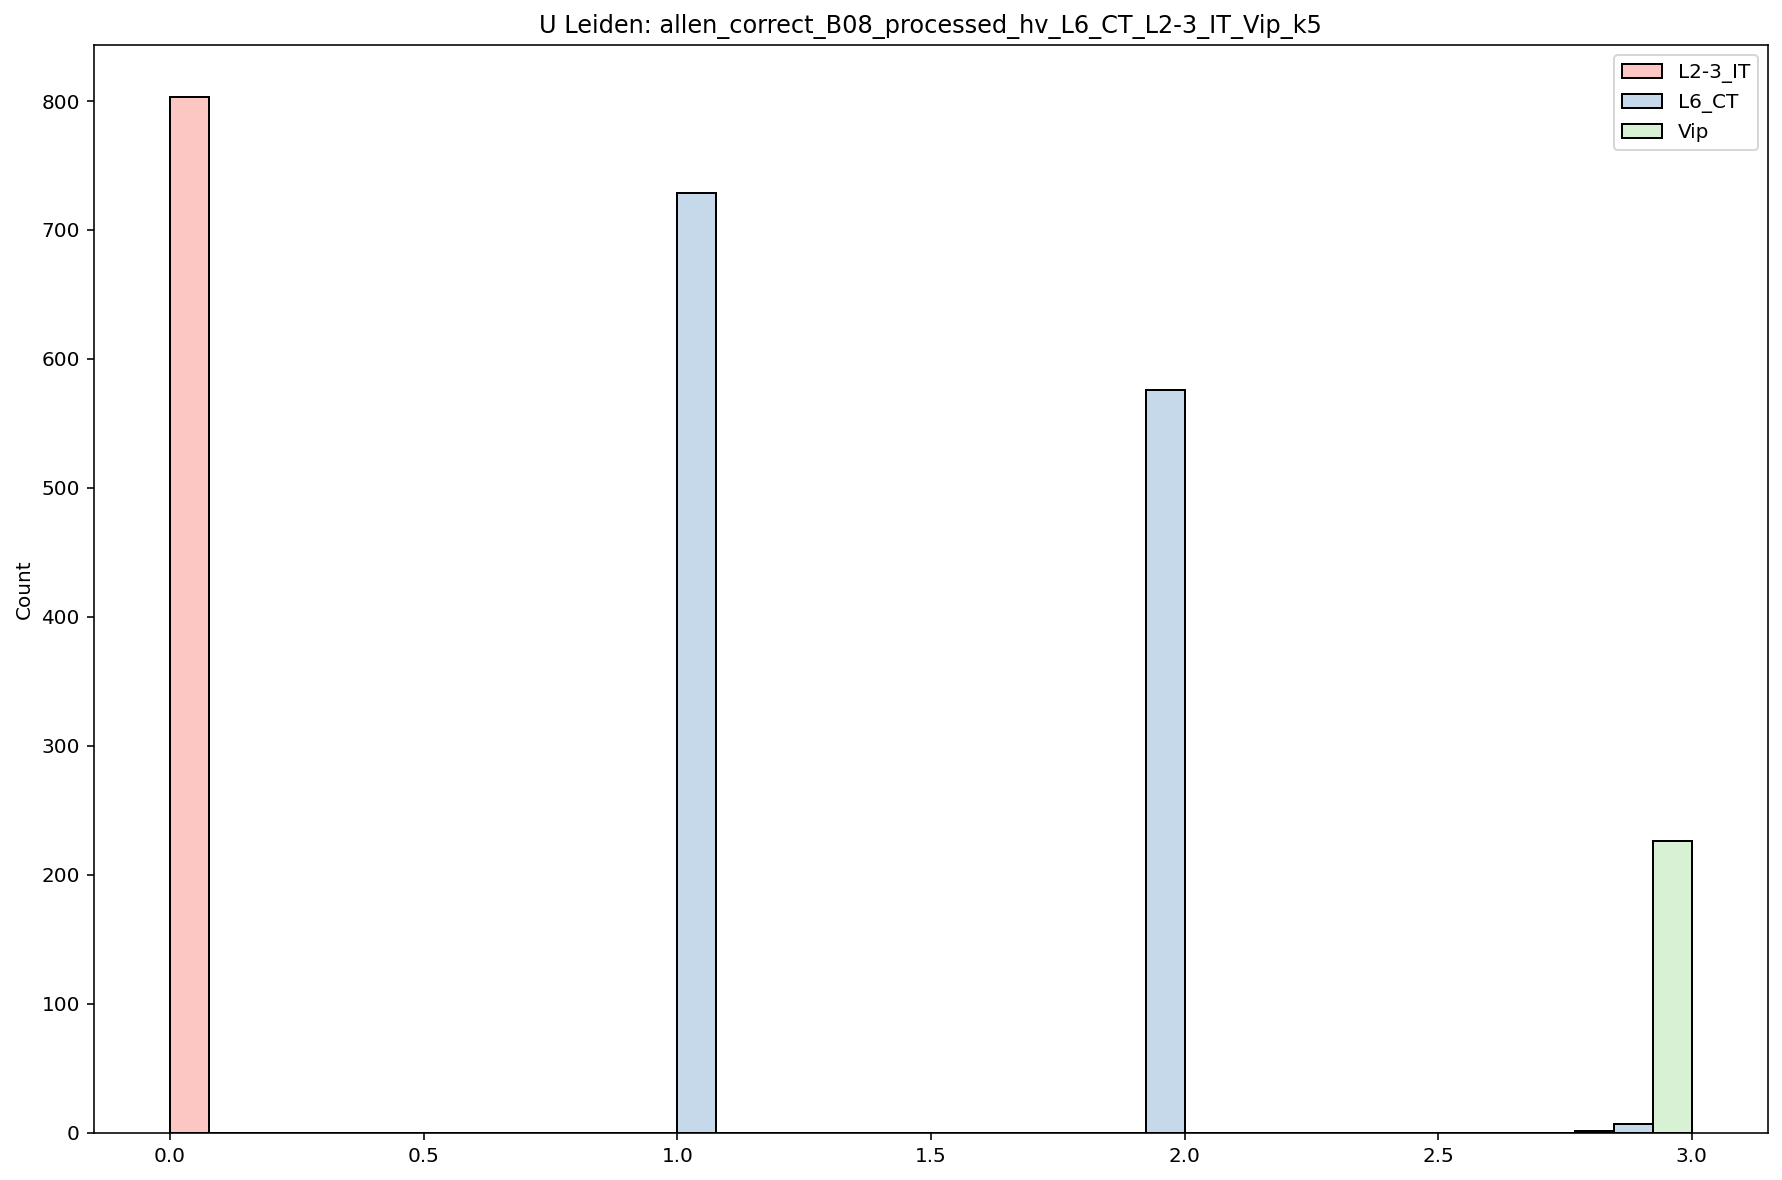

In [33]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('U Leiden: '+dataset_names[i])
    
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:ro

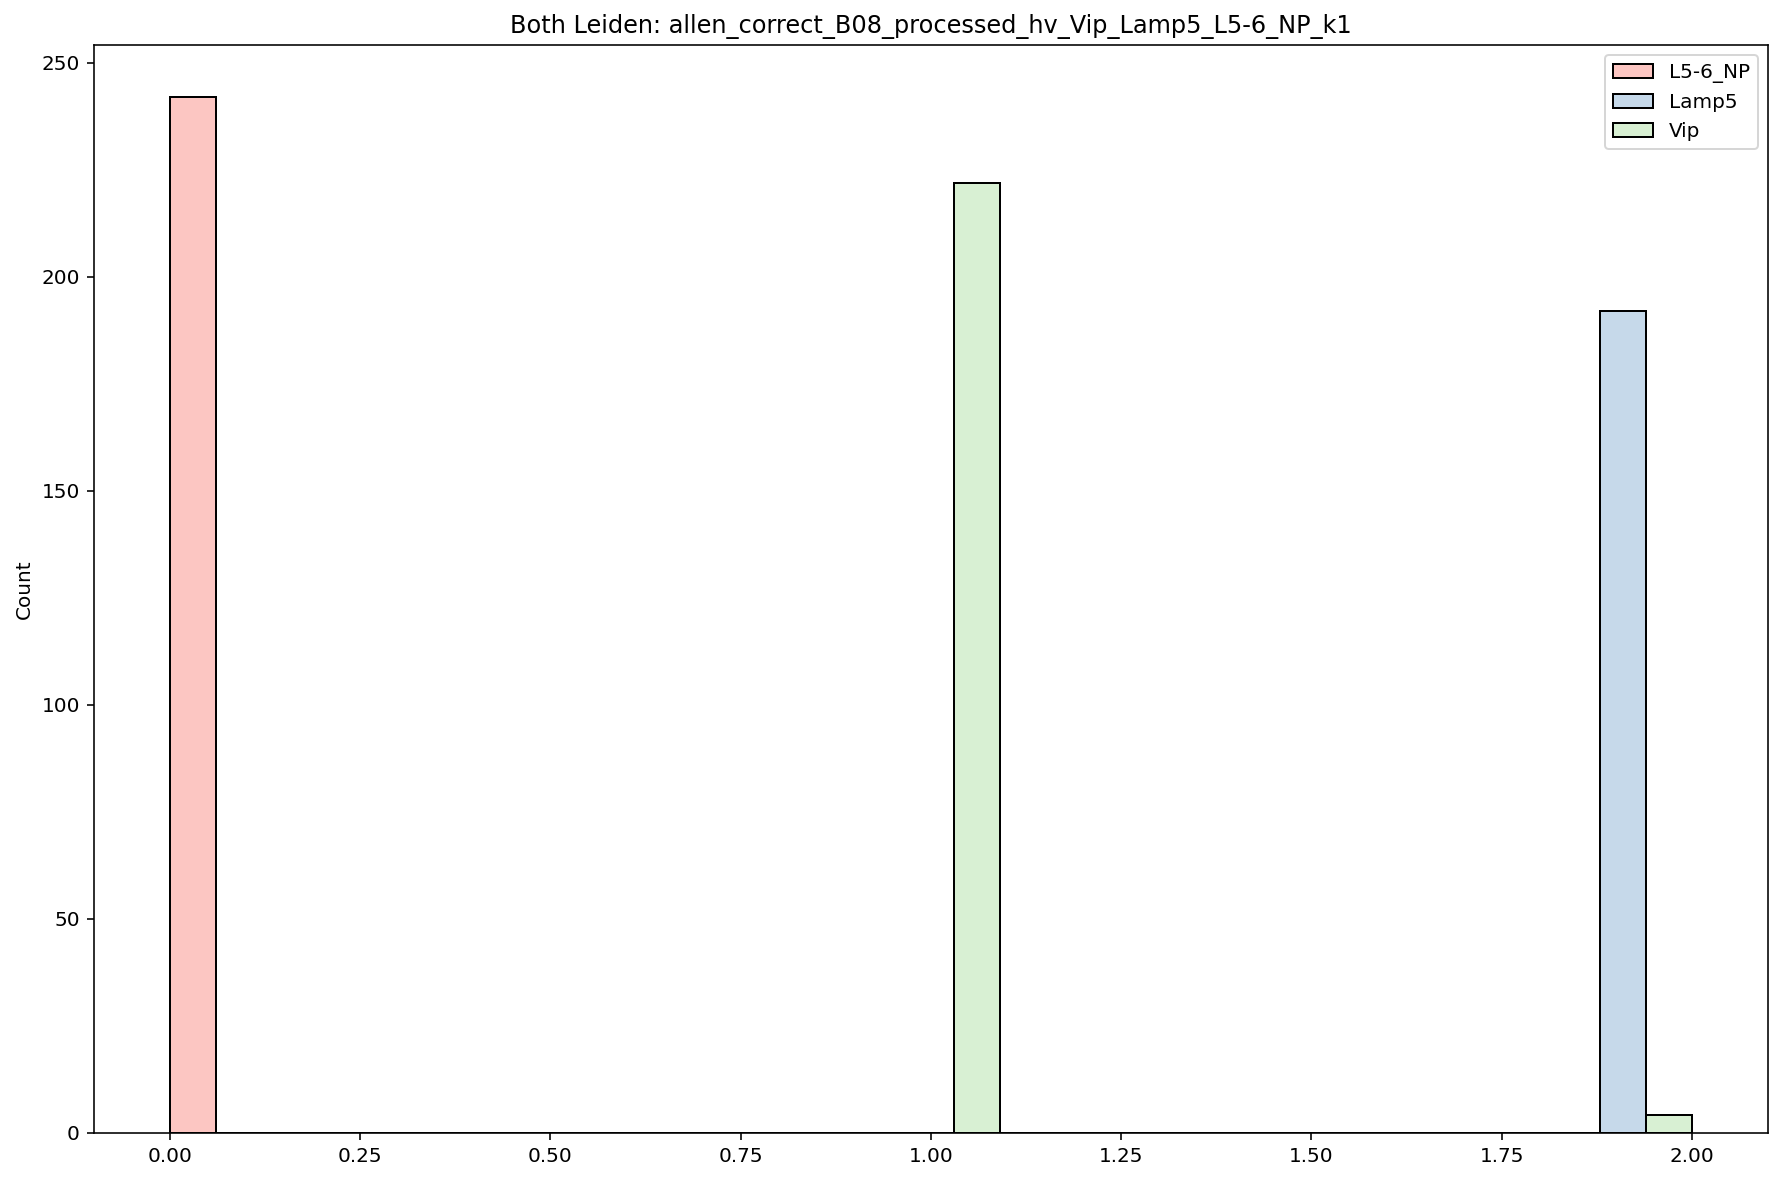

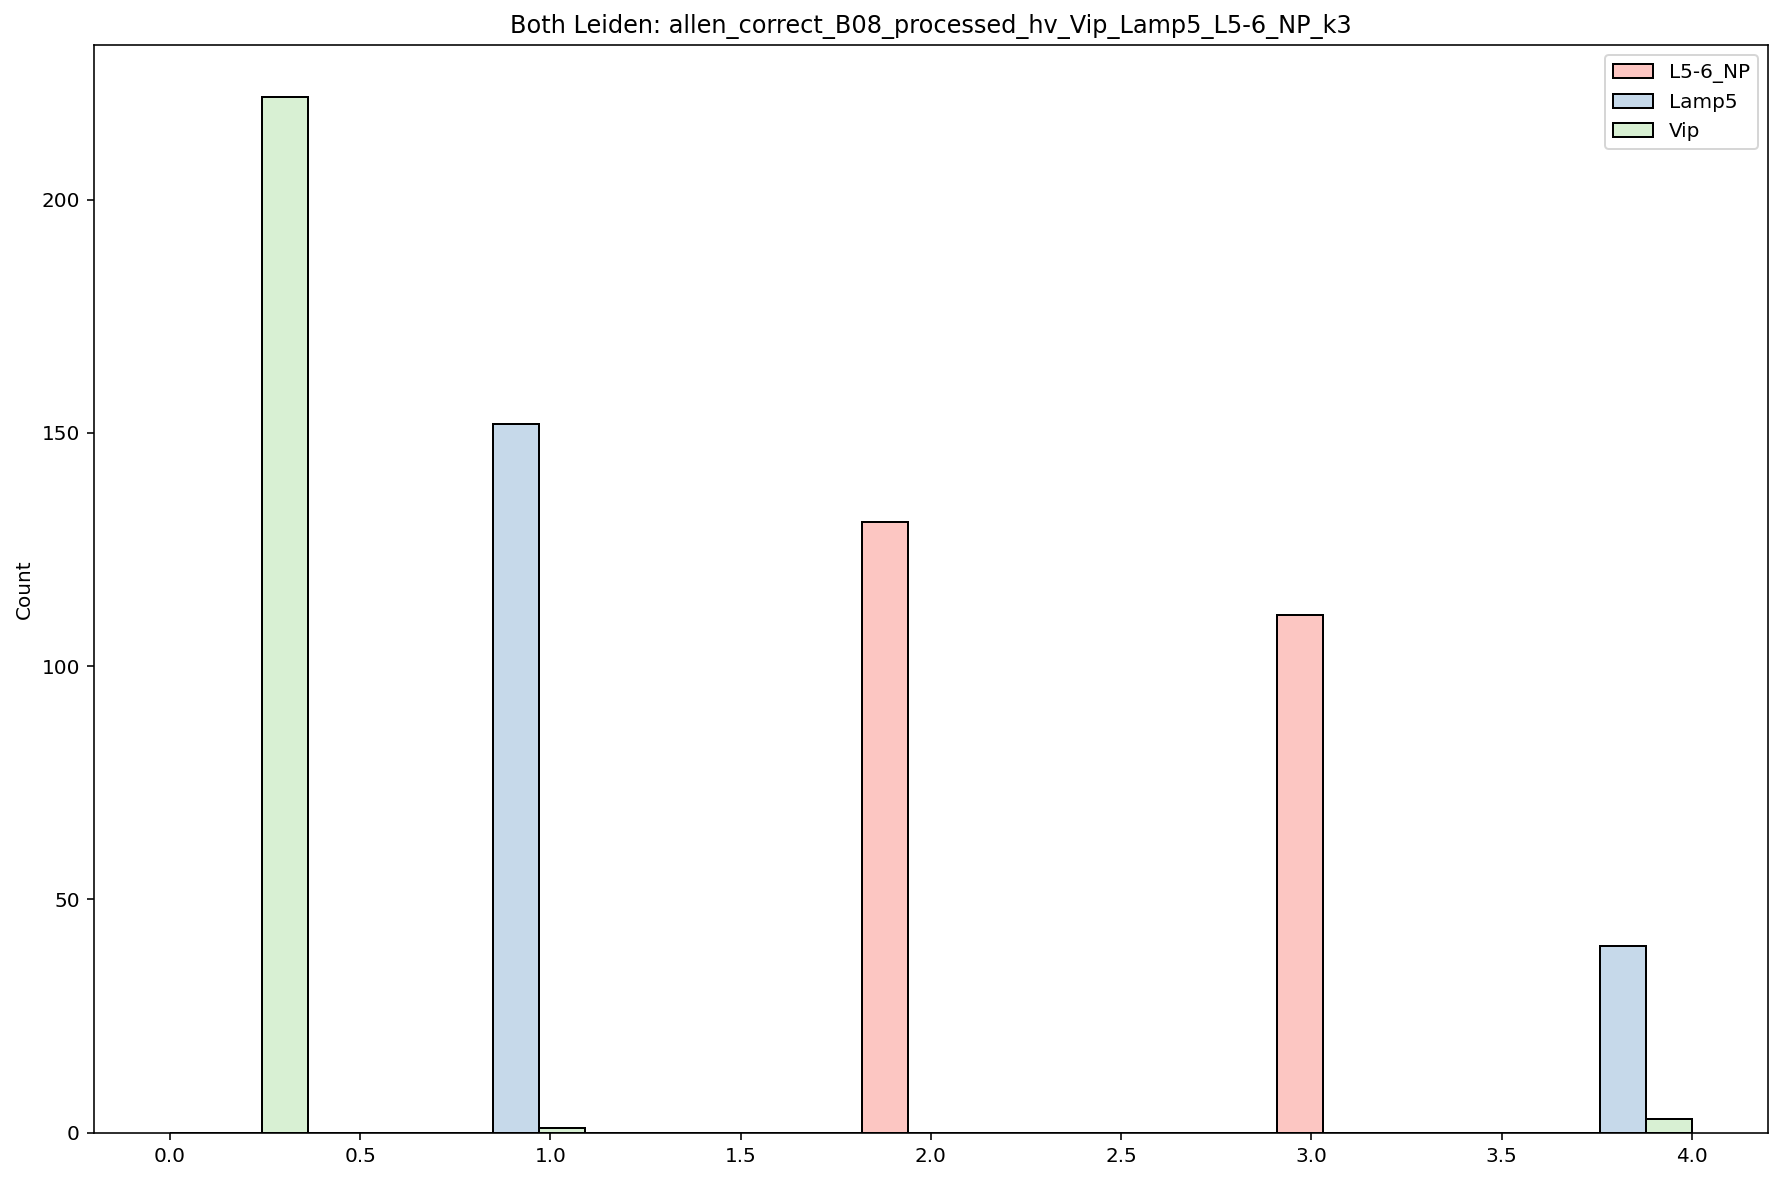

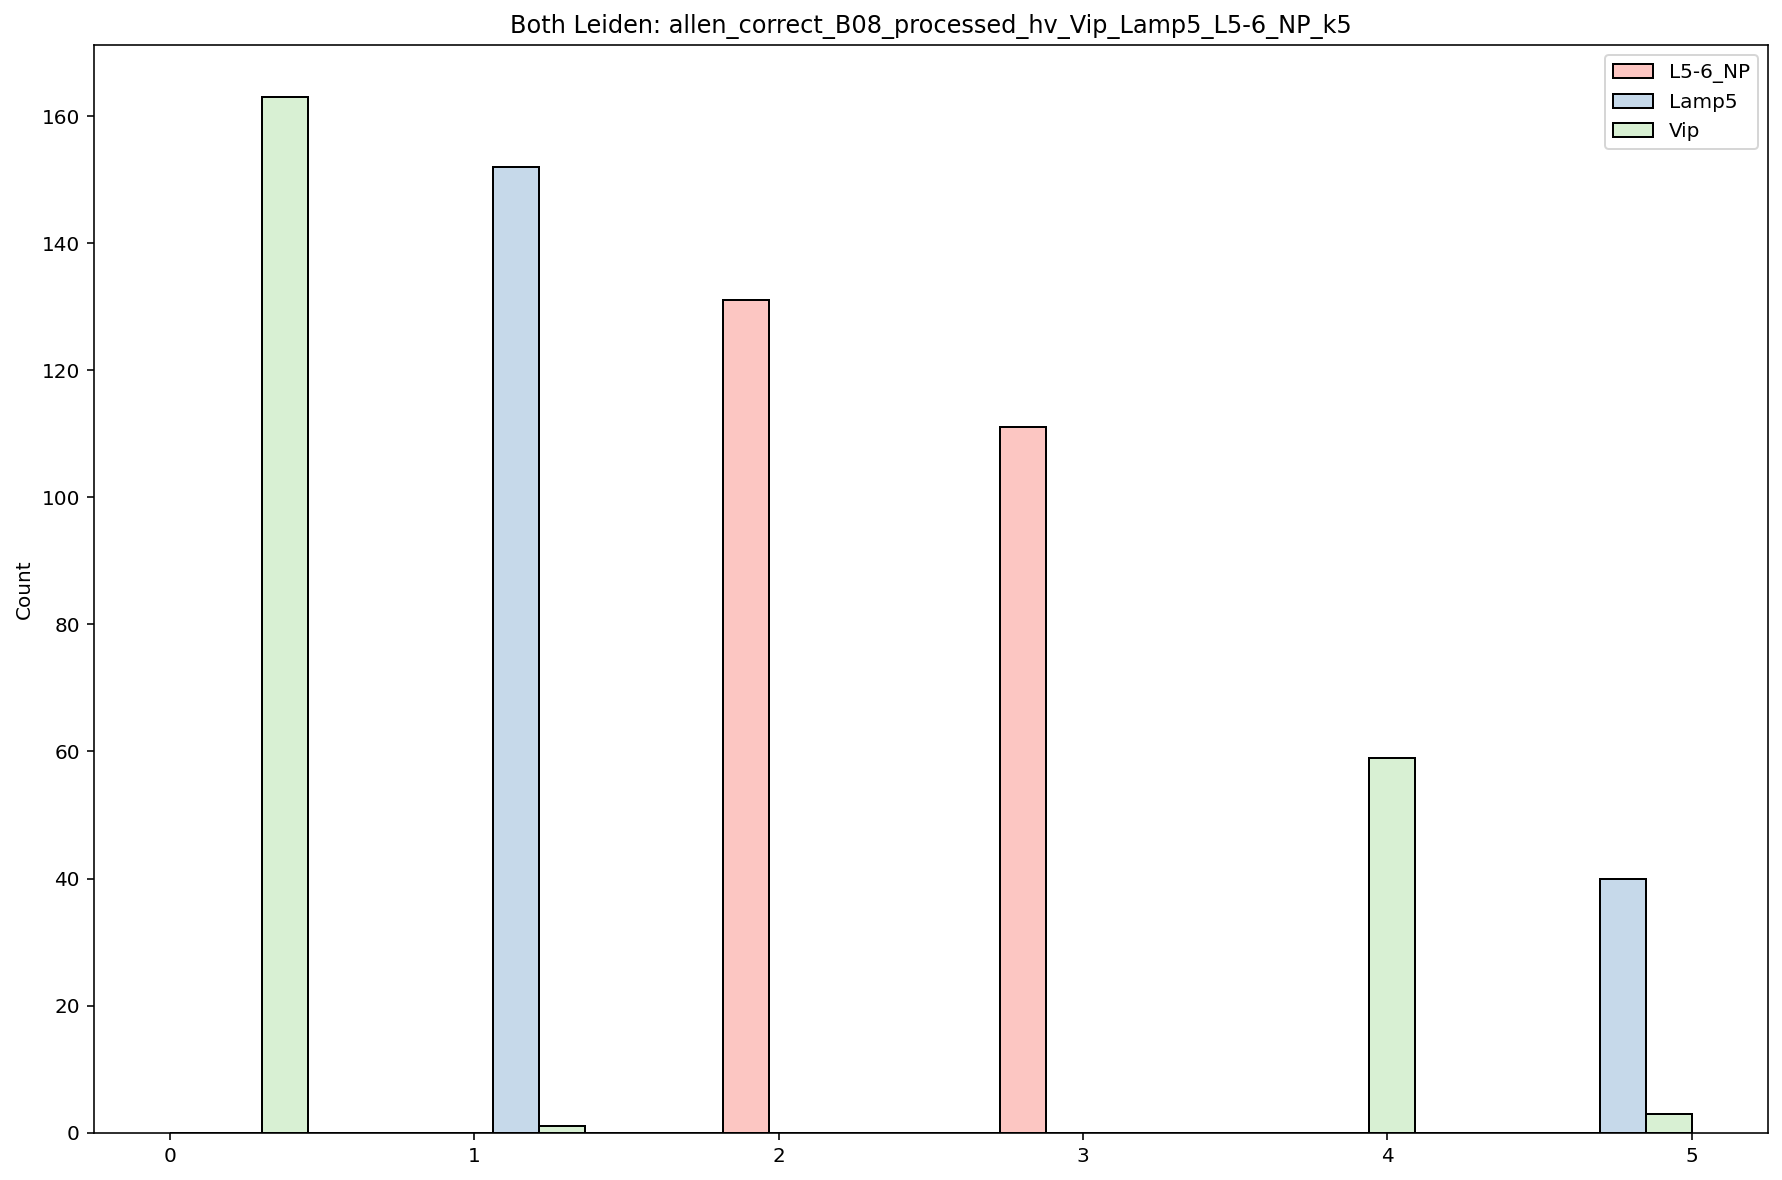

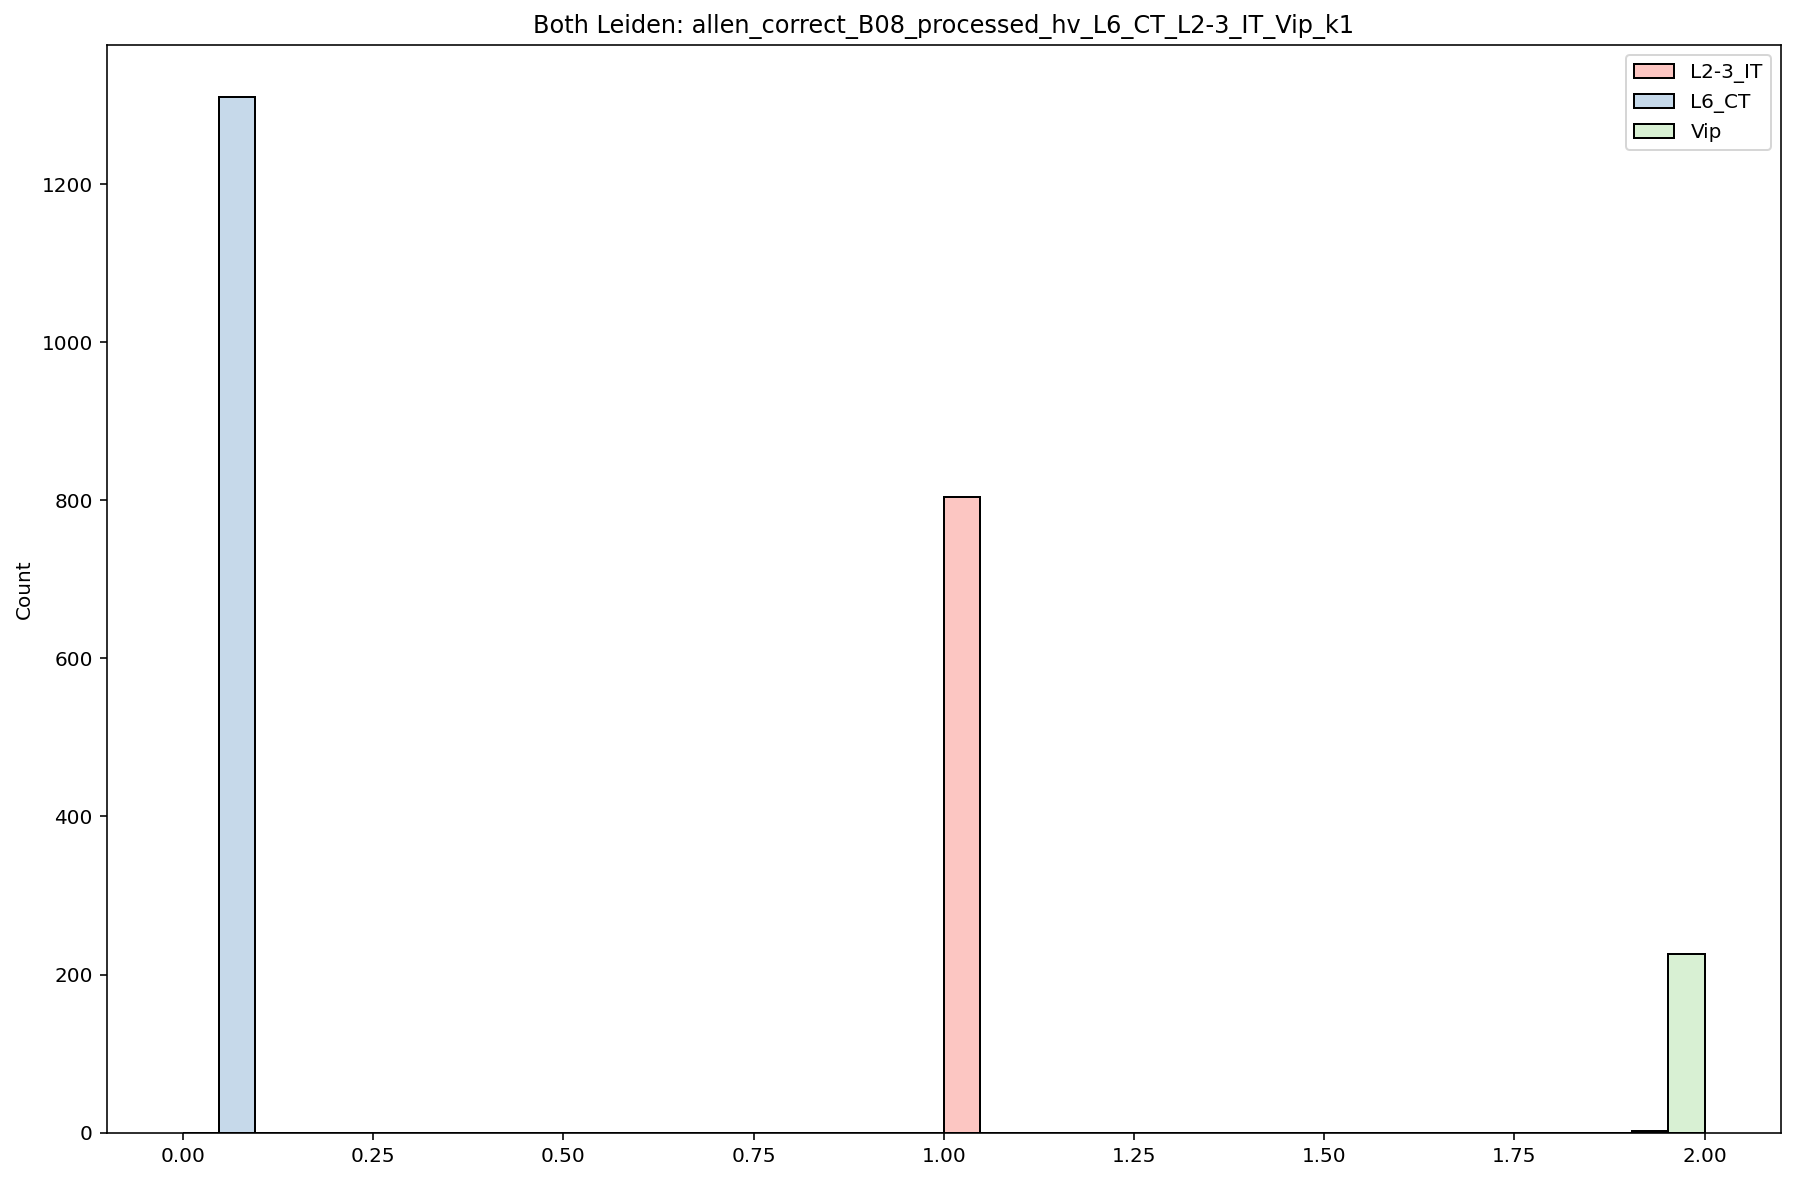

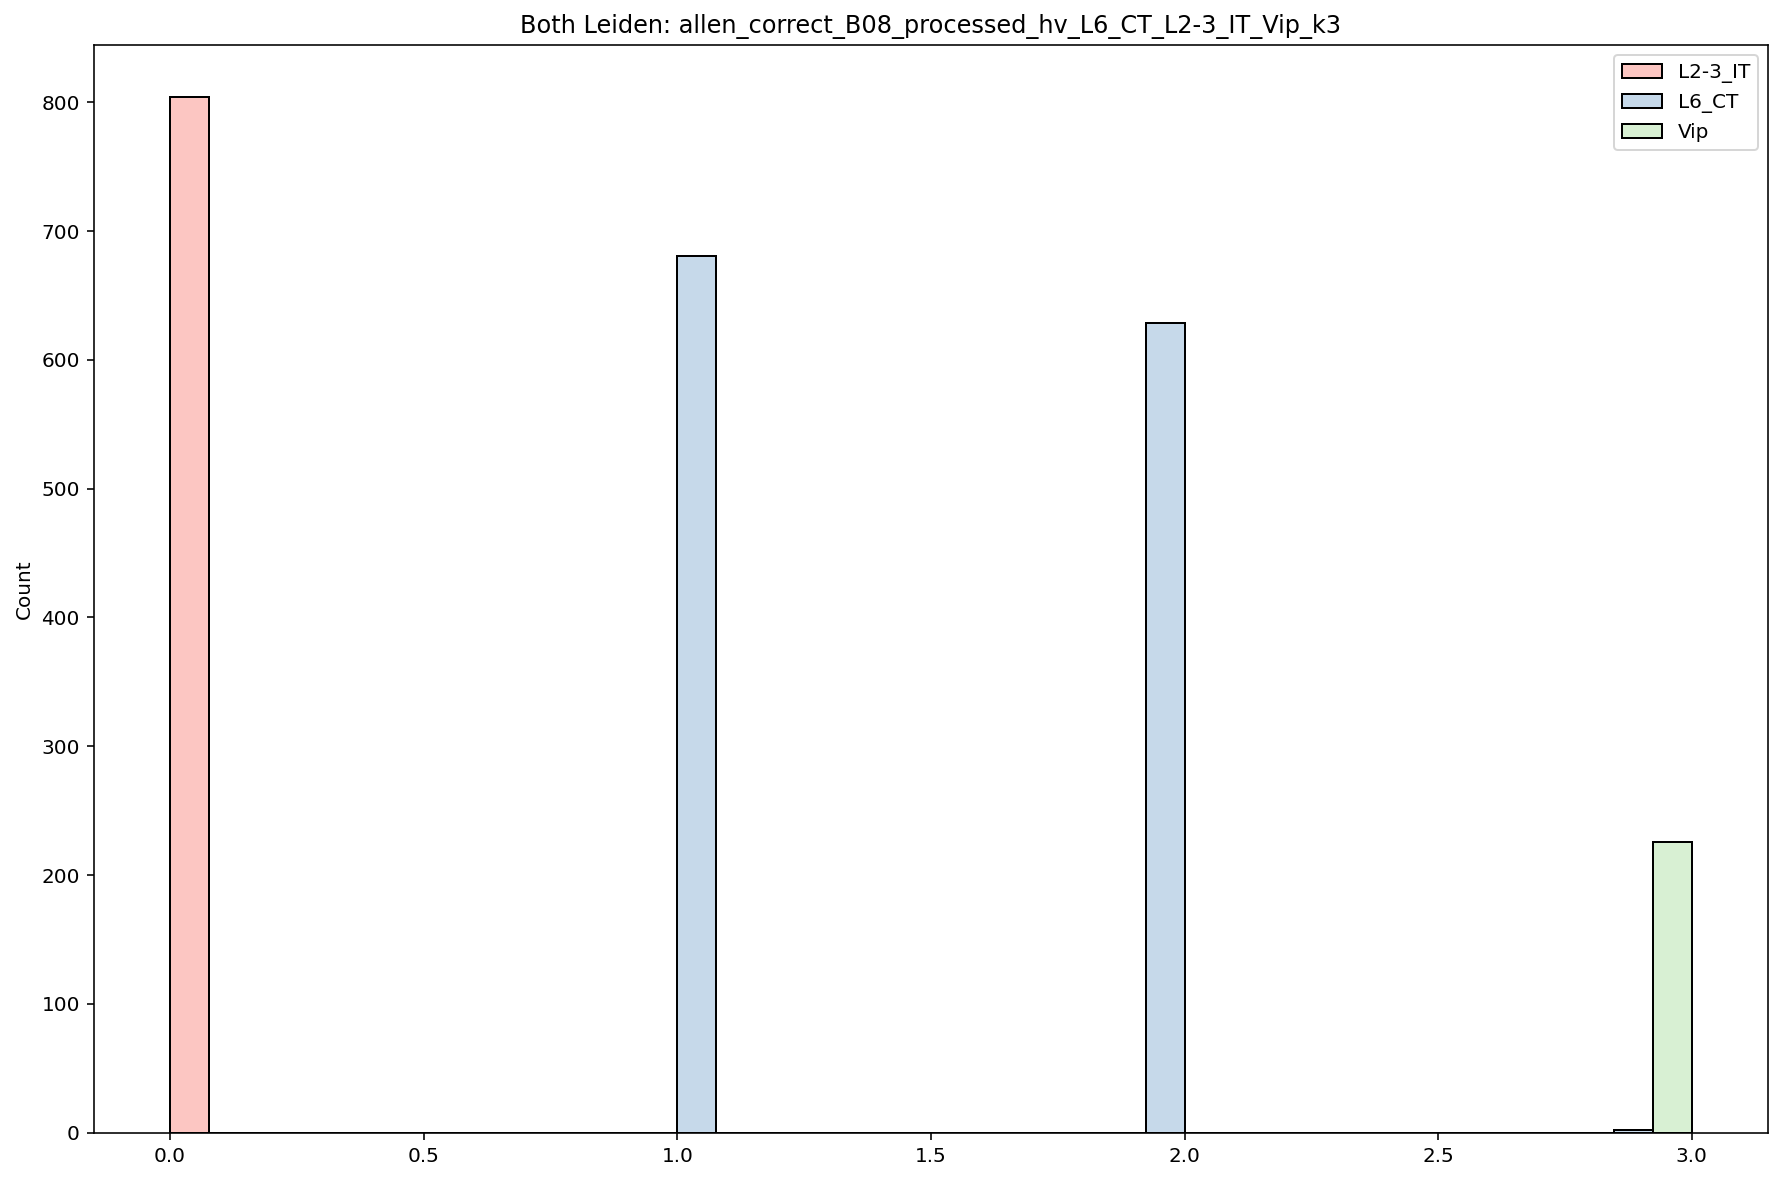

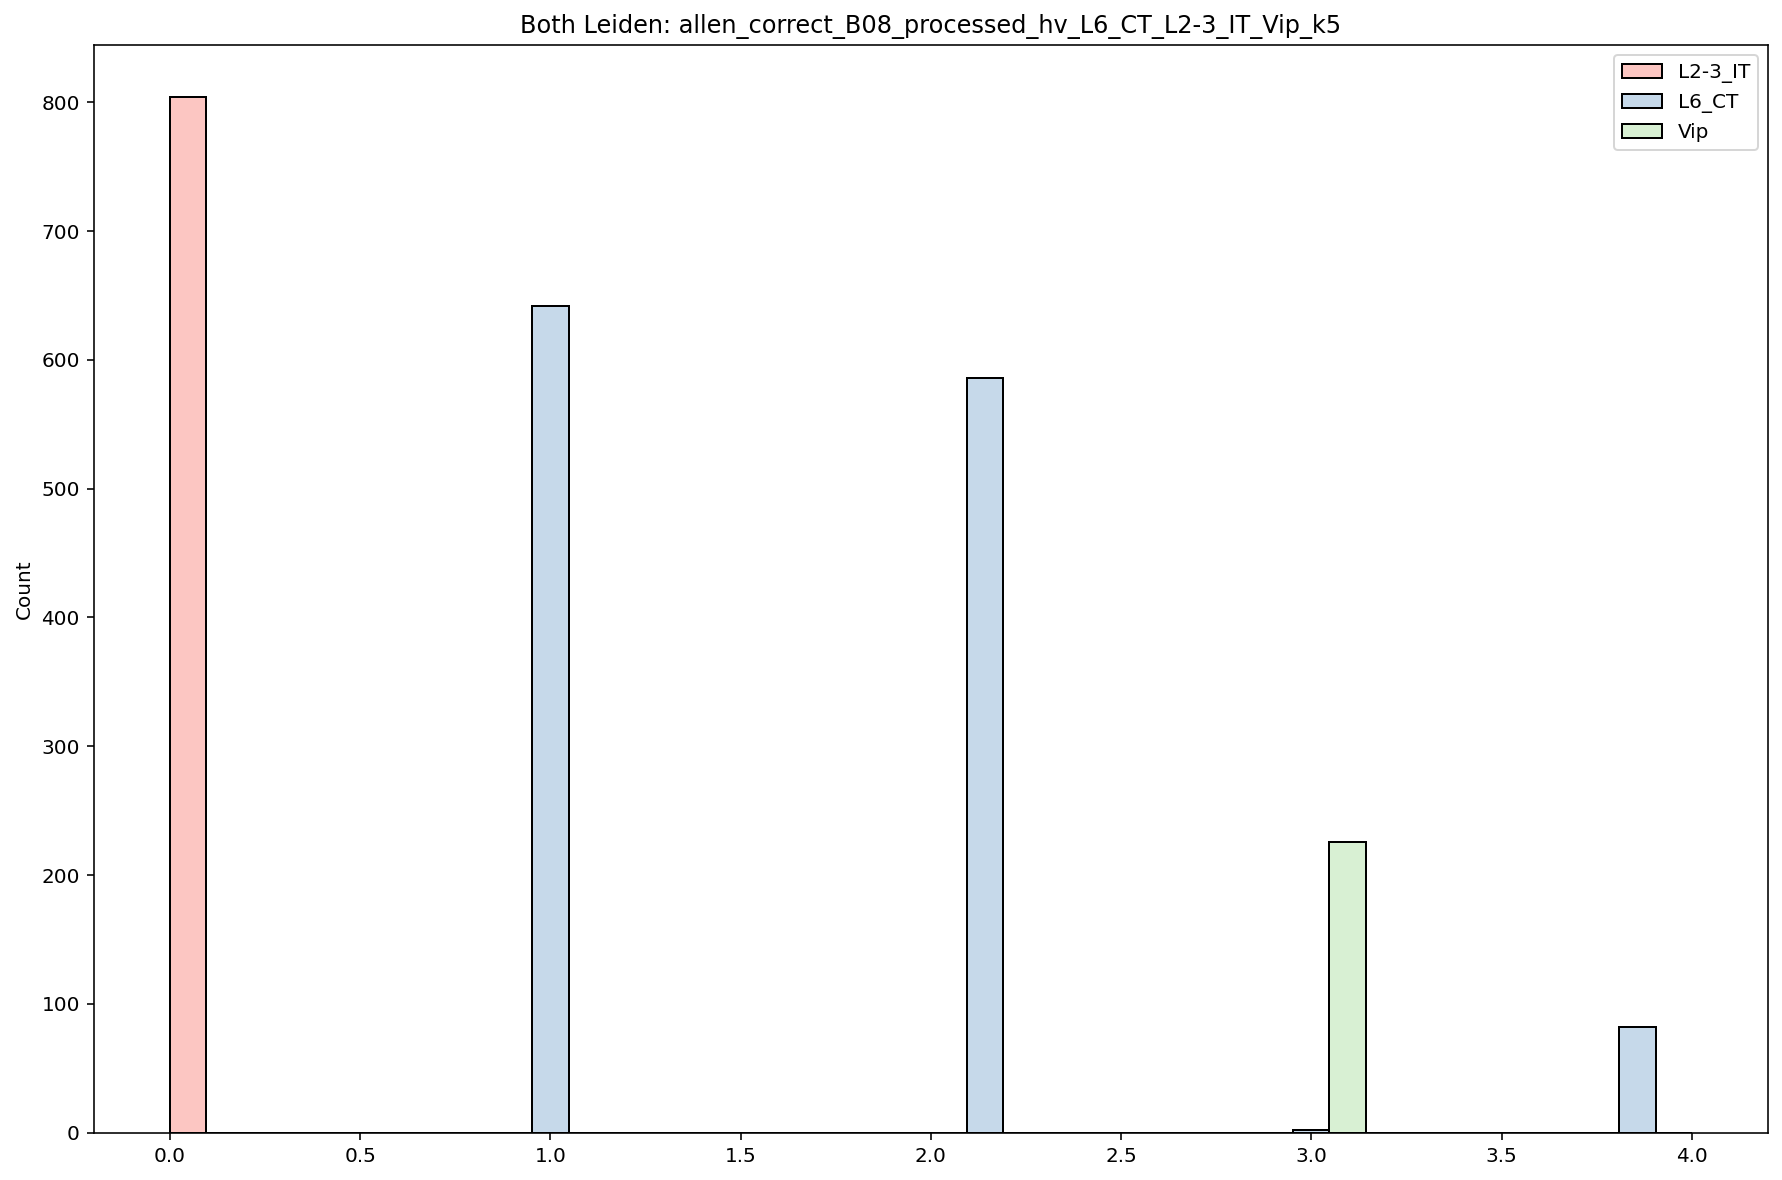

In [34]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('Both Leiden: '+dataset_names[i])
    
    
    


In [35]:
len(all_groups)

18

(5, 5)
(5, 5)
(5, 5)


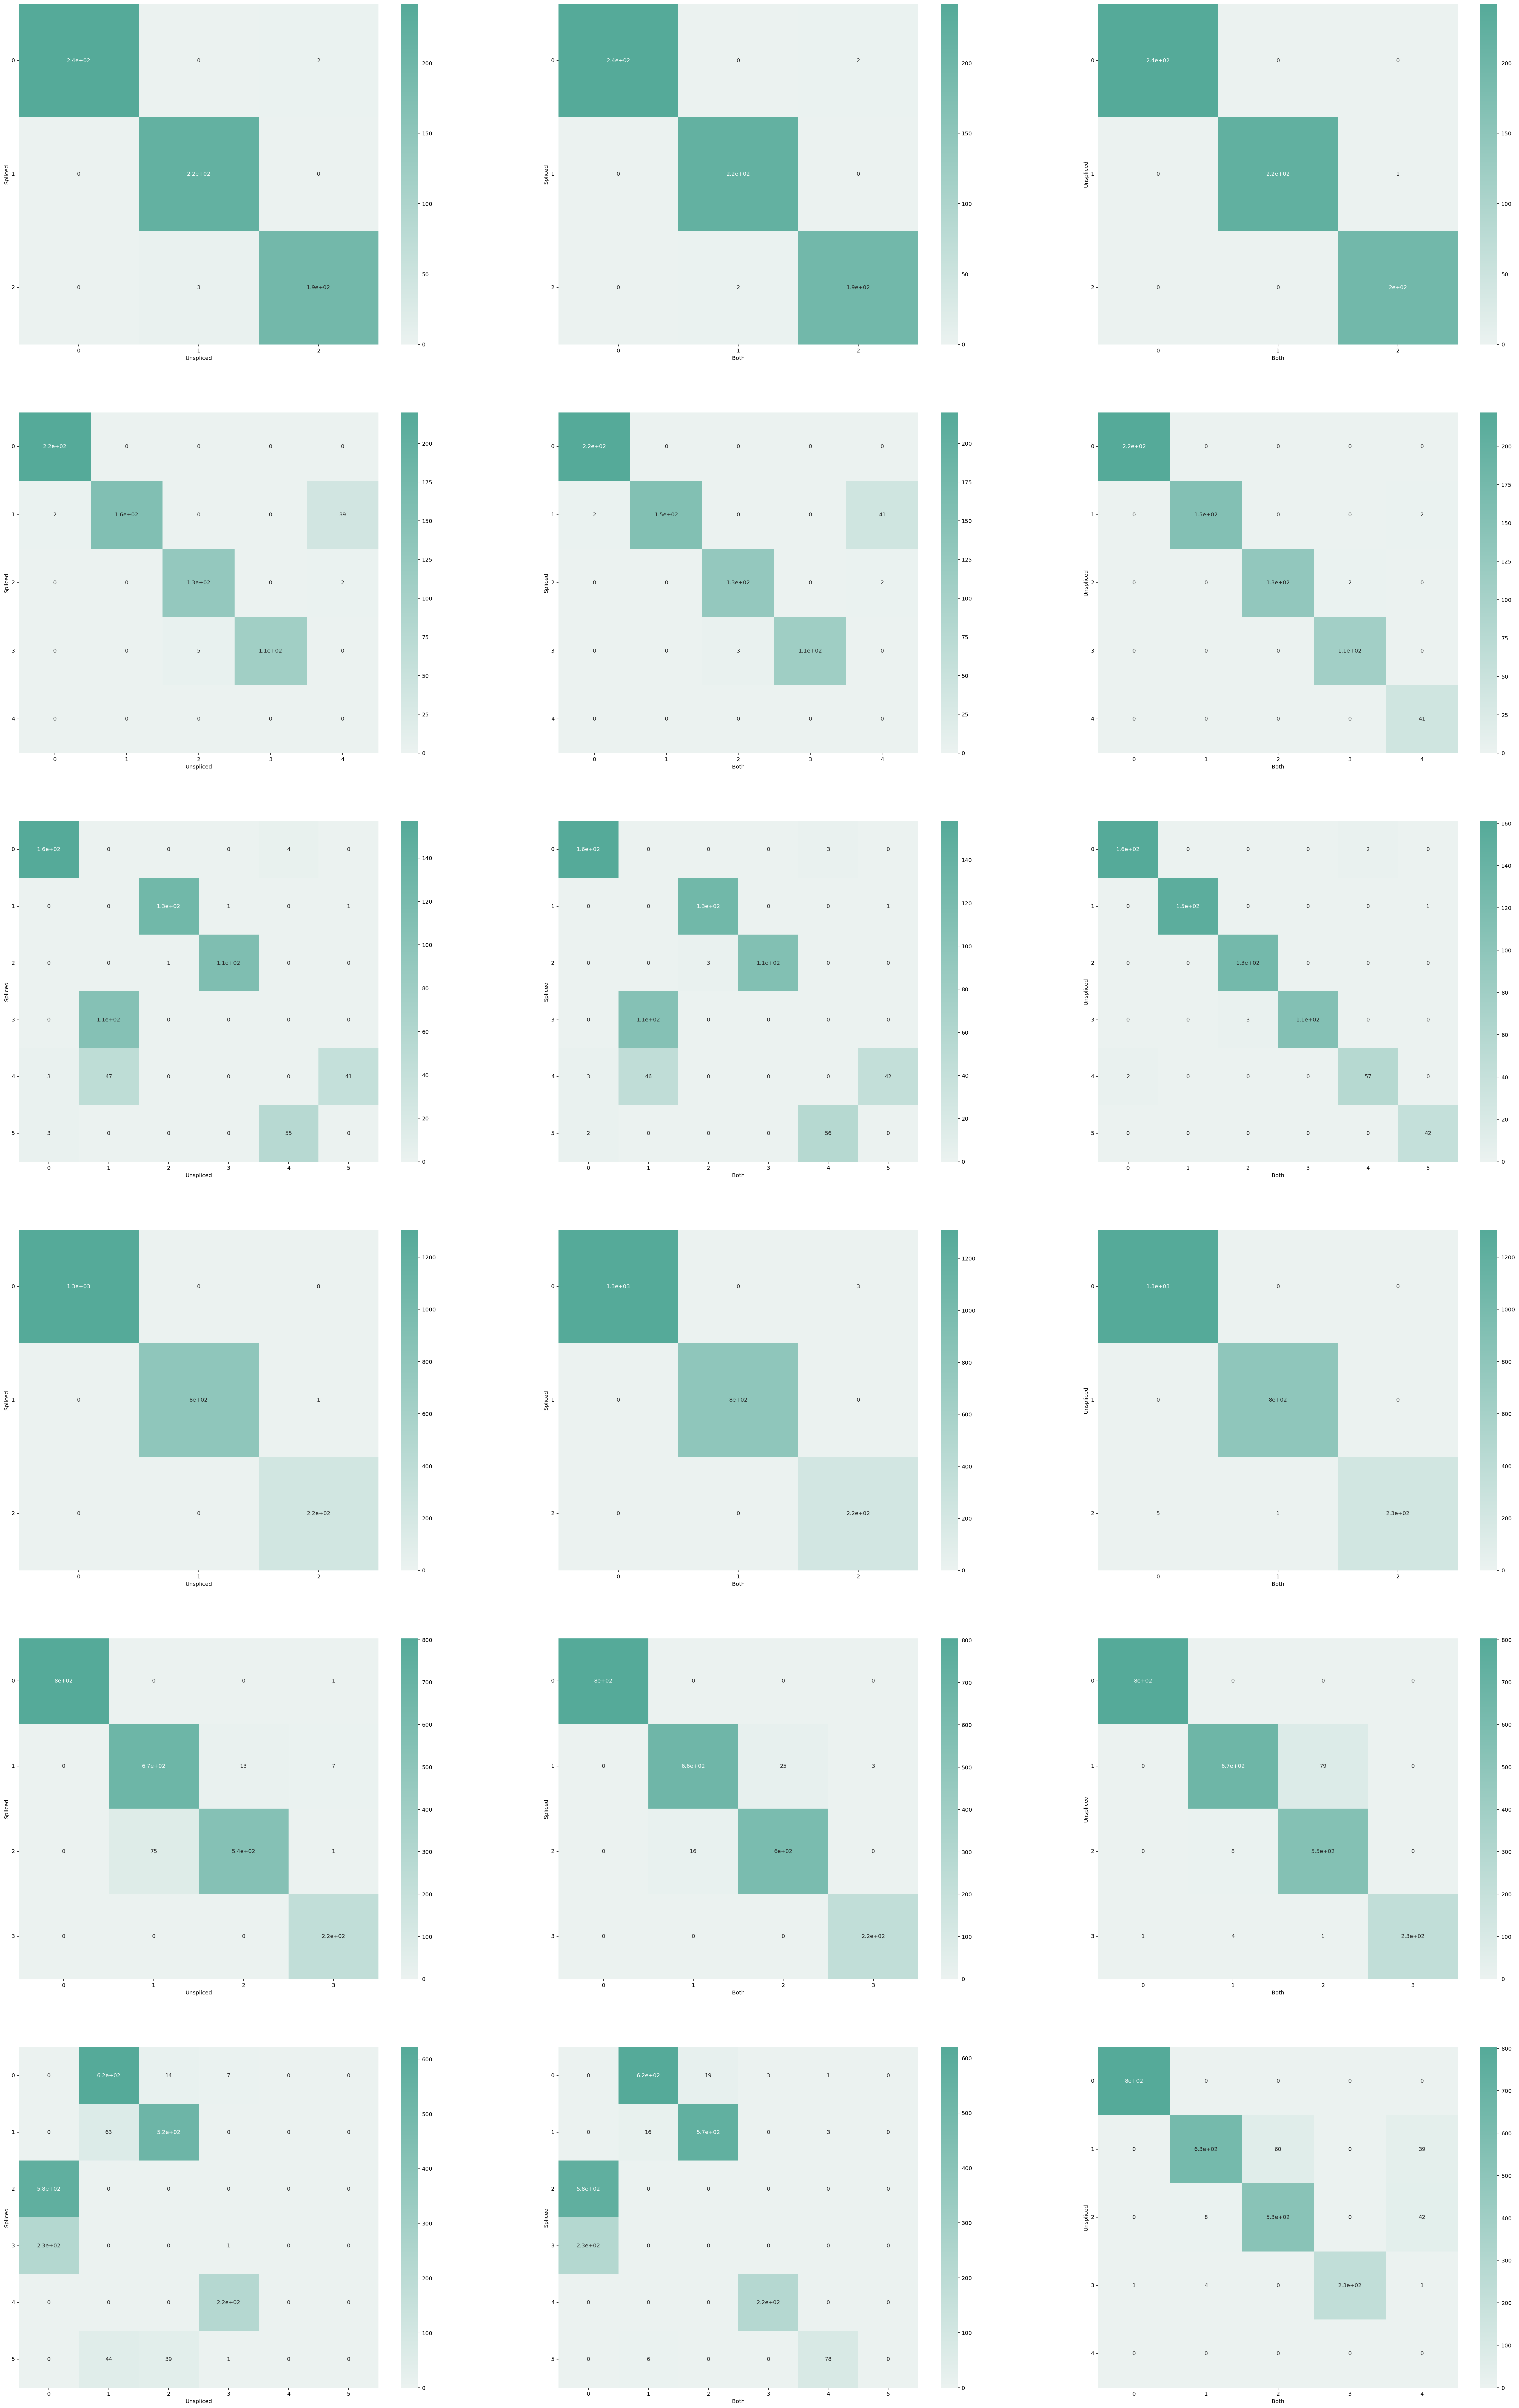

In [38]:
#compare overlap of all k-means assignments

num_per_set = len(chosen)*num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,80))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

## **Run MM/Monod Inference**

v----------- Only Run Once -----------v

In [93]:
#Define bounds, 
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


In [94]:
dataset_names

['allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1',
 'allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3',
 'allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k1',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k3',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k5',
 'allen_correct_B08_processed_hv_Vip',
 'allen_correct_B08_processed_hv_Lamp5',
 'allen_correct_B08_processed_hv_L5-6_NP',
 'allen_correct_B08_processed_hv_L6_CT',
 'allen_correct_B08_processed_hv_L2-3_IT',
 'allen_correct_B08_processed_hv_Vip']

In [136]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-6,len(dataset_names)-1): #MAYBE RERUN???

    fitmodel = monod.cme_toolbox.CMEModel('Bursty',"Poisson") #'Poisson'

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string,viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

In [231]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-6):(len(dataset_names)-2)]]


INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/grid_scan_results.res.
-7.333333333333333 -0.14999999999999947
-7.333333333333333 -0.14999999999999947
-7.333333333333333 -1.25
-6.222222222222222 -0.6999999999999997


Text(0, 0.5, '$\\log_{10} \\lambda_M$')

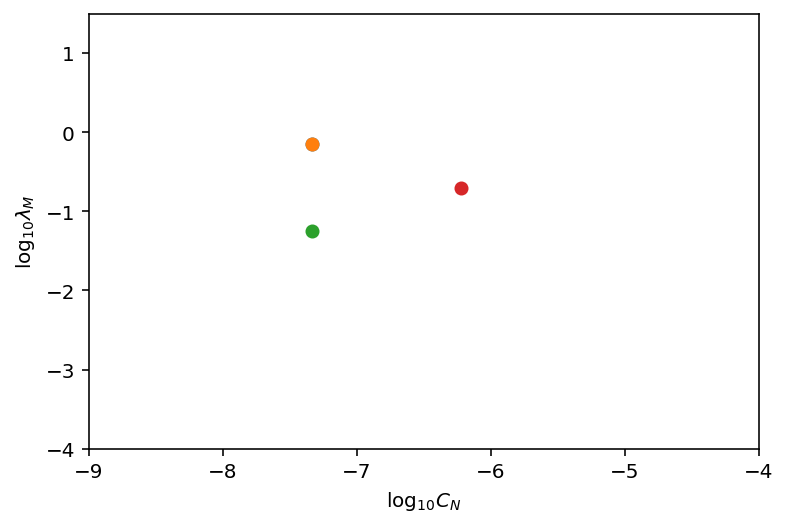

In [232]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
plt.figure()
for r in sr:
    r.find_sampling_optimum()
    plt.scatter(r.samp_optimum[0],r.samp_optimum[1])
    print(r.samp_optimum[0],r.samp_optimum[1])
    
plt.xlim([-9,-4])
plt.ylim([-4,1.5])

plt.xlabel(r'$\log_{10} C_N$')
plt.ylabel(r'$\log_{10} \lambda_M$')

In [99]:
inference_parameters.X

array([-9.        , -9.        , -9.        , -9.        , -9.        ,
       -9.        , -9.        , -9.        , -9.        , -9.        ,
       -9.        , -8.44444444, -8.44444444, -8.44444444, -8.44444444,
       -8.44444444, -8.44444444, -8.44444444, -8.44444444, -8.44444444,
       -8.44444444, -8.44444444, -7.88888889, -7.88888889, -7.88888889,
       -7.88888889, -7.88888889, -7.88888889, -7.88888889, -7.88888889,
       -7.88888889, -7.88888889, -7.88888889, -7.33333333, -7.33333333,
       -7.33333333, -7.33333333, -7.33333333, -7.33333333, -7.33333333,
       -7.33333333, -7.33333333, -7.33333333, -7.33333333, -6.77777778,
       -6.77777778, -6.77777778, -6.77777778, -6.77777778, -6.77777778,
       -6.77777778, -6.77777778, -6.77777778, -6.77777778, -6.77777778,
       -6.22222222, -6.22222222, -6.22222222, -6.22222222, -6.22222222,
       -6.22222222, -6.22222222, -6.22222222, -6.22222222, -6.22222222,
       -6.22222222, -5.66666667, -5.66666667, -5.66666667, -5.66

In [100]:
inference_parameters.Y

array([-4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,
        0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 ,
       -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 ,
       -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 ,
       -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  ,
       -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,
        1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,
        0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25,
       -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45, -2.9 , -2.35,
       -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 , -4.  , -3.45,
       -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,  0.95,  1.5 ,
       -4.  , -3.45, -2.9 , -2.35, -1.8 , -1.25, -0.7 , -0.15,  0.4 ,
        0.95,  1.5 ])

In [230]:
# #Check correlations of means
# test_fit = monod.analysis.load_search_results('./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_10x11/grid_scan_results.res')
# test_raw = monod.analysis.load_search_data('./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/raw.sd')

# monod_mu = test_fit.param_estimates[0,:,0] - test_fit.param_estimates[0,:,2]
# means = np.mean(test_raw.layers[1,:,:],axis=1)

# plt.scatter(monod_mu[means!=0],means[means!=0])

# plt.xscale('log')
# plt.yscale('log')

In [233]:
#Find closest technical param in grid, to centroid of technical params on plot
arbitrary_params = np.asarray([-6.8,-1]) #-8,-2.5
arbitrary_ind = np.argmin(((sr[0].sp.sampl_vals-arbitrary_params)**2).sum(1))
arbitrary_pars = sr[0].sp.sampl_vals[arbitrary_ind]
print(arbitrary_pars)
print(arbitrary_ind)

(-6.777777777777778, -1.25)
49


^----------- Only Run Once -----------^

In [234]:
#Define bounds, choose 'centroid'
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-6.777777777777778, -1.25] #-7.333333, -2
samp_ub = [-6.777777777777778, -1.25] #-7.333333, 0
# gridsize = [5,6]
gridsize = [1,1]


In [235]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-6,len(dataset_names)-1):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)
    

INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.41s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 108.8 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Lamp5


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:23<00:00, 143.08s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 144.6 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L5-6_NP


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:16<00:00, 76.72s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 78.2 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:36<00:00, 96.53s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 97.9 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L2-3_IT


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:50<00:00, 110.81s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 112.2 seconds.


In [236]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[len(dataset_names)-6:len(dataset_names)-1]]


In [237]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1/grid_scan_results.res.


In [238]:
#Raw ds files (with spliced/unspliced counts)
raws = [i+'/raw.sd' for i in dataset_strings[len(dataset_names)-6:-1]] #0:len(chosen)*num_ks
sd = [monod.analysis.load_search_data(i) for i in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/raw.sd.


**Mixture Model**

In [239]:
epochs = 20

In [ ]:
result_strings = []
for i in range(len(chosen)*num_ks): #rlen(chosen)*num_ks
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i%num_ks],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(50,search_data)


INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:28<00:00, 388.93s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:01<00:00, 241.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [06:05<00:00, 365.18s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:32<00:00, 272.74s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:46<00:00, 226.32s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [05:07<00:00, 307.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:48<00:00, 288.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [03:53<00:00, 233.49s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [1.]
Q Function:  -997669.4892689814

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


  0%|                                                                                                                                | 0/1 [00:00<?, ?it/s]

## **Analysis of Results**

In [43]:
#Plot cluster concordance with true labels and distribution of clusters 
#Maybe also return true_dict?
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_dict = dict(zip(np.unique(list(true)),range(len(np.unique(list(true))))))
    true = [true_dict[x] for x in true]                
    
    true_copy = list(true)

    
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1',multiple="dodge")
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [44]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=1),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


### **Read in Results**

In [ ]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[0:len(chosen)*num_ks]] #0:len(chosen)*num_ks
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [ ]:
assign_dict = dict(zip(np.unique(list(assigns[0])),range(len(np.unique(list(assigns[0]))))))
new_assigns = [assign_dict[x] for x in assigns[0]]

assign_dict2 = dict(zip(np.unique(list(assigns[4])),range(len(np.unique(list(assigns[4]))))))
new_assigns2 = [assign_dict2[x] for x in assigns[4]]

print(assign_dict)

print(assign_dict2)



In [ ]:
all_new_assigns = [new_assigns]*num_ks + [new_assigns2]*num_ks

### **Plot Cluster Assignments and Loss**

In [ ]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    title = r.inference_string.replace('./fits/gg_230423_025_allen_B08_MM_1/','') #./fits/gg_230413_025_allen_B08_MM_1
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(all_new_assigns[i]),r.assigns,title)


In [ ]:
for i in range(0, len(grid_point_results), num_ks):
    r = grid_point_results[i:i+num_ks]
    title = dataset_strings[i]+' Metrics'
    vis_metrics(r,title,ks,figsize=(20,5))

### **Look at Param/Mean Recapitulation**

In [212]:
def check_at_bounds(phys_params,thr=0.01):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [215]:
#Plot parameter distributions vs monod param fits
def plot_params(sr,grid_point_results,res_inds=[0,0],clus_inds=[0,0],figsize=(18,18)):
    #FILT FOR NEAR BOUNDS!!
    tab_blue = '#1f77b4'
    tab_orange = '#ff7f0e'
    tab_green = '#2ca02c'
    
    b_sim_monod = sr[res_inds[0]].param_estimates[clus_inds[0]]
    b_sim_mm = grid_point_results[res_inds[1]].param_estimates[:,:,clus_inds[1]]
    
    filt = check_at_bounds(b_sim_mm ,thr=0.01)

    n_genes = sr[res_inds[0]].n_genes
    
    rho =[]
    p = []   
    
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_monod[filt,0])+list(b_sim_mm[filt,0])
    comps['beta'] = list(b_sim_monod[filt,1])+list(b_sim_mm[filt,1])
    comps['gamma'] = list(b_sim_monod[filt,2])+list(b_sim_mm[filt,2])
    comps['setting'] = ['Monod']*(np.sum(filt)) + ['MM']*(np.sum(filt))

    palette = {'Monod':tab_blue,'MM':tab_green }

    #Plot param histograms
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=figsize)

    #b,beta,gamma histograms
    sns.histplot(data=comps,x='b',hue='setting',kde=True,ax=ax[0,0],palette=palette)
    sns.histplot(data=comps,x='beta',hue='setting',kde=True,ax=ax[0,1],palette=palette)
    sns.histplot(data=comps,x='gamma',hue='setting',kde=True,ax=ax[0,2],palette=palette)
    



    #Plot correlations
    comps_monod = comps[comps.setting.isin(['Monod'])]
    comps_mm = comps[comps.setting.isin(['MM'])]
    


    #monod v mm
    sns.scatterplot(x=list(comps_monod['b']),y=list(comps_mm['b']),hue=list(comps_monod['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,0])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    
    rho += [np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['b']),list(comps_mm['b']))[0]]
    

    sns.scatterplot(x=list(comps_monod['beta']),y=list(comps_mm['beta']),hue=list(comps_monod['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,1],legend=False)
    #ax[2,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1])
    rho += [np.corrcoef(list(comps_monod['beta']),list(comps_mm['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['beta']),list(comps_mm['beta']))[0]]


    sns.scatterplot(x=list(comps_monod['gamma']),y=list(comps_mm['gamma']),hue=list(comps_monod['b']),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1,2],legend=False)
    #ax[2,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_monod['gamma']),list(comps_mm['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_monod['gamma']),list(comps_mm['gamma']))[0]]
    
    ax[1,0].set_xlabel('Monod')
    ax[1,0].set_ylabel('MM')


    
    
    
    for i, a in enumerate(ax.flat):

        if i not in [0,1,2]:
            bot,top = a.get_ylim()
            l,r = a.get_xlim()

            newl = np.min([bot,l])
            newr = np.max([top,r])

            a.set_xlim((newl,newr))
            a.set_ylim((newl,newr))
            
            a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
            a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)
            
            a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)
        
        

    
    plt.show()

In [ ]:
#./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11
#./fits/gg_230413_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd

In [178]:
# monod_mu = sr[3].param_estimates[0,:,0]- sr[3].param_estimates[0,:,2]

In [179]:
# means = np.mean(sd[3].layers[1,:,:],axis=1)


In [229]:
# plt.scatter(10**monod_mu[filt &  (means!=0)],means[filt & (means!=0)])
# plt.xscale('log')
# plt.yscale('log')

# np.corrcoef(np.log(10**monod_mu[filt &  (means!=0)]),np.log(means[filt &  (means!=0)]))

In [220]:
#Plot correlation of inferred means to observed means
def plot_means(sd,grid_point_results,res_inds=[0,0],clus_inds=[0,0],figsize=(18,18)):
    
    true_s = sd[res_inds[0]].layers[1,:,:] #gene x cell
    true_u = sd[res_inds[0]].layers[0,:,:]
    mean_s = np.mean(true_s,axis=1)
    mean_u = np.mean(true_u,axis=1)
    print(mean_u.shape)

    mm = grid_point_results[res_inds[1]].param_estimates[:,:,clus_inds[1]] #genes x params
    
    filt = check_at_bounds(mm,thr=0.01)
    
    mm_u = (mm[:,0]+(samp_ub[0]+sd[res_inds[0]].gene_log_lengths))-mm[:,1]
    mm_s = (mm[:,0]+samp_ub[1])-mm[:,2]
    print(mm_s.shape)


    
    #gene_log_lengths, samp_ub[0], samp_ub[1], (samp_ub[0]) + np.log10(g_len)
    
    rho =[]
    p = []   
    
    #Plot param histograms
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.scatterplot(x=list(mean_u[filt & (mean_u!=0)]),y=list(10**mm_u[filt & (mean_u!=0)]),hue=list(mean_u[filt & (mean_u!=0)]),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[0])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    
    rho += [np.corrcoef(list(np.log(mean_u[filt & (mean_u!=0)])),list(np.log(10**mm_u[filt & (mean_u!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_u[filt & (mean_u!=0)]),list(10**mm_u[filt & (mean_u!=0)]))[0]]
    
    ax[0].set_xlabel('Obs '+r'$\mu_U$')
    ax[0].set_ylabel('MM '+r'$\mu_U$')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    
    
    sns.scatterplot(x=list(mean_s[filt & (mean_s!=0)]),y=list(10**mm_s[filt & (mean_s!=0)]),hue=list(mean_s[filt & (mean_s!=0)]),
                    s=50,edgecolor='black',color='cornflowerblue', alpha=0.7,ax=ax[1])
    #ax[2,0].text(x=-1, y=2, s=np.corrcoef(list(comps_monod['b']),list(comps_mm['b']))[0,1])
    
    rho += [np.corrcoef(list(np.log(mean_s[filt & (mean_s!=0)])),list(np.log(10**mm_s[filt & (mean_s!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_s[filt & (mean_s!=0)]),list(10**mm_s[filt & (mean_s!=0)]))[0]]
    
    ax[1].set_xlabel('Obs '+r'$\mu_S$')
    ax[1].set_ylabel('MM '+r'$\mu_S$')
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    for i, a in enumerate(ax.flat):

       
        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i]),fontsize=14,transform=a.transAxes)
        a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)

        
    plt.show()

    
    

(1000,)
(1000,)


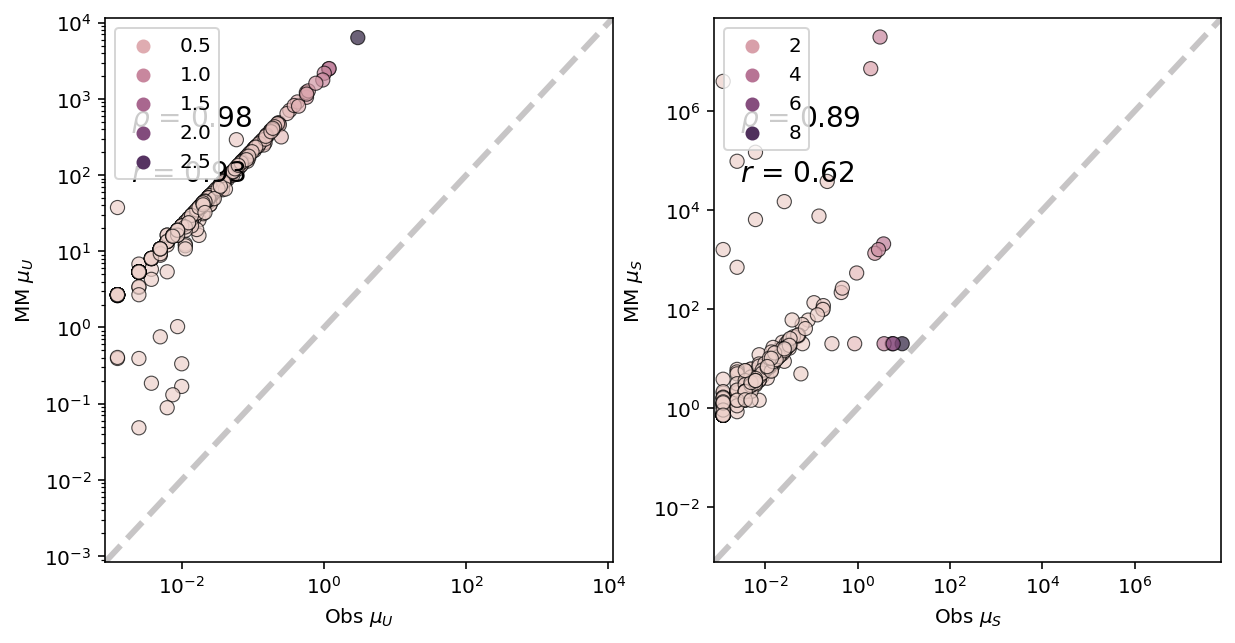

In [228]:
plot_means(sd,grid_point_results,res_inds=[4,4],clus_inds=[0,2],figsize=(10,5))

In [62]:
dataset_names

['allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k1',
 'allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k3',
 'allen_correct_B08_processed_hv_Vip_Lamp5_L5-6_NP_k5',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k1',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k3',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_k5',
 'allen_correct_B08_processed_hv_Vip',
 'allen_correct_B08_processed_hv_Lamp5',
 'allen_correct_B08_processed_hv_L5-6_NP',
 'allen_correct_B08_processed_hv_L6_CT',
 'allen_correct_B08_processed_hv_L2-3_IT',
 'allen_correct_B08_processed_hv_Vip']

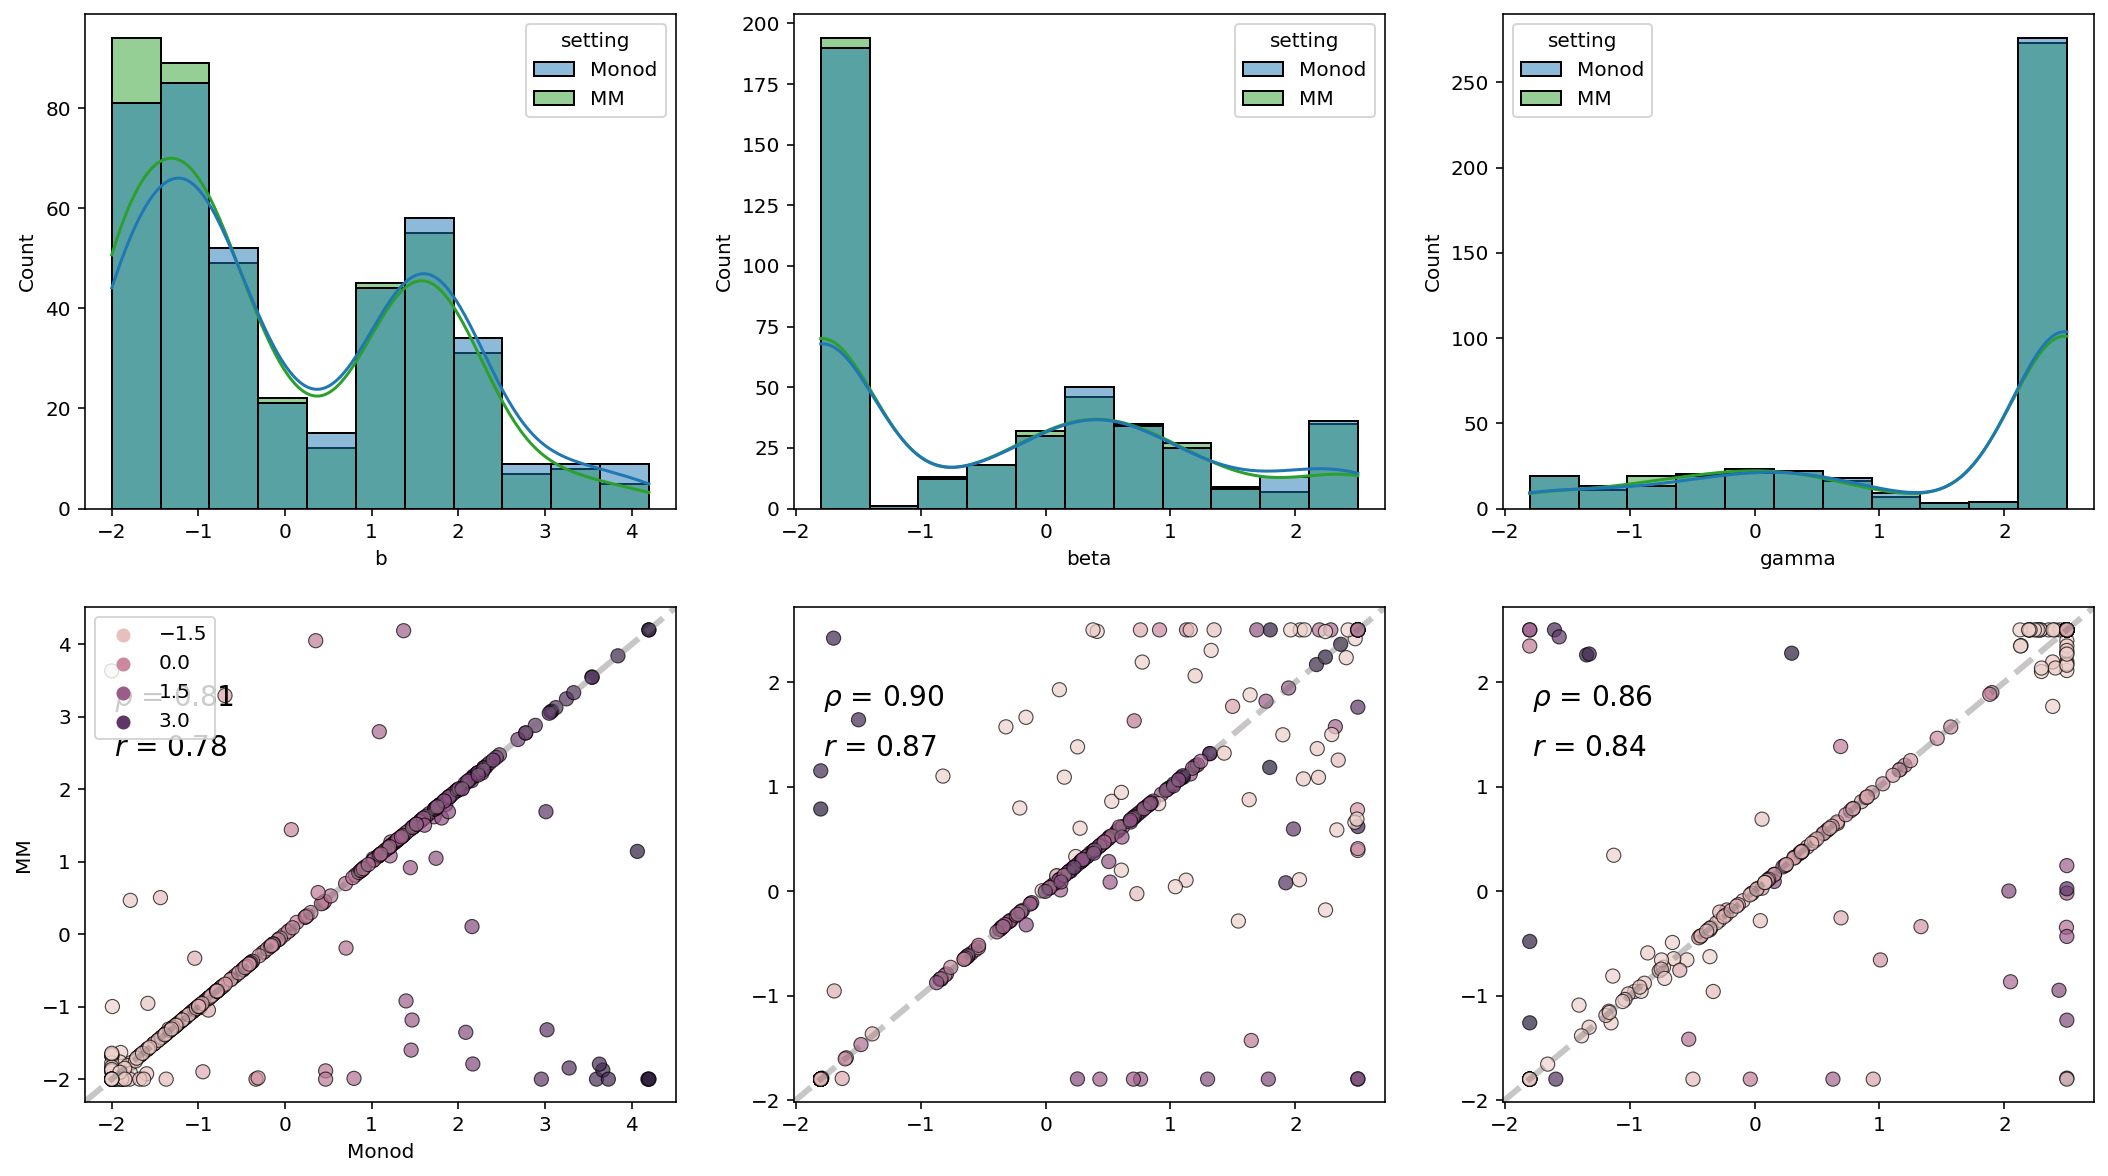

In [226]:
plot_params(sr,grid_point_results,res_inds=[4,4],clus_inds=[0,2],figsize=(18,10))

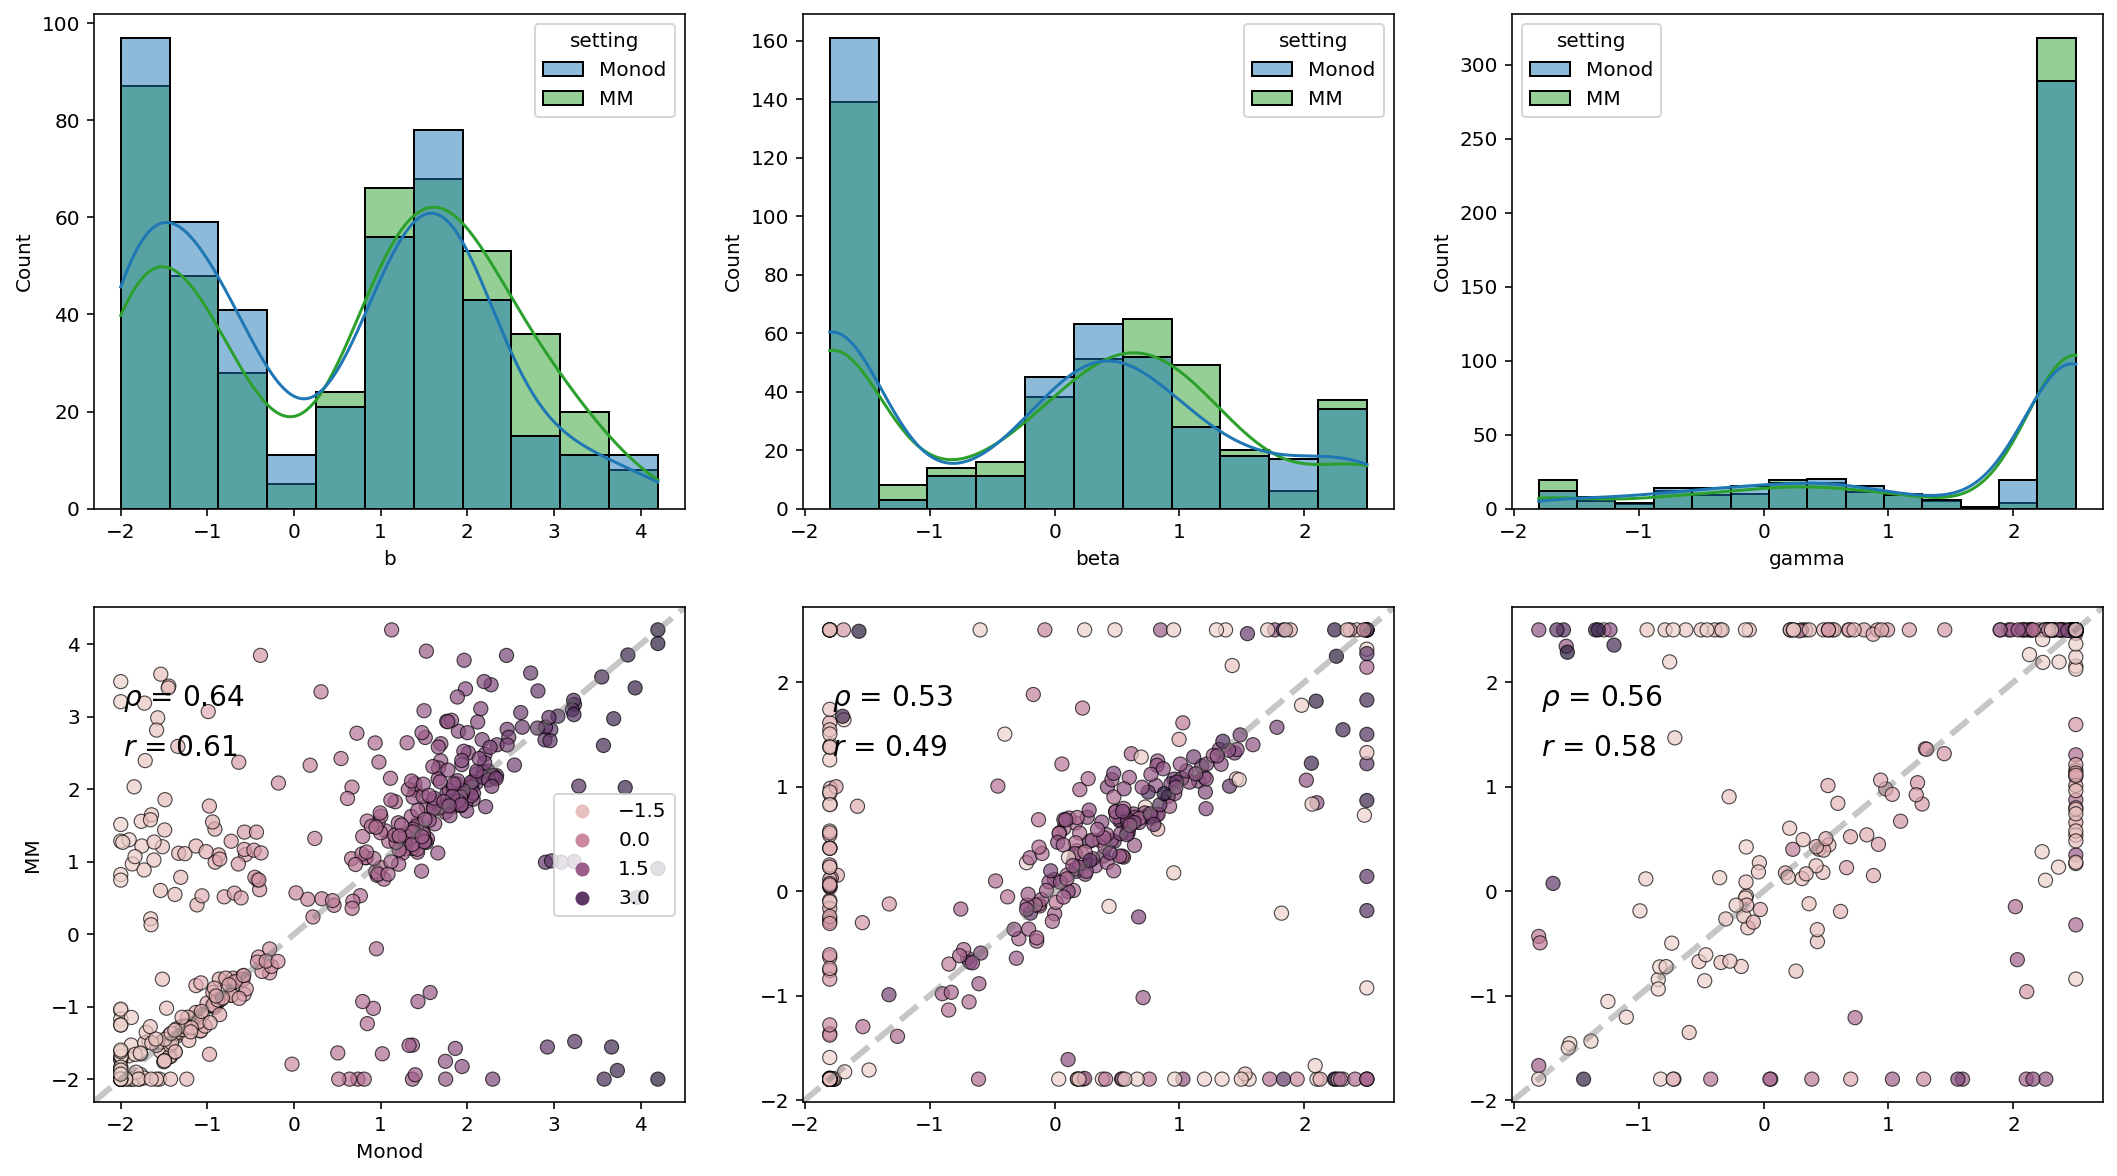

In [227]:
plot_params(sr,grid_point_results,res_inds=[3,3],clus_inds=[0,0],figsize=(18,10))